# ETF Portfolio Optimization & Dynamic Asset Allocation

**Last updated:** 2025-07-18

==============================================================================

       PORTFOLIO OPTIMIZATION & DYNAMIC ASSET ALLOCATION

==============================================================================

OVERVIEW:

This script performs a comprehensive portfolio analysis using various optimization
techniques. It begins with classic Mean-Variance Optimization and then explores
more advanced methods to create robust and dynamic asset allocation strategies.

The script is divided into the following main sections:

  1.  SETUP & CONFIGURATION:
      -   Loads necessary libraries and defines global settings.

  2.  DATA LOADING & PREPARATION:
      -   Fetches a list of Vanguard ETFs and their metadata via web scraping.
      -   Downloads historical price data for these ETFs from Yahoo Finance.
      -   Processes the data to calculate monthly returns over a specified window.

  3.  STATIC PORTFOLIO ANALYSIS (MEAN-VARIANCE OPTIMIZATION):
      -   Calculates expected returns and covariance, applying "shrinkage"
          techniques (Ledoit-Wolf) for more stable estimates.
      -   Computes the "Efficient Frontier" to find optimal portfolios.
      -   Applies L1 regularization to remove small weights.
      -   Constructs several static portfolios and compares them to a benchmark (VOO).

  4.  ADVANCED STATIC MODELS & ROBUSTNESS CHECKS:
      -   Implements Resampled Efficient Frontier, Rolling Window analysis,
          Black-Litterman, Risk Parity, Hierarchical Risk Parity (HRP), and
          DCC-GARCH models to create more robust portfolios.

  5.  REGIME-SWITCHING MODEL:
      -   Loads external economic data (VIX, Treasury yields) to help
          identify distinct market "regimes" (e.g., low-volatility growth,
          high-volatility decline).
      -   Fits a Markov Regime-Switching model to the market data.

  6.  REGIME-AWARE DYNAMIC STRATEGY:
      -   Calculates an optimal portfolio for each identified market regime.
      -   Backtests a dynamic strategy that adjusts its portfolio allocation
          based on the real-time probability of being in each regime.

  7.  FINAL PERFORMANCE COMPARISON:
      -   Plots the cumulative returns of all tested strategies.
      -   Calculates and displays a table of key performance metrics (Return,
          Volatility, Sharpe Ratio, Max Drawdown) for a comprehensive comparison.
      -   Runs a Monte Carlo simulation to forecast future performance.

==============================================================================
==============================================================================

### 1. Setup & Configuration

This cell imports required Python libraries, sets global display options,
and defines helper functions used throughout the analysis.

As a first step, load all package we are going to use.  There is a lot we will do, so we need to load a lot of packages.

In [93]:
# --- Standard Library Imports ---
import os
import re
import time
import warnings

# --- Third-Party Library Imports ---
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import cvxopt as opt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
from arch.univariate import ConstantMean, GARCH
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from pandas_datareader.data import DataReader
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import warnings
from arch.univariate.base import DataScaleWarning, ConvergenceWarning 
import plotly.graph_objects as go
from ipywidgets import FloatSlider, VBox, HTML, Button, Dropdown, HBox
from IPython.display import display


# --- Global Settings & Constants ---
# Set the working directory.
# NOTE: You may need to change this path to your project's root directory.
DIRECTORY = "."
os.chdir(DIRECTORY)

# Set the seed
np.random.seed(42)

# Analysis Period
ANALYSIS_YEARS = 15

# Optimization & Simulation Parameters
FRONTIER_POINTS = 50  # Number of points to calculate on the efficient frontier.
MC_SIM_SCENARIOS = 10000  # Number of scenarios for Monte Carlo simulation.
MC_SIM_HORIZON_MONTHS = 120  # 10-year horizon for simulation.
RESAMPLE_ITERATIONS = 100  # Number of bootstrap iterations for resampled frontier.
ROLLING_WINDOW_MONTHS = 60  # 5-year rolling window for dynamic weight analysis.

# Regime Modeling Parameters
MIN_OBS_PER_REGIME = 6  # Minimum data points required to consider a regime valid.
MAX_REGIMES_TO_TEST = 4  # Test models with 2 up to this number of regimes.

# --- Initial Setup ---
# Configure pandas for better display
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Configure the CVXOPT solver to not display progress messages
opt.solvers.options["show_progress"] = False

# ─── Warning filters ───
warnings.filterwarnings("ignore", category=UserWarning)            # generic statsmodels
warnings.filterwarnings("ignore", category=ConvergenceWarning)     # sklearn / statsmodels
warnings.filterwarnings("ignore", category=DataScaleWarning)       # ARCH data-scale
warnings.filterwarnings("ignore", category=RuntimeWarning)         # ARCH convergence

### 2. Data Loading & Preparation

What we will do in this section:
* **ETF universe:** Scrape the latest list of Vanguard ETFs.
* **Historical prices:** Retrieve adjusted close prices from Yahoo Finance via `yfinance`.
* **Return series:** Compute monthly returns and calculate mean and covariances.

First, we will need to find a systematic way to identify ETFs we can invest into.  Luckily, Vanguard is one of the leading ETF brokers and provides a great list of available ETFs [here](https://advisors.vanguard.com/investments/etfs).  We can just download the ETF list as csv-file, or we can scrape the table from the website directly.  I go with the latter solution so I always have the latest ETF list ready for the program.

The approach is quite straightforward: we use a webdriver to identify the table on the website, collect the relevant cells via their tags (in our case, ticker, ETF name, and expense ration), and click to the next page to do the same again.  You only need to make sure to add the path to the webdriver, in my case chromedriver. 

In [94]:
# We use Selenium to scrape the Vanguard advisor site for an up-to-date list of
# tickers, names, and expense ratios.
def extract_etf_data_from_page(driver_instance):
    """
    Extracts ETF data (Symbol, Name, Expense Ratio) from the currently
    viewed table on the Vanguard website.

    Args:
        driver_instance: The active Selenium WebDriver instance.

    Returns:
        A list of dictionaries, where each dictionary represents an ETF.
    """
    data = []
    try:
        table_body = driver_instance.find_element(By.CSS_SELECTOR, "table tbody")
        rows = table_body.find_elements(By.TAG_NAME, "tr")
        for row in rows:
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                symbol = cells[0].text.strip()
                # Fund name is in a nested div; clean up extraneous text like "NEW FUND"
                raw_name = row.find_elements(By.TAG_NAME, "div")[1].text.strip()
                fund_name = re.sub(
                    r"\s*(NEW FUND)?\s*$", "", raw_name.replace("\n", " ")
                ).strip()
                # Expense ratio is in the 8th column; clean and convert to float
                expense_text = cells[7].text.strip().replace("%", "").strip()
                expense_ratio = float(expense_text) / 100 if expense_text else None
                data.append(
                    {
                        "Symbol": symbol,
                        "Fund name": fund_name,
                        "Expense ratio": expense_ratio,
                    }
                )
            except (IndexError, ValueError):
                # Skip row if any element is missing or fails to parse
                continue
    except Exception as e:
        print(f"Error extracting table data: {e}")
    return data


try:
    print("Scraping ETF data from Vanguard website...")
    # Setup Selenium Chrome driver in headless mode (no visible browser window)
    chrome_options = Options()
    chrome_options.add_argument("--headless=new")
    chrome_options.add_argument("--disable-gpu")

    # IMPORTANT: Update this path to your local chromedriver executable.
    # For better portability, consider using webdriver-manager:
    # from webdriver_manager.chrome import ChromeDriverManager
    # service = Service(ChromeDriverManager().install())
    chrome_service = Service(executable_path="/Users/dominikjurek/Library/CloudStorage/Dropbox/Personal/Investment/chromedriver")
    
    driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

    # Load the Vanguard ETF page and wait for it to render
    driver.get("https://advisors.vanguard.com/investments/etfs")
    time.sleep(6)  # Allow time for JavaScript to load the table

    # Extract data from the first page
    all_etf_data = extract_etf_data_from_page(driver)

    # Click the "Next page" button to load the remaining ETFs
    try:
        next_button = driver.find_element(
            By.XPATH, '//button[@aria-label[contains(., "Forward one page")]]'
        )
        next_button.click()
        time.sleep(5)  # Wait for the second page to load
        all_etf_data += extract_etf_data_from_page(driver)
    except Exception as e:
        print(f"Could not navigate to the second page (or it doesn't exist): {e}")

    # Process the scraped data
    df_etf_metadata = pd.DataFrame(all_etf_data)
    etf_name_map = dict(zip(df_etf_metadata["Symbol"], df_etf_metadata["Fund name"]))
    etf_expense_map = dict(
        zip(df_etf_metadata["Symbol"], df_etf_metadata["Expense ratio"])
    )
    etf_symbols = list(etf_name_map.keys())
    print(f"Successfully extracted metadata for {len(etf_symbols)} ETFs.")
    print("Sample of extracted ETF data:")
    print(df_etf_metadata.head())
except Exception as e:
    # If scraping fails, fall back to a predefined list of core ETFs
    print(f"Could not complete web scraping. Reason: {e}")
    print("Falling back to a predefined list of core ETFs.")
    etf_symbols = [
        "VOO", "VTI", "VEA", "VWO", "BND", "BNDX", "VGIT", "VGLT", "VTIP", "MUB",
    ]
    etf_name_map = {s: s for s in etf_symbols}
    etf_expense_map = {s: 0.0003 for s in etf_symbols}  # Use a reasonable default
finally:
    if "driver" in locals() and driver:
        driver.quit()


Scraping ETF data from Vanguard website...
Successfully extracted metadata for 97 ETFs.
Sample of extracted ETF data:
  Symbol                       Fund name  Expense ratio
0   VBIL     0-3 Month Treasury Bill ETF          0.001
1   VTEC  California Tax-Exempt Bond ETF          0.001
2    VOX      Communication Services ETF          0.001
3    VCR      Consumer Discretionary ETF          0.001
4    VDC            Consumer Staples ETF          0.001


I want to ensure that my investment strategy is supported by broadly diversified ETFs, so I manually remove all industry-specific ETFs.  This is not really necessary to run the code or identify optimal portfolios, especially since the industry indices are themselves relatively well diversified across dozen or even hundreds of stocks.

In [95]:
# To create a diversified portfolio of broad asset classes, we remove
# specialized, sector-specific ETFs and redundant funds.
industry_keywords = [
    "Energy", "Health Care", "Consumer", "Materials", "Financials",
    "Utilities", "Real Estate", "Industrials", "Communication", "Information Technology",
]
# List of specific ETFs to remove (often sector-focused or overlapping)
remove_symbols = [
    "VGT", "VHT", "VPU", "VDC", "VAW", "VIS", "VFH", "VNQ", "VOX", "VDE", "VCR",
]


def is_industry_or_redundant(symbol, name_map):
    """Checks if an ETF is sector-specific or on the removal list."""
    name = name_map.get(symbol, "")
    is_industry = any(keyword in name for keyword in industry_keywords)
    is_redundant = symbol in remove_symbols
    return is_industry or is_redundant


etf_symbols = [s for s in etf_symbols if not is_industry_or_redundant(s, etf_name_map)]
etf_symbols = list(dict.fromkeys(etf_symbols))  # Ensure unique symbols
print(f"\nFiltered down to {len(etf_symbols)} ETFs for analysis.")


Filtered down to 85 ETFs for analysis.


Now it is time to download the price history for each of the ETFs from Yahoo Finance. 

In [96]:

def get_total_return_series(ticker):
    """
    Fetches maximum available historical prices for a ticker from Yahoo Finance,
    adjusted for dividends and splits to represent total return.

    Args:
        ticker (str): The stock or ETF symbol.

    Returns:
        pd.DataFrame: A DataFrame of historical adjusted closing prices.
                      Returns an empty DataFrame on failure.
    """
    print(f"Downloading data for {ticker}...")
    try:
        stock = yf.Ticker(ticker)
        # 'back_adjust=True' provides a total return series by adjusting historical
        # prices for both dividends and stock splits. 'auto_adjust=False' is required.
        df = stock.history(period="max", auto_adjust=False, back_adjust=True)[
            ["Close"]
        ].rename(columns={"Close": ticker})
        return df
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")
        return pd.DataFrame()


# Combine all price series into one DataFrame
all_prices_list = [get_total_return_series(ticker) for ticker in etf_symbols]
all_prices = pd.concat([df for df in all_prices_list if not df.empty], axis=1)

# Standardize the index to datetime objects without timezone information
all_prices.index = pd.to_datetime(all_prices.index).tz_localize(None)

# Resample daily prices to month-end, then calculate monthly percentage returns
returns_monthly = all_prices.resample("ME").last().pct_change()

# Limit data to the last N years for a more relevant analysis window
cutoff_date = returns_monthly.index.max() - pd.DateOffset(years=ANALYSIS_YEARS)
returns_monthly = returns_monthly[returns_monthly.index >= cutoff_date]

We will be using monthly observations for the most part, but we also need to remove NA values from the return table.  This is tricky, since the length of the ETF price history differs quite substantially, with some ET like the Total Treasury ETF (VTG) having no observations at all as it was created just recently.  Dropping all rows with NA values thus is not a solution.  Instead, we can require that ETFs have a minimum number of observations, in this case 10 years of data.  Since the ETF list on the website only contains currently available ETFs, we will drop all ETFs that have not at least 10 years of recent history.  We lose around around half of our ETFs through this, which is one of the main critiques of portfolio optimization: you need enough price history and basically have to exclude assets for which we cannot estimate covariances and expected returns.

In [97]:
# Data Cleaning:
# Drop ETFs that do not have at least 10 years of non-NA observations
MIN_OBSERVATIONS = 10 * 12
returns_monthly = returns_monthly.dropna(axis=1, thresh=MIN_OBSERVATIONS)

# Drop any month (row) that still has missing values
returns_monthly = returns_monthly.dropna(axis=0)

# Update final list of ETFs and related data based on the cleaned DataFrame
etf_symbols = returns_monthly.columns.tolist()

# The S&P 500 ETF (VOO) is our primary benchmark; it's required for the analysis.
if "VOO" not in etf_symbols:
    raise ValueError(
        "VOO data is missing or was dropped. It is required for benchmark comparison."
    )

# Create a NumPy array of expense ratios in the same order as our final ETF symbols
expense_vector = np.array([etf_expense_map.get(sym, 0.0) for sym in etf_symbols])

print(
    f"\nFinal analysis will use {len(etf_symbols)} ETFs over {len(returns_monthly)} months."
)
print(
    f"Analysis period: {returns_monthly.index.min().date()} to {returns_monthly.index.max().date()}"
)


Final analysis will use 55 ETFs over 145 months.
Analysis period: 2013-07-31 to 2025-07-31


Now we can explore the statistical properties of the ETFs we have.  With enough data, the central limit theorem tells us that we only need the first two moment to describe the distribution of random variables like returns, so let's have a look at means and variance.  

/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_2285/1079853296.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



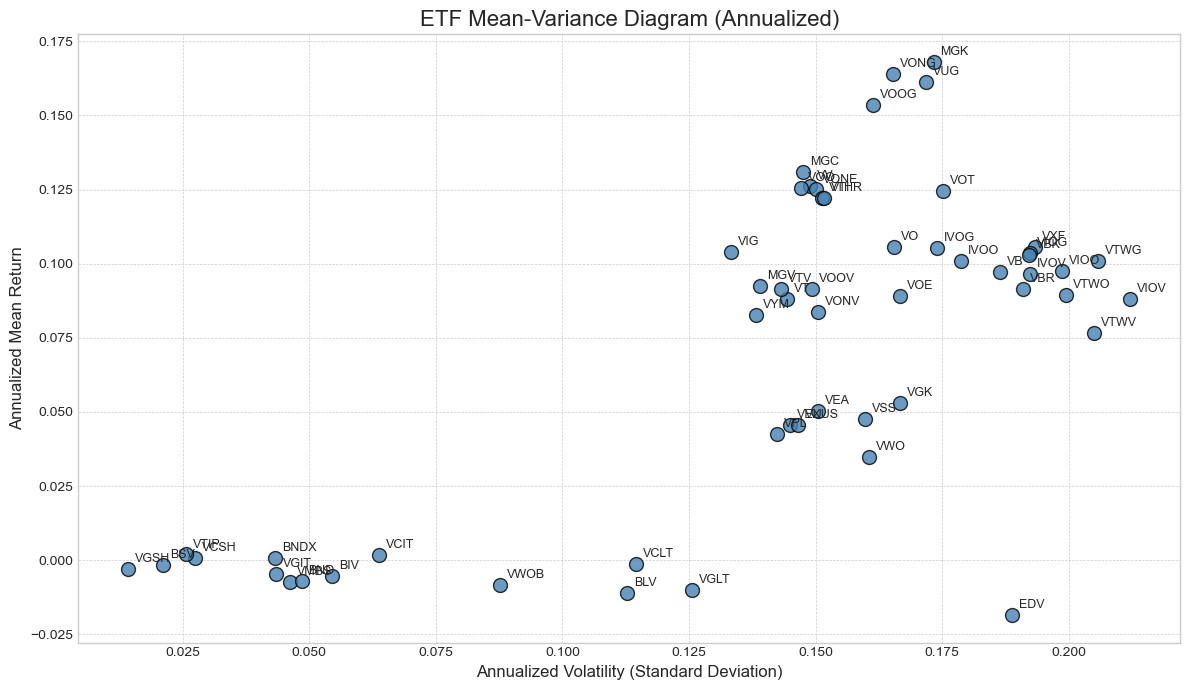

In [98]:
# Calculate annualized mean return and standard deviation
mean_returns = returns_monthly.mean() * 12  # 12 months in a year
volatility = returns_monthly.std() * np.sqrt(12)

# Create the scatter plot
plt.figure(figsize=(12, 7))
plt.scatter(volatility, mean_returns, color='steelblue', edgecolors='black', s=100, alpha=0.8)

# Annotate each ETF
for i, symbol in enumerate(etf_symbols):
    plt.annotate(symbol,
                 (volatility[i], mean_returns[i]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha='left', fontsize=9)

# Formatting the plot
plt.title("ETF Mean-Variance Diagram (Annualized)", fontsize=16)
plt.xlabel("Annualized Volatility (Standard Deviation)", fontsize=12)
plt.ylabel("Annualized Mean Return", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

As expected, there is quite a big variation.  Some ETFs have very low historic returns, like VCIT, the intermediate corporate bonds ETFs, but in exchange also low volatility.  That means, these ETFs are expected to have a small put relatively consistent return over time.  On the other hand, ETFs like MGK, Mega Cap Growth, have experienced very high return over the past 10 year (more than 17% p.a. on average!), but they were also enormously volatile.  

There is also the covariance between assets to consider.  

Let's first build some intuition how the covariance matrix of the ETFs actually looks like.

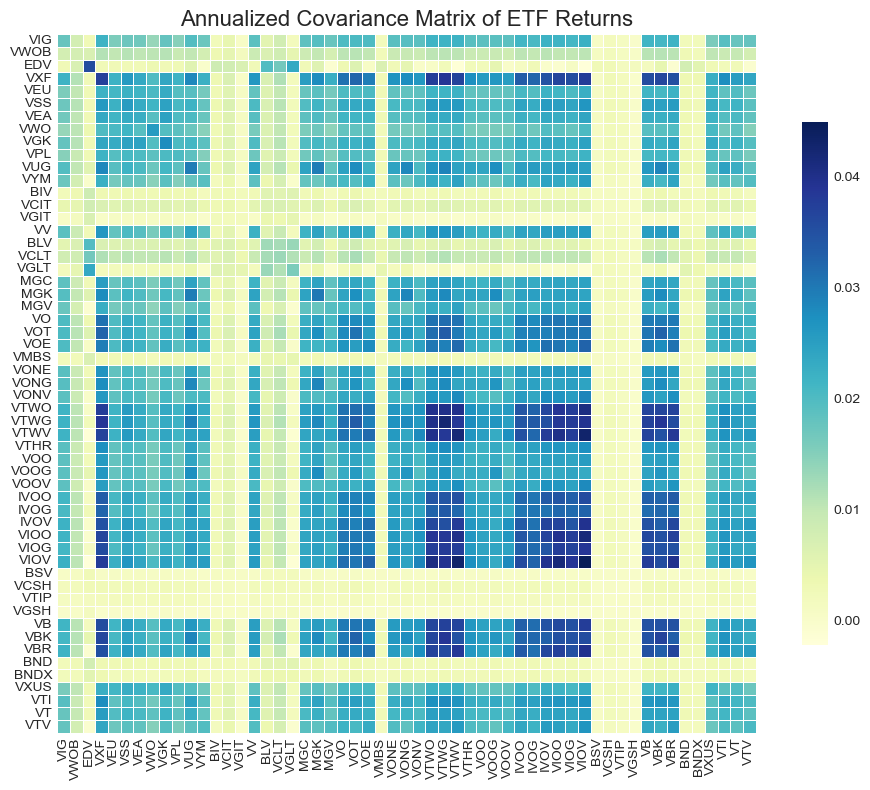

In [99]:
# Compute covariance matrix (annualized)
covariance_matrix = returns_monthly.cov() * 12

plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix,
            annot=False, fmt=".3f",
            cmap="YlGnBu",
            xticklabels=etf_symbols,
            yticklabels=etf_symbols,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.75})

plt.title("Annualized Covariance Matrix of ETF Returns", fontsize=16)
plt.tight_layout()
plt.show()

The covariance is quite widespread, just like the variance of in the diagonal.  Looking at the matrix, we actually can understand why portfolio optimization (and asset pricing in general) is focused on the covariance of assets.  There are only 55 elements in the diagonal (the variance of assets), but 55*54 elements everywhere else representing the covariance across assets.  So, it is much more important how asset co-vary with other assets rather than how volatile it is by itself. 

Let's also look at the correlation matrix:

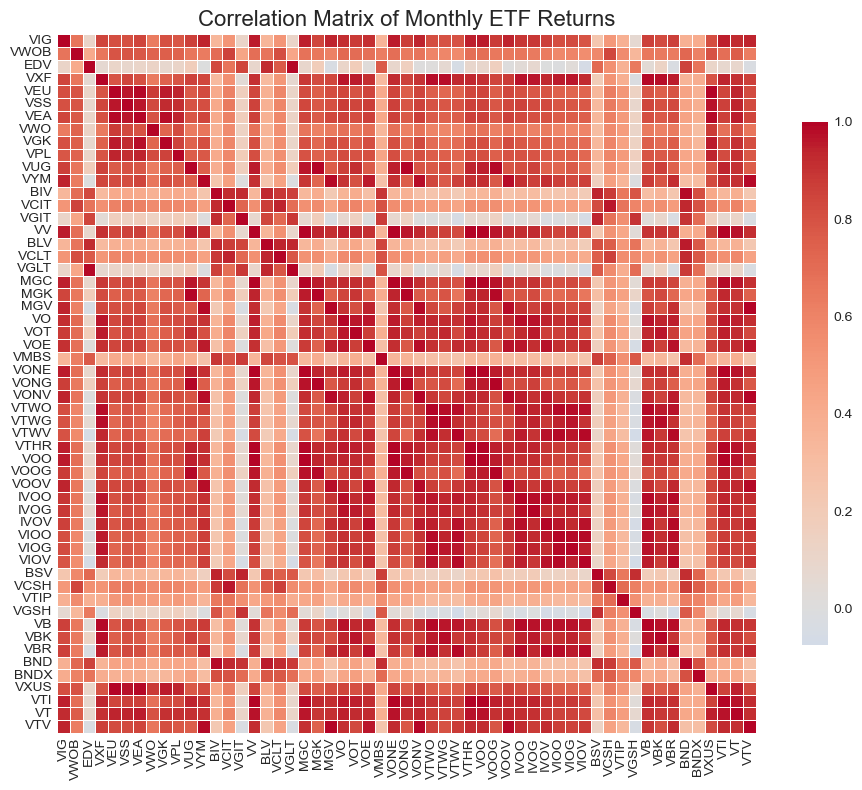

In [100]:
# Compute correlation matrix
correlation_matrix = returns_monthly.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=False, fmt=".2f",
            cmap="coolwarm", center=0,
            xticklabels=etf_symbols,
            yticklabels=etf_symbols,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.75})

plt.title("Correlation Matrix of Monthly ETF Returns", fontsize=16)
plt.tight_layout()
plt.show()

We already know assets have varying degrees of correlation from the covariance matrix, but the correlation matrix tells us one additional fact: no assets are perfectly correlated with each other (they would have a deep red color like the diagonal with correlation coefficient 1).  

This means that combinations of assets will have a lower variance than the weighted average of the variances.  To see why, consider the standard deviation of ETF 1 and ETF 2 and the linear combination of the two, with both asset not perfectly correlated

The portfolio variance of two assets is given by:

$$
\sigma_p^2 = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \rho_{12} \sigma_1 \sigma_2
$$

Since the correlation $\rho_{12} < 1$, the portfolio variance is **smaller** than the weighted average of the two ETF variances: 

$$
\sigma_p^2 < w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2
$$

For the expected returns, this is not true.  The expected return is a weighted average of the ETF expected returns.

$$
\mathbb{E}[R_p] = w_1 \mu_1 + w_2 \mu_2
$$

This is the idea behind **diversification**: by combining assets that are not perfectly correlated, the portfolio’s overall variance (risk) becomes lower than the average of the individual asset variances.  In other words, diversification helps smooth out the ups and downs, because not all assets move together.

Now we understand why diversification is great and we can try to find optimal portfolios that reduce the variance for a given expected return target, or maximize the expected return for a volatility/risk level we are willing to accept.

### 3. Static Portfolio Analysis — Mean‑Variance Optimization

In this section, we will define the efficient frontier based on the ETFs historic returns and covariance.

First, let's solve, the classic Markowitz (1952) problem:

$$
\min_{\mathbf{w}} \; \tfrac{1}{2} \mathbf{w}^\top \Sigma \mathbf{w}
\quad \text{subject to} \quad
\mathbf{w}^\top \mathbf{1} = 1, \quad
\mathbf{w}^\top \mu = \mu^*.
$$

That is, we find weights for the ETFs that minimize the variance of the portfolio that has the expected return $\mu^*$.  The only other constraint is that the weights sum up to one.  That's all.  We can build a efficient frontier with this approach by defining a sequence of target expected returns $\mu^*$ for the portfolios, between the smallest and largest returns of the ETFs, and solve for the minimum variance for each target $\mu^*$.  Since we are only dealing with first and second moments, so nothing of higher order than to the power of two, the minimization problem is convex and we can find unique portfolio weights that minimize the variance.

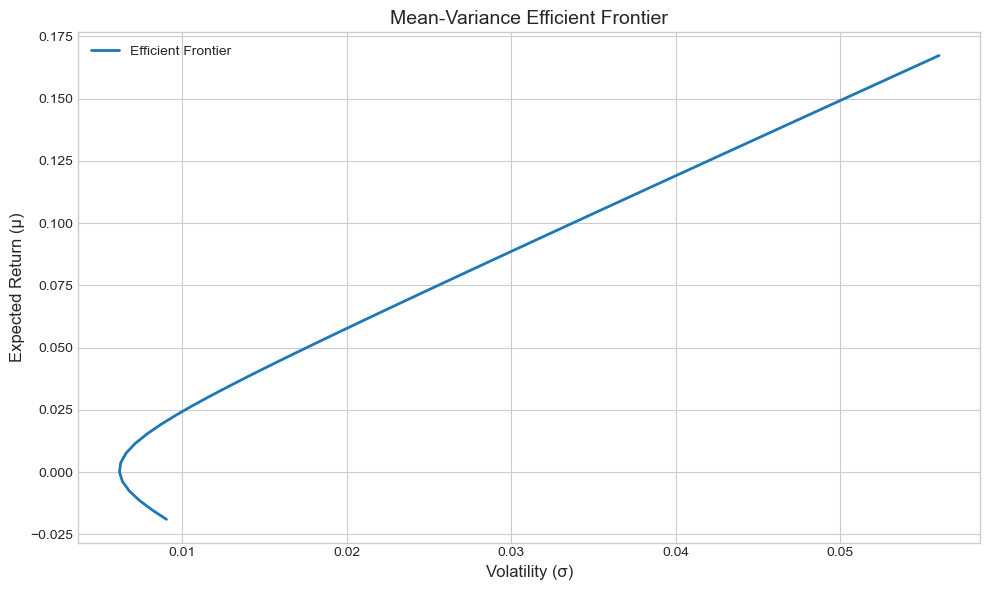

In [101]:
# These are the two key inputs for Markowitz portfolio optimization.
# 1. Expected Returns (mu): The anticipated annualized return for each asset.
# 2. Covariance Matrix (Sigma): A measure of how asset returns move together.

# Calculate historical annualized mean returns, net of expense ratios
annual_mu_sample = (returns_monthly.mean().values * 12) - expense_vector

# The sample covariance matrix is calculated from historical returns and annualized
sample_cov = returns_monthly.cov().values
annual_cov_sample = sample_cov * 12


def efficient_frontier_markowitz(expected_returns, covariance_matrix, n_points=50):
    """
    Computes the mean-variance efficient frontier using classic Markowitz optimization.

    Args:
        expected_returns (np.array): Vector of expected returns (annualized).
        covariance_matrix (np.array): Covariance matrix of returns (annualized).
        n_points (int): Number of portfolios to calculate along the frontier.

    Returns:
        dict: Contains lists of 'mu', 'sigma', and 'weights' for each portfolio.
    """
    n_assets = len(expected_returns)
    frontier = {"mu": [], "sigma": [], "weights": []}

    # Define QP parameters that don't change in the loop
    P = opt.matrix(covariance_matrix)
    q = opt.matrix(np.zeros(n_assets))
    
    # Equality constraint matrix A: one row for expected return, one for weights summing to 1
    A = opt.matrix(np.vstack([expected_returns, np.ones(n_assets)]))
    
    # Range of target returns
    target_mus = np.linspace(expected_returns.min(), expected_returns.max(), n_points)

    for mu_target in target_mus:
        b = opt.matrix([mu_target, 1.0])  # RHS of constraints
        try:
            sol = opt.solvers.qp(P, q, None, None, A, b)
            if sol['status'] == 'optimal':
                w = np.array(sol['x']).flatten()
                mu = w @ expected_returns
                sigma = np.sqrt(w @ covariance_matrix @ w)
                frontier["mu"].append(mu)
                frontier["sigma"].append(sigma)
                frontier["weights"].append(w)
        except:
            continue

    return frontier

# Compute the frontier
frontier_data = efficient_frontier_markowitz(annual_mu_sample, annual_cov_sample)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(frontier_data["sigma"], frontier_data["mu"], lw=2, label="Efficient Frontier")
plt.xlabel("Volatility (σ)", fontsize=12)
plt.ylabel("Expected Return (μ)", fontsize=12)
plt.title("Mean-Variance Efficient Frontier", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This looks exactly as expected!  The efficient frontier has the shape of a parabola on it's side, because eventually the variance of a portfolio is a sum over squared deviations from the mean.  We also see that for some volatilities we actually have two solution, a lower and an upper arm of the frontier (due to the quadratic nature of the problem).  The lower arm economically makes no sense, so we will prune the results later to remove it; practically, if an investor is willing to accept a level of risk (volatility) that has two optimal portfolios, he would only choose portfolios from the upper arm with highest return.

We eventually want to select optimal portfolios from the efficient frontier that minimize the variance for a specific target expected return, or that maximize the return for a given level of risk.  To check portfolio weights, we can look first at VOO, the S&P 500 ETF.  VOO is one of the largest ETFs worldwide and the S&P 500 is frequently used as a proxy for the overall market portfolio, so it makes sense to use VOO as a benchmark for our portfolio optimization.  Let's look at the portfolio weights of the efficient frontier portfolio that has the same expected return as VOO.

In [102]:
voo_returns_monthly = returns_monthly["VOO"]
voo_mu_annual = voo_returns_monthly.mean() * 12 - etf_expense_map.get("VOO", 0.0)
voo_sigma_annual = voo_returns_monthly.std() * np.sqrt(12)


def select_portfolio(frontier, target_metric, target_value):
    """
    Selects a portfolio from the efficient frontier closest to a target value.

    Args:
        frontier (dict): The efficient frontier dictionary.
        target_metric (str): The metric to match ('mu' or 'sigma').
        target_value (float): The target return or volatility.

    Returns:
        tuple: Index and weights of the selected portfolio, or (None, None).
    """
    if not frontier[target_metric]:
        return None, None
    diffs = np.abs(np.array(frontier[target_metric]) - target_value)
    idx = diffs.argmin()
    return idx, frontier["weights"][idx]

# Select matching portfolio
idx, weights_voo_match = select_portfolio(frontier_data, target_metric="mu", target_value=voo_mu_annual)

Let's visualize the results, specifically let's print the top and bottom three portfolio weights, the smallest weights in absolute terms, and plot weights.


Comparison with VOO:
VOO - Expected Return: 12.54%, Volatility: 14.71%
Selected Portfolio - Expected Return: 12.55%, Volatility: 4.21%

Top 3 Weights in Selected Portfolio:
VCIT: 339.30%
BSV: 286.62%
VB: 264.34%

Bottom 3 Weights in Selected Portfolio:
VV: -243.56%
BIV: -265.84%
BND: -680.44%

3 Smallest Absolute Weights in Selected Portfolio:
VGSH: 0.08%
VTIP: 2.23%
VOOG: -2.46%


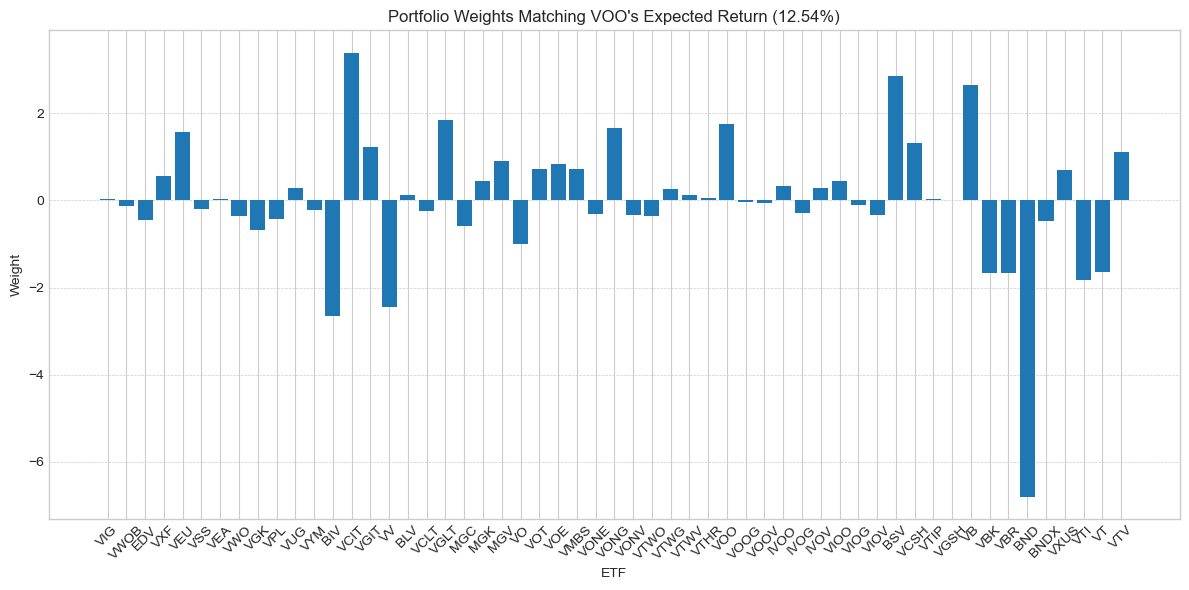

In [103]:
if weights_voo_match is not None:
    selected_mu = frontier_data["mu"][idx]
    selected_sigma = frontier_data["sigma"][idx]

    print(f"\nComparison with VOO:")
    print(f"VOO - Expected Return: {voo_mu_annual:.2%}, Volatility: {voo_sigma_annual:.2%}")
    print(f"Selected Portfolio - Expected Return: {selected_mu:.2%}, Volatility: {selected_sigma:.2%}")

    # Zip symbols and weights, then sort by weight
    weights_named = list(zip(etf_symbols, weights_voo_match))
    sorted_weights = sorted(weights_named, key=lambda x: x[1], reverse=True)
    sorted_by_abs = sorted(weights_named, key=lambda x: abs(x[1]))

    print("\nTop 3 Weights in Selected Portfolio:")
    for symbol, weight in sorted_weights[:3]:
        print(f"{symbol}: {weight:.2%}")

    print("\nBottom 3 Weights in Selected Portfolio:")
    for symbol, weight in sorted_weights[-3:]:
        print(f"{symbol}: {weight:.2%}")

    print("\n3 Smallest Absolute Weights in Selected Portfolio:")
    for symbol, weight in sorted_by_abs[:3]:
        print(f"{symbol}: {weight:.2%}")


    plt.figure(figsize=(12, 6))
    plt.bar(etf_symbols, weights_voo_match)
    plt.title(f"Portfolio Weights Matching VOO's Expected Return ({voo_mu_annual:.2%})")
    plt.ylabel("Weight")
    plt.xlabel("ETF")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No matching portfolio found on the frontier.")

This is unfortunately a very typical result for portfolio optimization: the expected volatility for the optimal portfolio is much lower than for VOOs, but it is practically infeasible as there are many assets with extreme weights in the optimal portfolio.  BND, the Total Bond Market ETF, for example, should have a weight of more than -600%, while VCIT, the intermediate corporate bond ETF, should have a weight of more than 300%!  In other words, if you want to invest $1, you should short-sell $6 of BND and use the proceeds to purchase $3 of VCIT, etc.  This is not really feasible for the normal investors.  

We could also encounter a second problem: there are many portfolios with quite small weights, such as VTIP, the Short-Term Inflation-Protected Securities ETF, having a weight of just 2.5%.  This is not very large and it makes the implementation of trading strategies difficult if you have to purchase many ETFs with tiny weights.

A third problem we have not mentioned yet is estimation error.  Given how extreme the weights are, even small errors in the estimated expected return or the covariance matrix can lead to substantial changes in the optimal portfolio allocations.  


To account for the problem we have seen above, we can do the following
- **Add long-only constraints**: we can add additional constraints to make sure each portfolio weight is between zero and one.  This is much more realistic for an individual investor.

- **Apply L1 regularization**: we can adapt the idea from LASSO regression and add a penalty for large and non-zero weight, making it more likely that the optimization shrinks more weights to zero and reducing the number of components in the optimal portfolio.  We need to decide on a the meta-parameter for the penalty, lambda, which can do via a simple grid search.  Choosing to small of a lambda and we might have too many small ETFs in the optimal portfolio, choosing to large a lambda and we introduce too much of a bias and the portfolio is not optimal anymore.  So, let's look for the lambda that maximizes the Sharpe ratio, expected return over sigma, for the optimal portfolio that matches VOO's expected return.  The Sharpe ratio is a measure of the price of risk, so it makes sense to choose the highest possible return that we can get for one unit of risk, i.e., volatility.

- **Apply shrinkage methods to $\mu$ and $\sigma$**: To reduce the effect of estimation error in the expected return and the covariance matrix, we can apply shrinkage methods for both.  We can try James-Stein for the expected return and Ledoit-Wolf for the covariance matrix.  Both shrink the sample estimates to a reasonable target, thus reducing estimation error and noise of the estimates.  James-Stein shrinks to the sample mean of the ETFs to the grand mean over all ETFs, and Ledoit-Wolf shrink the covariance matrix to the identify matrix.

Useful sources on the Lasso regularization in quadratic programming is [Stéphane Caron's blog](https://scaron.info/blog/lasso-regularization-in-quadratic-programming.html) and the [original paper by Rovert Tibshirani](https://academic.oup.com/jrsssb/article-pdf/58/1/267/49098631/jrsssb_58_1_267.pdf), *Regression Shrinkage and Selection via the Lasso*.

Thus, we can rewrite the optimization problem as follows, with $\mu$ and $\Sigma$ either as the sample mean and covariance, or by using shrinkage methods first.

#### Objective

$$
\min_{\mathbf{w}, \mathbf{u}} \quad \tfrac{1}{2} \mathbf{w}^\top \Sigma \mathbf{w} + \lambda \sum_{i=1}^n u_i
$$


#### Constraints

1. **L1 Reformulation (Enforce $ u_i \ge |w_i| $)**

$$
w_i - u_i \le 0 \quad \text{(i.e., } u_i \ge w_i \text{)}
$$

$$
-w_i - u_i \le 0 \quad \text{(i.e., } u_i \ge -w_i \text{)}
$$

2. **Long-only Constraints**

$$
0 \le w_i \le 1
$$

3. **Budget Constraint**

$$
\sum_{i=1}^n w_i = 1
$$

4. **Target Return Constraint**

$$
\sum_{i=1}^n w_i \mu_i = \mu^*
$$


In [104]:
def efficient_frontier(
    covariance_matrix, expected_returns, n_points=50, lambda_l1=0.0
):
    """
    Calculates the efficient frontier using the Markowitz model with optional L1
    regularization (LASSO). This encourages sparse portfolios by driving the
    weights of less important assets to exactly zero.

    This function reformulates the L1-regularized problem into a standard
    Quadratic Program (QP) that can be solved efficiently by CVXOPT.

    Args:
        covariance_matrix (np.array): Annualized covariance matrix of asset returns.
        expected_returns (np.array): Annualized vector of expected asset returns.
        n_points (int): The number of points to calculate along the frontier.
        lambda_l1 (float): The regularization strength. Higher values lead to
                           more sparsity (more zero weights).

    Returns:
        dict: A dictionary containing returns ('mu'), volatilities ('sigma'),
              and portfolio weights ('weights') for each point on the frontier.
    """
    n_assets = len(expected_returns)

    # We solve for a combined vector x = [w, u] of size 2*n_assets, where:
    # w: the standard portfolio weights (n_assets)
    # u: auxiliary variables to handle the absolute value |w_i| (n_assets)
    # The objective becomes: minimize 0.5*w'.Cov.w + lambda*1'.u
    # Subject to: w-u <= 0, -w-u <= 0 (which implies u >= |w|)

    # 1. The Quadratic Term P
    # Only involves 'w', so P_new has the original covariance_matrix in the
    # top-left block and zeros elsewhere.
    P_l1 = opt.matrix(
        np.block(
            [
                [covariance_matrix, np.zeros((n_assets, n_assets))],
                [np.zeros((n_assets, n_assets)), np.zeros((n_assets, n_assets))],
            ]
        )
    )

    # 2. The Linear Term q
    # The L1 penalty `lambda * sum(|w_i|)` is reformulated as `lambda * sum(u_i)`.
    # This becomes the linear part of the objective, q'.x.
    q_l1 = opt.matrix(np.concatenate([np.zeros(n_assets), lambda_l1 * np.ones(n_assets)]))

    # 3. The Inequality Constraints G and h (for Gx <= h)
    # These enforce u_i >= |w_i| and the original box constraints 0 <= w_i <= 1.
    I = np.eye(n_assets)
    Z = np.zeros((n_assets, n_assets))
    G_l1 = opt.matrix(
        np.block(
            [
                [I, -I],  # For w_i - u_i <= 0
                [-I, -I],  # For -w_i - u_i <= 0
                [-I, Z],  # For -w_i <= 0 (w_i >= 0)
                [I, Z],  # For w_i <= 1
            ]
        )
    )
    h_l1 = opt.matrix(np.concatenate([np.zeros(3 * n_assets), np.ones(n_assets)]))

    # 4. The Equality Constraints A and b (for Ax = b)
    # These constraints (sum of weights = 1, portfolio return = target)
    # only apply to the 'w' part of our variable vector 'x'.
    A_l1 = opt.matrix(
        np.block(
            [
                [expected_returns, np.zeros(n_assets)],
                [np.ones(n_assets), np.zeros(n_assets)],
            ]
        )
    )

    # Iterate through a range of target returns to trace the frontier
    target_mus = np.linspace(expected_returns.min(), expected_returns.max(), n_points)
    frontier = {"mu": [], "sigma": [], "weights": []}
    for target_mu in target_mus:
        # The RHS of the equality constraint
        b_l1 = opt.matrix([target_mu, 1.0])
        try:
            # Solve the larger, reformulated QP problem
            solution = opt.solvers.qp(P_l1, q_l1, G_l1, h_l1, A_l1, b_l1)
            if solution["status"] == "optimal":
                # Extract only the weights 'w' from the solution vector 'x'.
                weights = np.array(solution["x"][:n_assets]).flatten()
                # Clean up tiny weights due to solver precision
                weights[np.abs(weights) < 1e-7] = 0
                # Re-normalize to ensure sum is exactly 1 after cleanup
                if np.sum(weights) > 0:
                    weights /= np.sum(weights)

                sigma = np.sqrt(weights.T @ covariance_matrix @ weights)
                actual_mu = weights.T @ expected_returns
                frontier["mu"].append(actual_mu)
                frontier["sigma"].append(sigma)
                frontier["weights"].append(weights)
        except ValueError:
            # Solver may fail if no feasible solution exists for a target return
            pass
    return frontier


def prune_frontier(frontier):
    """
    Removes dominated portfolios from a mean-variance frontier, keeping only
    the efficient upper arm where return increases with volatility.

    Args:
        frontier (dict): A dict with keys 'sigma', 'mu', 'weights'.

    Returns:
        dict: A pruned frontier with the same structure.
    """
    vol = np.asarray(frontier["sigma"])
    ret = np.asarray(frontier["mu"])
    wlist = list(frontier["weights"])

    # 1) Sort by volatility (ascending)
    order = np.argsort(vol)
    vol, ret = vol[order], ret[order]
    wlist = [wlist[i] for i in order]

    # 2) Walk from left to right, keeping only points with strictly increasing returns
    keep_idx = []
    last_best_ret = -np.inf
    for i in range(len(ret)):
        if ret[i] > last_best_ret + 1e-12:
            keep_idx.append(i)
            last_best_ret = ret[i]

    # 3) Assemble the pruned frontier
    return {
        "sigma": vol[keep_idx].tolist(),
        "mu": ret[keep_idx].tolist(),
        "weights": [wlist[i] for i in keep_idx],
    }

We need to still define the optimal L1 penalty term for regularization, $\lambda$.  Too large a parameter promotes sparsity but introduces too much bias, while too small a parameter is ineffective in removing small weights.  Let's do a grid search and find the parameters that maximizes the Sharp ratio of the optimal portfolio that was matches VOO's volatility.  We can use a training-test split to compare $\lambda$'s based on out-of-sample performance.   

In [105]:
#  Grid-Search for the "Best" L1-Penalty (lambda_1)
# - A simple train/validation split is used (last 20% = validation).
# - The metric for "best" is the out-of-sample Sharpe Ratio.
# - The portfolio on the frontier is chosen by matching VOO's volatility.
print("\n--- Grid-searching for optimal L1 penalty (lambda) ---")
lambda_grid = np.logspace(-6, -1, 11)  # 11 points: 1e-6 to 1e-1
val_frac = 0.20
target_sig = voo_mu_annual

# Split data into training and validation sets
T = len(returns_monthly)
split_idx = int((1 - val_frac) * T)
ret_train = returns_monthly.iloc[:split_idx]
ret_val = returns_monthly.iloc[split_idx:]

mu_train = ret_train.mean().values * 12
cov_train = ret_train.cov().values * 12
mu_val = ret_val.mean().values * 12
cov_val = ret_val.cov().values * 12


def sharpe_ratio(mu, sigma):
    """
    Calculates annualized Sharpe ratio from annualized decimal returns.
    (Assumes risk-free rate = 0).
    """
    return mu / sigma if sigma > 0 else np.nan


def eval_lambda(lam):
    """Fit frontier with lambda_1=lam on train-set, score on validation."""
    front = efficient_frontier(cov_train, mu_train, n_points=30, lambda_l1=lam)
    _, w = select_portfolio(front, "mu", target_sig)
    if w is None:
        return np.nan
    mu_out_of_sample = w @ mu_val
    sigma_out_of_sample = np.sqrt(w @ cov_val @ w)
    return sharpe_ratio(mu_out_of_sample, sigma_out_of_sample)


# Perform grid search
scores = [eval_lambda(lam) for lam in lambda_grid]
best_idx = int(np.nanargmax(scores))
best_lambda = float(lambda_grid[best_idx])

# Report results
print(f"lambda_1 candidates: {[f'{l:.5g}' for l in lambda_grid]}")
print(f"Validation Sharpe: {[f'{s:.3f}' for s in scores]}")
print(f"\n-> Selected optimal lambda_1 = {best_lambda:.5g}\n")


--- Grid-searching for optimal L1 penalty (lambda) ---
lambda_1 candidates: ['1e-06', '3.1623e-06', '1e-05', '3.1623e-05', '0.0001', '0.00031623', '0.001', '0.0031623', '0.01', '0.031623', '0.1']
Validation Sharpe: ['1.824', '1.824', '1.824', '1.824', '1.824', '1.824', '1.824', '1.824', '1.824', '1.824', '1.824']

-> Selected optimal lambda_1 = 0.031623



Before we implement models with shrinkage estimates for $\mu$ and $\Sigma$, we should see how they compare to the sample mean and covariance.

There are many sources for shrinkage estimators, for James-Stein, for example, these [lecture notes by Maxime Cauchois](https://web.stanford.edu/class/stats50/files/STATS_50_Regression_to_the_mean.pdf) provide a nice summary, or the [paper by Eric Bennett Rasmusen](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2675681), *Understanding Shrinkage Estimators: From Zero to Oracle to James-Stein*.  For Ledoit-Wolf, the [original paper](https://perso.ens-lyon.fr/patrick.flandrin/LedoitWolf_JMA2004.pdf), *A well-conditioned estimator for large-dimensional covariance matrices* provide a solid source, but also the [sklean documentation about covariance shrinkage](https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance) is very useful. 

The James-Stein estimator is a famours and straightforward approach to use Bayesian-style shrinkage to the expected return.  It's formula is data-driven and basically tries to shrink the sample means for each asset towards the grand mean.  I use the following formula:

$$
\hat\mu^{\text{JS}}_i \;=\; (1-\lambda)\,\hat\mu_i \;+\; \lambda\,\bar\mu,
\qquad
\lambda \;=\; \min\!\Bigl[1,\;\frac{(p-2)\,s^{2}}{\sum_{j=1}^{p}(\hat\mu_j-\bar\mu)^{2}}\Bigr]
$$

with $\bar\mu=\tfrac{1}{p}\sum_{j=1}^{p}\hat\mu_j$ and $s^{2}=\tfrac{1}{p-1}\sum_{j=1}^{p}(\hat\mu_j-\bar\mu)^{2}$.


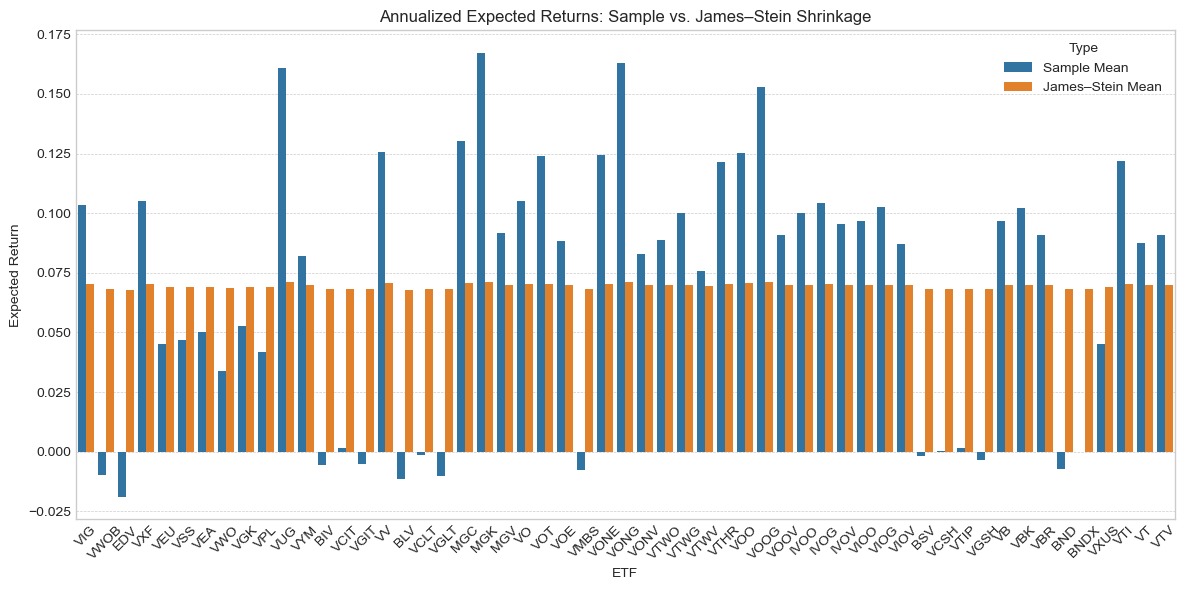

In [106]:
def james_stein_shrinkage(mu_hat):
    """
    Applies James–Stein shrinkage to the vector of sample means.

    Args:
        mu_hat (np.ndarray): Sample mean returns (shape: [n_assets]).

    Returns:
        np.ndarray: Shrunk mean returns.
    """
    p = len(mu_hat)
    mu_bar = np.mean(mu_hat)
    numerator = (p - 2) * np.var(mu_hat, ddof=1)
    denominator = np.sum((mu_hat - mu_bar) ** 2)
    
    # Guard against division by zero
    if denominator == 0:
        lambda_js = 0
    else:
        lambda_js = min(1, max(0, numerator / denominator))

    mu_shrunk = (1 - lambda_js) * mu_hat + lambda_js * mu_bar
    return mu_shrunk


# Mean shrinkage
annual_mu_shrunk = james_stein_shrinkage(annual_mu_sample)

# Create DataFrame for plotting
df_mu = pd.DataFrame({
    "ETF": etf_symbols,
    "Sample Mean": annual_mu_sample,
    "James–Stein Mean": annual_mu_shrunk
})

# Melt to long format for seaborn
df_mu_melted = df_mu.melt(id_vars="ETF", var_name="Type", value_name="Return")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mu_melted, x="ETF", y="Return", hue="Type")
plt.xticks(rotation=45)
plt.title("Annualized Expected Returns: Sample vs. James–Stein Shrinkage")
plt.ylabel("Expected Return")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


We see very different results: James-Stein is too aggressive and shrink the annual means of the ETFs to severely to the grand mean, while Ledoit-Wolf barely changes the covariance matrix.  I appears that since the sample means are no too widely distributed, James-Stein shrinks them relatively quickly towards the grand mean, while the sample covariance matrix is already quite stable due to the 120 observations going into its estimation, so Ledoit-Wolf does not change much.

Instead of the harsh shrinkage by James-Stein, let's use a more gentle shrinkage parameter, that preserves more of the dispersion of the expected returns.

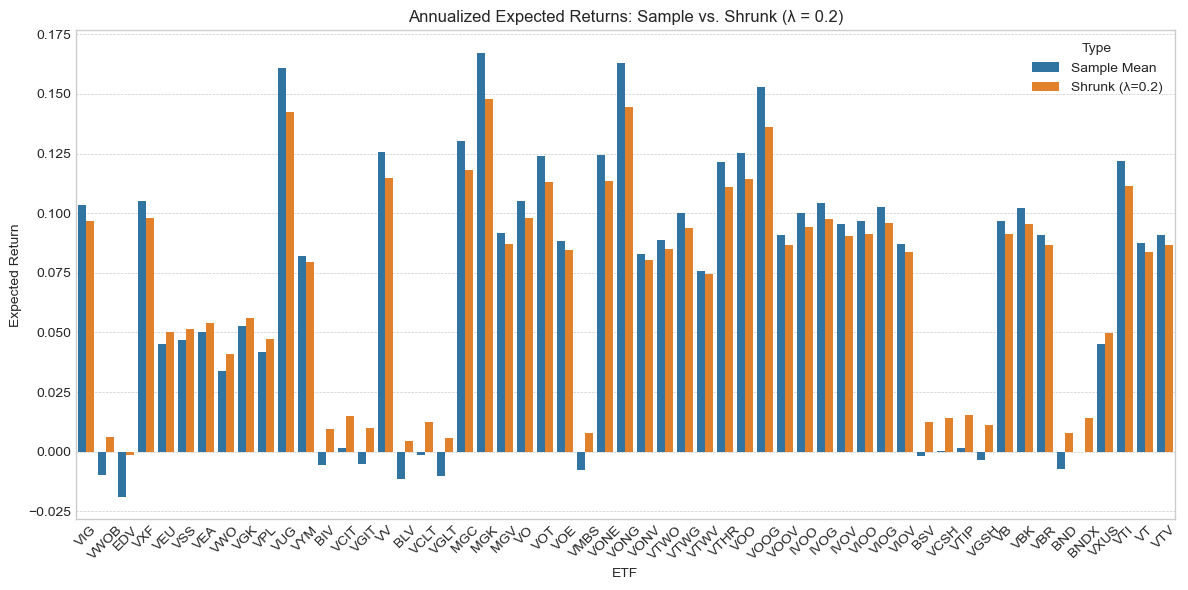

In [107]:
lambda_small = 0.2  # small shrinkage strength
mu_grand = np.mean(annual_mu_sample)
annual_mu_shrunk_partial = (1 - lambda_small) * annual_mu_sample + lambda_small * mu_grand

# Build DataFrame
df_mu_partial = pd.DataFrame({
    "ETF": etf_symbols,
    "Sample Mean": annual_mu_sample,
    f"Shrunk (λ={lambda_small})": annual_mu_shrunk_partial
})

# Melt to long format for plotting
df_mu_melted = df_mu_partial.melt(id_vars="ETF", var_name="Type", value_name="Return")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mu_melted, x="ETF", y="Return", hue="Type")
plt.xticks(rotation=45)
plt.title(f"Annualized Expected Returns: Sample vs. Shrunk (λ = {lambda_small})")
plt.ylabel("Expected Return")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

To shrink the covariance, we can apply Ledoit-Wolf.  The basic approach here can also be viewed as Bayesian-like shrinkage for the covariance matrix towards the a grand-mean type identifity matrix that has the average variance in the diagonal.  The precise formula for the weights is quite complicated, but it is worth noting that the weight on the diagonal target matrix decreases decreases.  The formula looks like this:

$$
\Sigma_{\text{LW}} = (1-\delta)\,S + \delta F,
\qquad
F = \bar{s}\,I,\qquad
\bar{s} = \frac{1}{p}\operatorname{tr}(S).
$$

* $S$ = sample covariance matrix
* $F$ = scaled identity matrix with the same average variance as $S$
* $0\le\delta\le1$ = data-driven shrinkage weight picked by the Ledoit-Wolf rule to minimise estimation error

Luckily, the implementation in Python is straightforward with a sklearn-library.  We can then compare the heat-map of the raw and the shrunk covariance matrix.

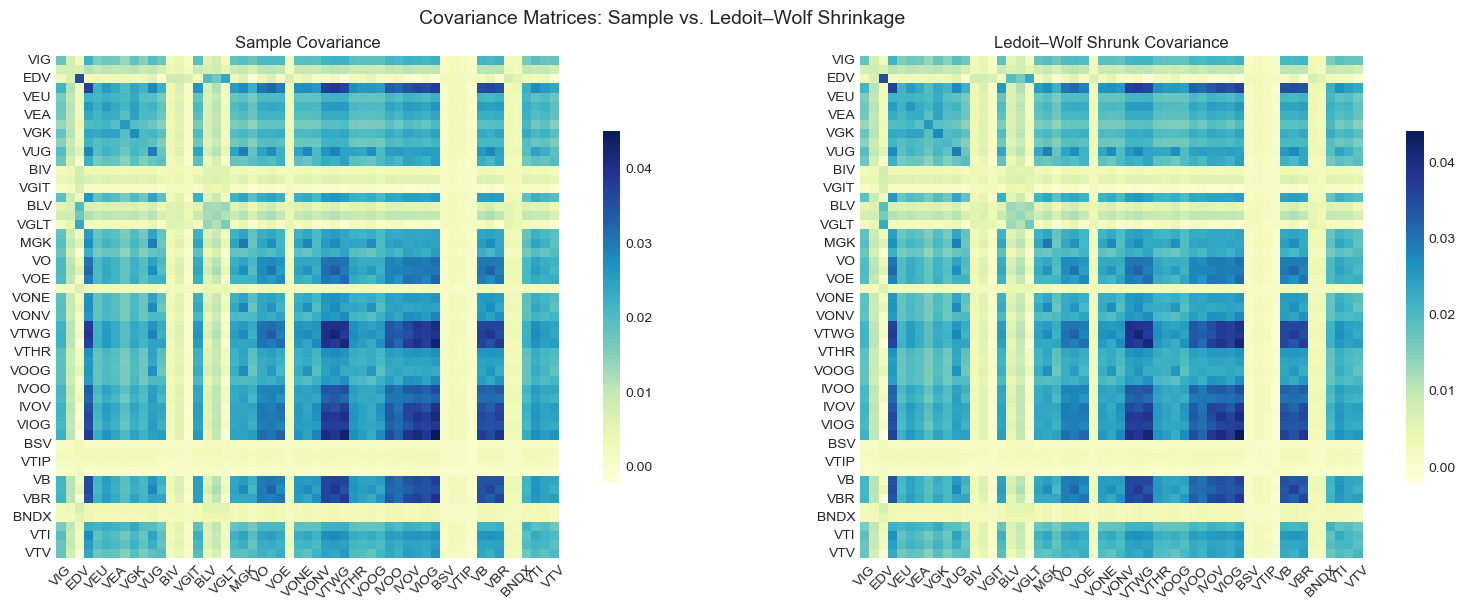

In [108]:
# Covariance shrinkage
lw = LedoitWolf().fit(returns_monthly.values)
annual_cov_shrunk = lw.covariance_ * 12

# Convert to DataFrames for heatmap comparison
df_cov_sample = pd.DataFrame(annual_cov_sample, index=etf_symbols, columns=etf_symbols)
df_cov_shrunk = pd.DataFrame(annual_cov_shrunk, index=etf_symbols, columns=etf_symbols)

# Plot side-by-side heatmaps
fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

sns.heatmap(df_cov_sample, cmap="YlGnBu", ax=axs[0], square=True, cbar_kws={"shrink": 0.7})
axs[0].set_title("Sample Covariance")

sns.heatmap(df_cov_shrunk, cmap="YlGnBu", ax=axs[1], square=True, cbar_kws={"shrink": 0.7})
axs[1].set_title("Ledoit–Wolf Shrunk Covariance")

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.suptitle("Covariance Matrices: Sample vs. Ledoit–Wolf Shrinkage", fontsize=14)
plt.show()

Finally, let us generate the efficient frontiers and compare the portfolios for each efficient frontier that match VOO's expected mean or volatility.  Let's also print the top weights for each optimal portfolio.

In [109]:
# Frontier using simple sample estimates
ef_raw = prune_frontier(
    efficient_frontier(annual_cov_sample, annual_mu_sample, n_points=FRONTIER_POINTS)
)
# Frontier using L1 regularization
ef_reg_l1 = prune_frontier(
    efficient_frontier(
        annual_cov_shrunk, annual_mu_sample, n_points=FRONTIER_POINTS, lambda_l1=best_lambda
    )
)
# Frontier using shrinkage-adjusted covariance
ef_shrunk = prune_frontier(
    efficient_frontier(annual_cov_shrunk, annual_mu_sample, n_points=FRONTIER_POINTS)
)
# Frontier using also shrinkage-adjusted means
ef_shrunk_mean = prune_frontier(
    efficient_frontier(annual_cov_shrunk, annual_mu_shrunk_partial, n_points=FRONTIER_POINTS)
)

# Find portfolios on each frontier matching the VOO benchmark's risk or return
_, w_mu_raw = select_portfolio(ef_raw, "mu", voo_mu_annual)
_, w_sigma_raw = select_portfolio(ef_raw, "sigma", voo_sigma_annual)
_, w_mu_reg_l1 = select_portfolio(ef_reg_l1, "mu", voo_mu_annual)
_, w_sigma_reg_l1 = select_portfolio(ef_reg_l1, "sigma", voo_sigma_annual)
_, w_mu_shrunk = select_portfolio(ef_shrunk, "mu", voo_mu_annual)
_, w_sigma_shrunk = select_portfolio(ef_shrunk, "sigma", voo_sigma_annual)
_, w_mu_shrunk_mean = select_portfolio(ef_shrunk_mean, "mu", voo_mu_annual)
_, w_sigma_shrunk_mean = select_portfolio(ef_shrunk_mean, "sigma", voo_sigma_annual)

# Display the composition of selected portfolios
portfolios_to_display = {
    "Raw (Return-Matched)": w_mu_raw,
    "Raw (Risk-Matched)": w_sigma_raw,
    "L1 Regularized (Return-Matched)": w_mu_reg_l1,
    "L1 Regularized (Risk-Matched)": w_sigma_reg_l1,
    "Shrunk Covariance (Return-Matched)": w_mu_shrunk,
    "Shrunk Covariance (Risk-Matched)": w_sigma_shrunk,
    "Shrunk Mean (Return-Matched)": w_mu_shrunk_mean,
    "Shrunk Mean (Risk-Matched)": w_sigma_shrunk_mean,
}

for label, weights in portfolios_to_display.items():
    if weights is not None:
        print(f"\nTop 3 ETFs for {label} Portfolio:")
        top_indices = np.argsort(weights)[-3:][::-1]
        for i in top_indices:
            if weights[i] > 0.001:  # Only show assets with meaningful weight
                symbol = etf_symbols[i]
                name = etf_name_map.get(symbol, "Unknown")
                print(f"  {symbol} ({name}): {weights[i]:.2%}")


Top 3 ETFs for Raw (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 77.39%
  VGSH (Short-Term Treasury ETF): 22.61%

Top 3 ETFs for Raw (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 88.81%
  VGSH (Short-Term Treasury ETF): 11.19%

Top 3 ETFs for L1 Regularized (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 67.54%
  VGSH (Short-Term Treasury ETF): 22.85%
  MGK (Mega Cap Growth ETF): 9.61%

Top 3 ETFs for L1 Regularized (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 76.53%
  MGK (Mega Cap Growth ETF): 11.99%
  VGSH (Short-Term Treasury ETF): 11.49%

Top 3 ETFs for Shrunk Covariance (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 67.54%
  VGSH (Short-Term Treasury ETF): 22.85%
  MGK (Mega Cap Growth ETF): 9.61%

Top 3 ETFs for Shrunk Covariance (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 76.52%
  MGK (Mega Cap Growth ETF): 11.99%
  VGSH (Short-Term Treasury ETF): 11.49%

Top 3 ETFs for Shrunk Mean (Retur

Let's plot and compare the efficient frontiers, specially how the optimal portfolios compare to the target VOO.

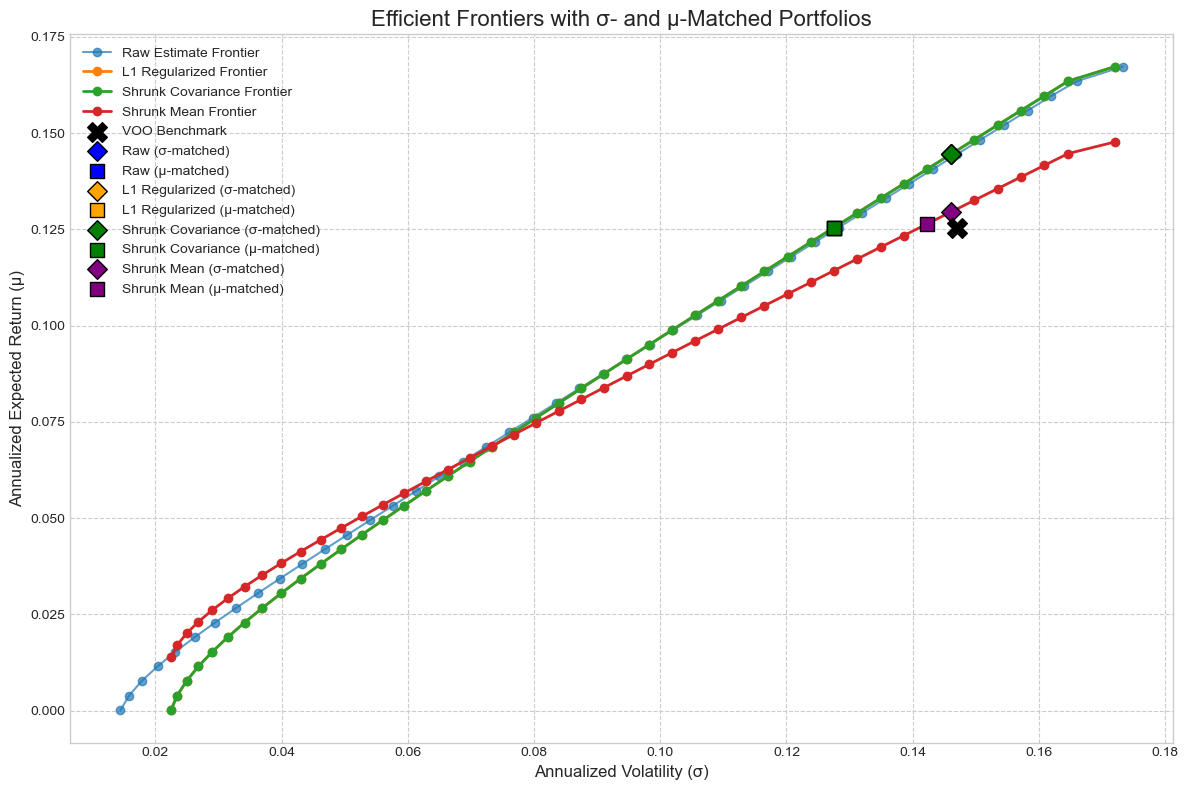

In [110]:
plt.figure(figsize=(12, 8))
plt.plot(ef_raw["sigma"], ef_raw["mu"], "o-", label="Raw Estimate Frontier", alpha=0.7)
plt.plot(ef_reg_l1["sigma"], ef_reg_l1["mu"], "o-", label="L1 Regularized Frontier", lw=2)
plt.plot(
    ef_shrunk["sigma"], ef_shrunk["mu"], "o-", label="Shrunk Covariance Frontier", lw=2
)
plt.plot(
    ef_shrunk_mean["sigma"], ef_shrunk_mean["mu"], "o-", label="Shrunk Mean Frontier", lw=2
)
# VOO benchmark
plt.scatter([voo_sigma_annual], [voo_mu_annual], color="black", marker="X", s=200, label="VOO Benchmark", zorder=5)

# Define portfolio styles
portfolios = [
    ("Raw", w_sigma_raw, w_mu_raw, annual_mu_sample, "blue"),
    ("L1 Regularized", w_sigma_reg_l1, w_mu_reg_l1, annual_mu_sample, "orange"),
    ("Shrunk Covariance", w_sigma_shrunk, w_mu_shrunk, annual_mu_sample, "green"),
    ("Shrunk Mean", w_sigma_shrunk_mean, w_mu_shrunk_mean, annual_mu_shrunk_partial, "purple"),
]

# Plot sigma- and mu-matched portfolios
for label, w_sigma, w_mu, mu_vec, color in portfolios:
    if w_sigma is not None:
        mu = w_sigma @ mu_vec
        sigma = np.sqrt(w_sigma @ annual_cov_shrunk @ w_sigma)
        plt.scatter(sigma, mu, marker="D", color=color, edgecolor="black", s=100, label=f"{label} (σ-matched)", zorder=4)

    if w_mu is not None:
        mu = w_mu @ mu_vec
        sigma = np.sqrt(w_mu @ annual_cov_shrunk @ w_mu)
        plt.scatter(sigma, mu, marker="s", color=color, edgecolor="black", s=100, label=f"{label} (μ-matched)", zorder=4)

# Plot settings
plt.title("Efficient Frontiers with σ- and μ-Matched Portfolios", fontsize=16)
plt.xlabel("Annualized Volatility (σ)", fontsize=12)
plt.ylabel("Annualized Expected Return (μ)", fontsize=12)
plt.grid(True, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

The clearest results is that basically all efficient frontiers suggest to put almost 90% of my portfolio weight into Growth ETFs and the rest into the short-term treasury ETF to match VOO's volatility, and to match VOO's expected return to invest 3/4 into Growth ETFs and the rest into short term treasury.  This does make economic sense: short-term treasuries have low return, but also low volatility, while the Russel 1000 Growth ETFs has one of the highest returns in the sample, with also one of the highest volatility.  The short-term treasury ETF is also not very much correlated with other ETFs, so some combination of a Growth ETFs with high return/high volatility and a largely uncorrelated low return/low volatility treasury ETFs maximized the diversification potential while still matching VOO's return or risk.

Graphically, we see that all optimization variants perform quite similar, except for the mean-shrinkage method.  Ledoit-Wolf barely changes the covariance matrix, so it virtually delivers the same results as using the sample covariance.  Without regularization, only two ETFs are selected anyways, so we don't have an issue with many small weights.  The L1 regularization only penalizes the large weight on the Russel 1000 Growth ETFs and leads to the addition of a another Growth ETF instead, which overall doesn't change much as the Mega Cap Growth ETF has a similar risk-return profile as the Russel 1000 Growth ETF.

Mean shrinkage leads to generally inferior frontier estimates and perform worse than no shrinkage at all.  Since we have 120 monthly return estimates per ETF, the estimates for the mean should be quite reliable with such a large sample, so shrinkage might not be needed in the first place.  Thus, I will not consider mean-shrinkage further for now.  In later iteration, we might need to come back to mean-shrinkage if the out-of-sample performance for the portfolio optimization without is terrible.

Here is a nice little dashboard that allows to select points along the efficient frontier and calculated the optimal weights for that point.  As expected, only the weighting between the short term treasury and Growth ETF change, the more return/risk I am willing to accept, the more weight goes into the Growth ETF and vice versa.

In [111]:
sigmas   = np.array(ef_raw["sigma"])
mus      = np.array(ef_raw["mu"])
weights  = np.array(ef_raw["weights"])          # (n_points, n_assets)
symbols  = etf_symbols                          # ticker list
name_map = etf_name_map                         # dict ticker → long name

fig = go.FigureWidget()
fig.layout.hovermode = "closest"
fig.layout.clickmode = "event+select"

fig.add_scatter(x=sigmas, y=mus, mode="lines",
                line=dict(color="lightgray"), hoverinfo="skip", showlegend=False)

fig.add_scatter(
    x=sigmas,
    y=mus,
    mode="markers",
    marker=dict(size=10, color="black"),
    name="Raw Frontier",
    hovertemplate="σ: %{x:.2%}<br>μ: %{y:.2%}<br>(click to see top weights)<extra></extra>",
)

fig.update_layout(
    title="Efficient Frontier (Raw Estimates)",
    xaxis_title="Volatility (σ)",
    yaxis_title="Expected Return (μ)",
    height=480,
)

out = HTML()

def format_html(idx: int) -> str:
    """Return HTML string listing the three largest weights."""
    w = weights[idx]
    top_idx = np.argsort(w)[-3:][::-1]
    
    rows = []
    for i in top_idx:
        if w[i] > 0.001:  # ≥ 0.1 %
            sym  = symbols[i]
            name = name_map.get(sym, "Unknown")
            rows.append(
                f"<li><b>{sym}</b> <span style='color:#666'>({name})</span>"
                f"<span style='float:right'>{w[i]:.2%}</span></li>"
            )
    
    html = (
        f"<div style='font-family:Arial, sans-serif; font-size:14px;"
        f"line-height:1.4; max-width:420px;'>"
        f"<h4 style='margin:4px 0 8px 0; font-size:15px;'>"
        f"Top 3 ETFs – Frontier Point {idx+1}</h4>"
        f"<ul style='list-style:none; padding-left:0; margin:0;'>"
        + "\n".join(rows) +
        "</ul></div>"
    )
    return html

def show_top_three(idx: int):
    out.value = format_html(idx)

def handle_click(trace, points, selector):
    if points.point_inds:
        show_top_three(points.point_inds[0])

fig.data[1].on_click(handle_click)

display(VBox([fig, out]))


    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'lightgray'},…

### 4. Advanced Static Models & Robustness Checks

In this section, we will implement more advance portfolio optimization model and robustness checks

* **Resampled Efficient Frontier** 
* **Rolling Estimation**
* **Black–Litterman** 
* **Risk Parity** 
* **Hierarchical Risk Parity** 
* **DCC‑GARCH** 

#### Resampling observations - Boostrapping

Bootstrapped (resampled) tackles estimation risk by repeatedly drawing bootstrap samples of the historical return matrix, estimate the efficient frontier for each sample, and averaging the resulting weight vectors.  This Monte-Carlo overlay delivers two key benefits: robustness, because it dampens the impact of noisy single-sample estimates of $\mu$ and $\Sigma$, and diversification, because extreme corner solutions are naturally pulled toward the centre.  Given our ETF universe—only a decade of monthly data spread across many assets—resampling provides a pragmatic hedge against estimation error without forcing Bayesian prior. The trade-off is extra compute time and the risk of diluting genuine alpha if the true optimum is highly concentrated.  I am less worried about missing the optimum, but the computational burden leads me to only estimate 30 points for each efficient frontier.  For the optimal portfolio, I average across the bootstrapped optimal portfolios that match VOO's volatility. 

In [112]:
# Bootstrapping  addresses "estimation error" by creating many new return
# datasets via bootstrapping. The final portfolio is the average of all optimal
# portfolios found, leading to a more diversified and stable allocation.
print(f"Running Resampled Frontier with {RESAMPLE_ITERATIONS} iterations...")
n_obs, n_assets = returns_monthly.shape
resampled_weights_list = []

for i in range(RESAMPLE_ITERATIONS):
    if (i + 1) % 25 == 0:
        print(f"  Resample iteration {i + 1}/{RESAMPLE_ITERATIONS}...")

    # Create a bootstrap sample of the monthly returns
    boot_indices = np.random.choice(n_obs, size=n_obs, replace=True)
    returns_boot = returns_monthly.iloc[boot_indices]

    # Recalculate parameters for the bootstrap sample
    mu_boot = (returns_boot.mean().values * 12) - expense_vector
    try:
        # Use shrunk covariance for better stability in each resampled data set
        cov_boot = LedoitWolf().fit(returns_boot.values).covariance_ * 12
        # Generate frontier and select the risk-matched portfolio
        ef_boot = efficient_frontier(cov_boot, mu_boot, n_points=30)
        _, w_boot = select_portfolio(ef_boot, "sigma", voo_sigma_annual)
        if w_boot is not None:
            resampled_weights_list.append(w_boot)
    except (ValueError, np.linalg.LinAlgError):
        # Skip iteration if the solver or covariance estimation fails
        continue

# The final resampled portfolio is the average of weights from all iterations
if resampled_weights_list:
    w_resampled = np.mean(resampled_weights_list, axis=0)
    w_resampled /= w_resampled.sum()           # <-- ensures Σw = 1
    
    print("\nTop 3 ETFs for Resampled Portfolio:")
    top_indices = np.argsort(w_resampled)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {w_resampled[i]:.2%}")
else:
    w_resampled = None
    print("\nCould not generate a resampled portfolio.")

Running Resampled Frontier with 100 iterations...
  Resample iteration 25/100...
  Resample iteration 50/100...
  Resample iteration 75/100...
  Resample iteration 100/100...

Top 3 ETFs for Resampled Portfolio:
  VONG (Russell 1000 Growth ETF): 43.51%
  MGK (Mega Cap Growth ETF): 19.83%
  VIG (Dividend Appreciation ETF): 5.90%


Across the bootstrapped optimal portfolios, we actually get a pretty similar results as for the static optimization: we should invest most of our assets into growth ETFs and some into treasury ETFs. 

#### Rolling estimations

Next, we can check how the efficient frontier estimates change over time.  Ideally, the optimal portfolios are not very sensitive over time, so we don't have to frequently re-balance. 

This rolling-window exercise re-estimates the mean–variance optimizer every month using the most recent 60 months of data and select in for each window the optimal portfolio that matches VOO's volatility.  Plotting the time-series of the top-3 ETFs reveals how sensitive the strategy is to new information: a stable profile indicates robustness and low turnover, while sharp oscillations indicate that the efficient frontier is quite sensitive to which historic data go into the model and for what period it is estimated.  

For this mode, since we use fewer observations for estimating the covariance matrix, Ledoit-Wolf covariance helps reduce the resulting sampling noise.  I still use the rolling sample mean for optimization as the shrinkage results for the overall sample performed quite poorly.

Let's also print the top weights for the optimal portfolio and how they are moving over time.

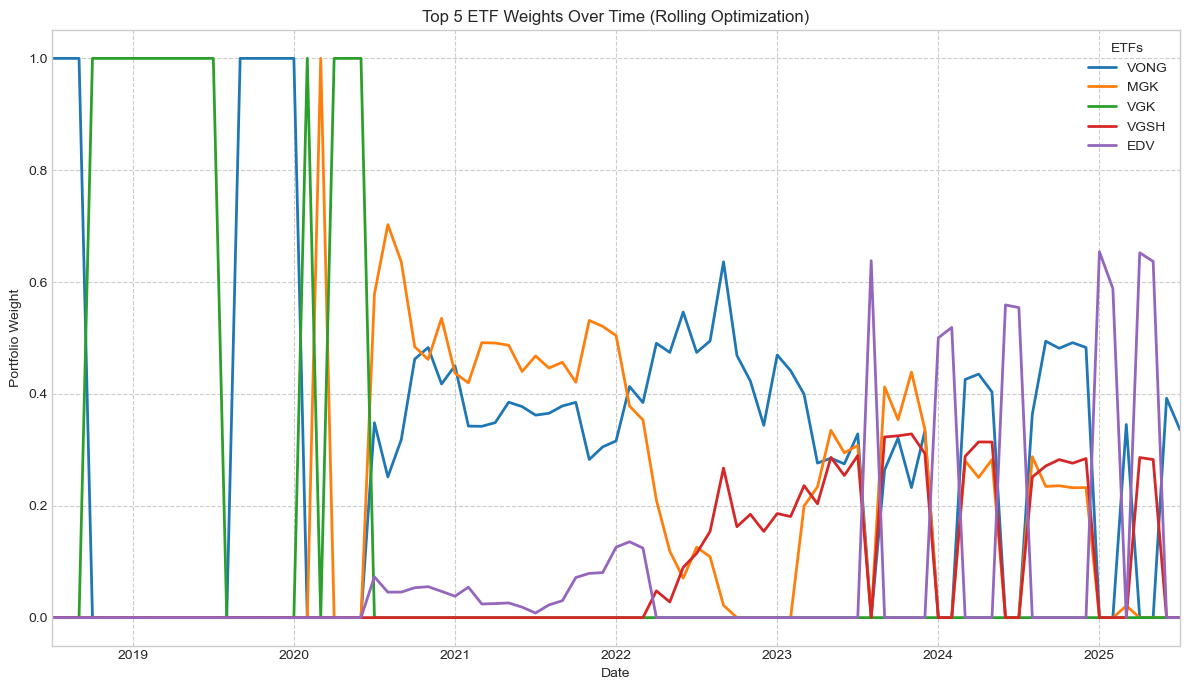

In [113]:
# This analysis shows how the optimal allocation would have changed over time,
# providing insight into the strategy's stability.
rolling_dates = returns_monthly.index[ROLLING_WINDOW_MONTHS:]
rolling_weights_list = []

for date in rolling_dates:
    # Create a data window of the last N months
    window_data = returns_monthly.loc[:date].iloc[-ROLLING_WINDOW_MONTHS:]
    # Estimate parameters on the window
    mu_roll = (window_data.mean().values * 12) - expense_vector
    cov_roll = LedoitWolf().fit(window_data.values).covariance_ * 12
    try:
        # Find the optimal (risk-matched) portfolio for this period
        ef_roll = efficient_frontier(cov_roll, mu_roll, n_points=30)
        _, w_roll = select_portfolio(ef_roll, "sigma", voo_sigma_annual)
        if w_roll is not None:
            rolling_weights_list.append(pd.Series(w_roll, index=etf_symbols, name=date))
    except (ValueError, np.linalg.LinAlgError):
        continue

# Combine results and plot the weight changes for the most important assets
if rolling_weights_list:
    rolling_weights_df = pd.concat(rolling_weights_list, axis=1).T
    # Identify the top 5 ETFs by average weight over time
    top_etfs = rolling_weights_df.mean().sort_values(ascending=False).head(5).index
    rolling_weights_df[top_etfs].plot(
        figsize=(12, 7), title="Top 5 ETF Weights Over Time (Rolling Optimization)", lw=2
    )
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Date")
    plt.grid(True, linestyle="--")
    plt.legend(title="ETFs")
    plt.tight_layout()
    plt.show()

The results are quite sobering.  The weights move around quite a lot.  However, the broad strokes are similar to the static optimization as VONG, Russell 1000 Growth ETF, and MGK, the Mega Cap Growth ETF, are frequently the top weighted funds.  EDV, the extended duration treasury ETF, becomes more popular since mid 2023, which makes sense following the interest rate increase during that period.  

#### Black-Litterman

Black–Litterman is a popular Bayesian portfolio construction framework.   Black–Littermann begins with market-implied equilibrium returns (the “prior”) and then tilts them toward investor views, producing a posterior return vector that is both economically grounded and data-driven.  

In my implementation the prior is a shrunk blend of the sample mean and the grand mean, very similar to what we tried above.  It is a light-touch Bayesian shrinkage, and we can allow for even more flexibility by running grid search to find the best shrinkage parameter.  In terms of investor views, I want to impose no specific assumptions, like by how much a specific ETFs outperforms the rest, but rather an economically defensible approach: the ETFs excess returns are approximately equal to VOO’s.  This makes sense if VOO is close to the market portfolio, the the remaining ETFs should eventually perform about as good as the market in the long run.  Uncertainty in the prior (tau_prior) and in the views (omega_scale) is are hyper-parameters as well that we can tune through a grid search, just as with the shrinkage parameter.  The objective also here should make economic sense and I chose again the parameter combination that maximizes the Sharpe ratio. 

Useful sources: the [documentation of PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and Thomas Idzorek's [Step-by-Step Guide to the Black-Litterman Model](https://people.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf)

In the Black–Litterman framework we first update the prior (equilibrium) mean returns to the posterior mean, making this model Bayesian-like.

$$
\boldsymbol\mu_{\text{post}}
=
\Bigl[(\tau\Sigma)^{-1}+P^{\!\top}\Omega^{-1}P\Bigr]^{-1}
\Bigl[(\tau\Sigma)^{-1}\boldsymbol\pi + P^{\!\top}\Omega^{-1}\mathbf Q\Bigr]
$$

where

* $\boldsymbol\pi$ – prior (market-implied) mean vector.  In our case this is the sample mean return srhink to towards the grand mean.  The relevant shrinkage factor which determines how much weight is given to the grand mean is one of the hyperparameters that we need to tune.
* $\Sigma$ – asset-return covariance matrix.  Since we want to be robust here, we are using the Ledoit-Wolf shrunk covariance matrix.
* $\tau$ – scalar reflecting uncertainty in the prior.  We need to tune this hyperparameter.
* $P$ – matrix that selects assets involved in each investor view,
* $\mathbf Q$ – vector of view returns. This is combined with $P$ to represent the investor's views.
* $\Omega$ – diagonal matrix of view uncertainties (larger ⇒ softer views).  Also this paramter need sto be tuned.

Using these posterior returns, we choose portfolio weights $\mathbf w$ by solving the long-only mean–variance program

$$
\begin{aligned}
\min_{\mathbf w}\;&\tfrac12\,\mathbf w^{\!\top}\Sigma\,\mathbf w
-\boldsymbol\mu_{\text{post}}^{\!\top}\mathbf w \\
\text{s.t. }&\mathbf 1^{\!\top}\mathbf w = 1,\qquad
\mathbf w \ge 0
\end{aligned}
$$

The only thing to determine is the view we want to model to incorporate.  It should make economic sense, so I will assume that in the long run, all return are round about the same as the market portfolio's return, which we can represent through the returns of VOO.  This is a bit restrictive as it imposes return expectations on all assets, but it is in the spirit of Bayesian shrinkage towards the grand mean, and $\tau$ can be tuned to put less certainty on the prior. 

We can implement this assumption using the $P$ matrix and the $Q$ vector:

$$
P_{k,j}=1,\; P_{k,\text{VOO}}=-1,
\quad
Q_k = 0
$$
meaning *“ETF $j$ will perform about the same as VOO.”*

In [114]:
# The Black-Litterman model starts with market-implied equilibrium returns and
# then tilts them based on an investor's specific views, creating a blended,
# more intuitive set of expected returns for optimization.
def run_black_litterman(
    shrink_factor=0.3, tau_prior=0.20, omega_scale=0.02, print_summary=True
):
    """
    Performs Black-Litterman optimization with tunable hyperparameters.

    Args:
        shrink_factor (float): Weight on the sample mean in the prior;
                               1-shrink_factor goes to the grand mean.
        tau_prior (float): Prior uncertainty scale. Larger => prior is less certain.
        omega_scale (float): Diagonal element for Omega matrix (view uncertainty).
                             Larger => views are softer/less binding.
        print_summary (bool): If True, prints portfolio weights and top holdings.

    Returns:
        tuple: (weights_bl, mu_posterior)
               - weights_bl (np.ndarray | None): Optimal long-only weights.
               - mu_posterior (np.ndarray | None): Posterior expected-return vector.
    """
    n_assets = len(etf_symbols)
    # 1. Prior mean (pi) - a blend of sample mean and grand mean
    grand_mean = annual_mu_sample.mean()
    prior_mean = shrink_factor * annual_mu_sample + (1 - shrink_factor) * grand_mean

    try:
        # 2. Investor view: each ETF's return is approximately equal to VOO's return
        idx_voo = etf_symbols.index("VOO")
        other_symbols = [sym for sym in etf_symbols if sym != "VOO"]
        # P matrix selects assets involved in the view
        P = np.zeros((len(other_symbols), n_assets))
        for k, sym in enumerate(other_symbols):
            P[k, returns_monthly.columns.get_loc(sym)] = 1  # +1 on ETF
            P[k, idx_voo] = -1  # -1 on VOO
        # Q vector contains the expected outperformance ("approximately 0" in this case)
        Q = np.zeros(len(other_symbols))

        # 3. View-uncertainty (Omega)
        Omega = np.diag(np.full(len(Q), omega_scale))

        # 4. Posterior mean calculation (core Black-Litterman formula)
        inv_cov_prior = np.linalg.inv(tau_prior * annual_cov_shrunk)
        inv_Omega = np.linalg.inv(Omega)
        middle = np.linalg.inv(inv_cov_prior + P.T @ inv_Omega @ P)
        mu_posterior = middle @ (inv_cov_prior @ prior_mean + P.T @ inv_Omega @ Q)

        # 5. Optimize portfolio (mean-variance) using the posterior returns
        P_qp = opt.matrix(annual_cov_shrunk)
        q_qp = opt.matrix(-mu_posterior)
        G_qp = opt.matrix(-np.eye(n_assets))  # w >= 0
        h_qp = opt.matrix(np.zeros(n_assets))
        A_qp = opt.matrix(np.ones((1, n_assets)))  # sum(w) = 1
        b_qp = opt.matrix(1.0)

        sol = opt.solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
        if sol["status"] != "optimal":
            raise RuntimeError(f"CVXOPT failed: {sol['status']}")

        weights_bl = np.array(sol["x"]).ravel()
        weights_bl[weights_bl < 1e-7] = 0
        weights_bl /= weights_bl.sum()

        if print_summary:
            print(
                f"\n--- Black-Litterman (shrink={shrink_factor}, "
                f"tau={tau_prior}, omega={omega_scale}) ---"
            )
            print("Weights > 1%:")
            for i, w in enumerate(weights_bl):
                if w > 0.01:
                    print(f"  {etf_symbols[i]}: {w:.1%}")
            top_idx = weights_bl.argsort()[-3:][::-1]
            print("\nTop 3 ETFs:")
            for i in top_idx:
                sym = etf_symbols[i]
                name = etf_name_map.get(sym, "Unknown")
                print(f"  {sym} ({name}): {weights_bl[i]:.2%}")

        return weights_bl, mu_posterior

    except (ValueError, IndexError, np.linalg.LinAlgError) as e:
        if print_summary:
            print(f"Black-Litterman failed: could not locate VOO or matrix error. {e}")
        return None, None

There are several hyperparemters that we need to decied upon, specifically the shrinkage parameter of expected returns towards the grand mean, the uncertainty about the prior, $\tau$, and the uncertainty about the of view-uncertainty, $\Omega$.  Let's again use grid search, and find the hyperparemter setting that maximizes the sharp ratio of the optimal portfolio.

In [115]:
print("\n--- Tuning Black-Litterman Hyperparameters ---")
shrink_grid = [0.2, 0.4, 0.6, 0.8]
tau_grid = [0.05, 0.10, 0.20, 0.30, 0.40]
omega_grid = [0.005, 0.01, 0.02, 0.05]
records = []

for shrink in shrink_grid:
    for tau in tau_grid:
        for omega in omega_grid:
            w, mu_post = run_black_litterman(shrink, tau, omega, print_summary=False)
            if w is None:
                continue
            exp_ret = float(w @ mu_post)
            vol = float(np.sqrt(w @ annual_cov_shrunk @ w))
            sharpe = exp_ret / vol if vol else np.nan
            records.append(
                {
                    "shrink": shrink,
                    "tau": tau,
                    "omega": omega,
                    "exp_return": exp_ret,
                    "vol": vol,
                    "sharpe": sharpe,
                    "top_weight": w.max(),
                    "assets_>1pct": (w > 0.01).sum(),
                }
            )

tune_df = pd.DataFrame(records).sort_values("sharpe", ascending=False)
print("Tuning results (top 10 by in-sample Sharpe):")
print(tune_df.head(10))
# ------------------------------------------------------------------------------

# Rerun with the best parameters found and print a summary
print("\n--- Final Black-Litterman Portfolio (using best tuned parameters) ---")
best_row = tune_df.iloc[0]
w_bl_opt, mu_bl = run_black_litterman(
    best_row["shrink"], best_row["tau"], best_row["omega"], print_summary=True
)


--- Tuning Black-Litterman Hyperparameters ---
Tuning results (top 10 by in-sample Sharpe):
    shrink   tau  omega  exp_return   vol  sharpe  top_weight  assets_>1pct
16   0.200 0.400  0.005       0.056 0.036   1.571       0.342             4
12   0.200 0.300  0.005       0.057 0.038   1.469       0.310             4
17   0.200 0.400  0.010       0.057 0.043   1.311       0.287             4
8    0.200 0.200  0.005       0.057 0.043   1.311       0.287             4
13   0.200 0.300  0.010       0.057 0.048   1.193       0.292             4
18   0.200 0.400  0.020       0.058 0.056   1.032       0.305             4
4    0.200 0.100  0.005       0.058 0.056   1.032       0.305             4
9    0.200 0.200  0.010       0.058 0.056   1.032       0.305             4
14   0.200 0.300  0.020       0.059 0.064   0.926       0.358             4
0    0.200 0.050  0.005       0.061 0.076   0.796       0.444             4

--- Final Black-Litterman Portfolio (using best tuned parameters) ---


These results look quite different: while we again have a combination of treasury ETFs and Growth ETFs, Black-Litterman clearly prefers to put much weight into treasuries.  This makes sense as we shrink the means of ETFs towards the market return, the posterior returns are quite similar and Black-Litterman only cares about minimizing portfolio volatility, exactly what treasury ETFs provide.  

Btw, enforcing for this setting minimum returns, like optimal portfolios should deliver at least 80% of VOO's expected return, frequently leads to the algorithm not converging.  Mean shrinkage might make it infeasible to reach higher expected returns. 

#### Risk Parity

Risk Parity builds a portfolio in which each ETF contributes the same percentage to total volatility, intentionally ignoring expected returns.  This “equal-risk” stance delivers two practical benefits: (i) diversification that is easy to explain to non-quants: no single asset can dominate portfolio risk—and (ii) robustness to return-forecast error.  The trade-offs is that in can overweight low-volatility assets and under-deliver on absolute return.  The code implements the idea by (1) computing marginal risk contributions, (2) minimising the squared deviation of each asset’s risk share from the equal-split target, and (3) enforcing long-only, fully­-invested weights. 

Useful sources: [Daniel Palomar's presentation](https://palomar.home.ece.ust.hk/ELEC5470_lectures/slides_risk_parity_portfolio.pdf) on pp. 31-32.


In risk-parity portfolios we ignore expected returns and aim for every asset to shoulder the same share of total volatility.
Given weights $\mathbf w$ and covariance matrix $\Sigma$, we can define the following:

* **Portfolio volatility**

  $$
  \sigma_p=\sqrt{\mathbf w^{\!\top}\Sigma\,\mathbf w}
  $$

* **Marginal risk contribution (MRC)** of asset $i$

  $$
  \text{MRC}_i=\frac{(\Sigma\,\mathbf w)_i}{\sigma_p}
  $$

* **Total (percentage) risk contribution**

  $$
  \text{RC}_i=\;w_i\,\text{MRC}_i
  $$

Risk parity asks for

$$
\text{RC}_1=\text{RC}_2=\dots=\text{RC}_n=\frac{\sigma_p}{n}.
$$

A convenient way to reach this is to choose $\mathbf w$ that solves

$$
\begin{aligned}
\min_{\mathbf w}\;&\sum_{i=1}^{n}\bigl(\text{RC}_i-\sigma_p/n\bigr)^2 \\[4pt]
\text{s.t. }&\sum_{i=1}^{n} w_i = 1,\qquad w_i \ge 0.
\end{aligned}
$$

The SLSQP routine in the code numerically searches for these weights, starting from an equal-weight guess and iteratively shrinking the variance of the risk-contribution vector until all assets contribute the same fraction of total portfolio risk.


In [116]:
# Risk Parity aims to construct a portfolio where each asset contributes equally
# to the total portfolio risk. It ignores expected returns.
def portfolio_volatility(weights, cov_matrix):
    """Calculates the annualized volatility of a portfolio."""
    return np.sqrt(weights.T @ cov_matrix @ weights)


def risk_contributions(weights, cov_matrix):
    """Calculates each asset's percentage contribution to total portfolio risk."""
    port_vol = portfolio_volatility(weights, cov_matrix)
    if port_vol == 0:
        return np.zeros_like(weights)
    # Marginal Risk Contribution (MRC) = (Cov * w) / sigma_p
    mrc = (cov_matrix @ weights) / port_vol
    # Total Risk Contribution = w_i * MRC_i
    return weights * mrc


def risk_parity_objective(weights, cov_matrix):
    """
    Objective function for the optimizer. It seeks to minimize the
    variance of risk contributions across all assets, forcing them to be equal.
    """
    total_risk_contribs = risk_contributions(weights, cov_matrix)
    # Target is an equal contribution from each asset
    target_contribution = total_risk_contribs.sum() / len(weights)
    # Minimize the squared differences from this target
    return np.sum((total_risk_contribs - target_contribution) ** 2)


# Solve the optimization problem
initial_weights = np.ones(n_assets) / n_assets
bounds = tuple((0.0, 1.0) for _ in range(n_assets))
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}

result = minimize(
    fun=risk_parity_objective,
    x0=initial_weights,
    args=(annual_cov_sample,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    options={"disp": False},
)

rp_weights = result.x if result.success else None
if rp_weights is not None:
    print("Optimal Risk Parity Portfolio (weights > 1%):")
    for i, weight in enumerate(rp_weights):
        if weight > 0.01:
            print(f"  - {etf_symbols[i]}: {weight:.1%}")
    print("\nTop 3 ETFs for Risk Parity Portfolio:")
    top_indices = np.argsort(rp_weights)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {rp_weights[i]:.2%}")
else:
    print("Risk Parity optimization failed.")

Optimal Risk Parity Portfolio (weights > 1%):
  - VIG: 1.7%
  - VWOB: 3.2%
  - EDV: 3.9%
  - VXF: 1.1%
  - VEU: 1.5%
  - VSS: 1.2%
  - VEA: 1.4%
  - VWO: 1.8%
  - VGK: 1.2%
  - VPL: 1.7%
  - VUG: 1.1%
  - VYM: 1.7%
  - BIV: 3.5%
  - VCIT: 3.5%
  - VGIT: 3.1%
  - VV: 1.3%
  - BLV: 3.6%
  - VCLT: 3.1%
  - VGLT: 3.7%
  - MGC: 1.3%
  - MGK: 1.1%
  - MGV: 1.7%
  - VO: 1.0%
  - VOE: 1.1%
  - VMBS: 3.4%
  - VONE: 1.2%
  - VONG: 1.2%
  - VONV: 1.3%
  - VTWO: 1.1%
  - VTWG: 1.1%
  - VTWV: 1.1%
  - VTHR: 1.2%
  - VOO: 1.3%
  - VOOG: 1.2%
  - VOOV: 1.4%
  - IVOO: 1.0%
  - IVOG: 1.0%
  - IVOV: 1.1%
  - VIOO: 1.1%
  - VIOG: 1.1%
  - VIOV: 1.2%
  - BSV: 3.0%
  - VCSH: 3.2%
  - VTIP: 3.1%
  - VGSH: 2.8%
  - VB: 1.1%
  - VBK: 1.0%
  - VBR: 1.1%
  - BND: 3.4%
  - BNDX: 3.3%
  - VXUS: 1.5%
  - VTI: 1.2%
  - VT: 1.3%
  - VTV: 1.6%

Top 3 ETFs for Risk Parity Portfolio:
  EDV (Extended Duration Treasury ETF): 3.85%
  VGLT (Long-Term Treasury ETF): 3.71%
  BLV (Long-Term Bond ETF): 3.58%


As risk parity tries to distribute the risk across portfolio assets, we get many small weights across a lot of ETFs.  But it also seems that the highest weights go again to the low-volatility treasury ETFs, not great for expected returns.  We could implement something like L1 regularization also here to penalize small weights, but it likely would not lead to less weight on treasury ETFs, they are low-volatility and will have large weights.

#### Hierarchical Risk Parity (HRP)

Hierarchical Risk Parity (HRP) is a machine-learning-inspired take on risk parity portfolio optimization.  It follows a three-step, graph-theoretic workflow: (1) it converts the correlation matrix to a distance matrix and performs hierarchical clustering to group strongly related ETFs; (2) it re-orders (quasi-diagonalises) the covariance matrix so that similar assets sit next to each other; and (3) it applies a recursive bisection algorithm that splits the ordered list in halves and allocates capital inversely to each sub-cluster’s variance.  The result is a portfolio that automatically diversifies across statistically distinct clusters without estimating expected returns.  

One big advantage of this method is that is allows to a visual representation of the clusters via a dendrogram.  The disadvantage of the method is that is also will weight heavily on low volatility portfolios in clusters with low volatility.  What we can do, though, is to leverage this to our advantage and improve on the two-asset allocation we found through the static optimization.  We can take the portfolio that we found that matches VOO's volatility from the static optimization above (which mostly consists of Growth ETFs) and blend it with the optimal portfolio from HRP, which will have lower volatility and lower expected return, to match VOO's expected return.  Basically, we can find with this method a better low-volatility portfolio than the treasury ETF we found from the static portfolio optimization.

Useful sources: [Hudson and Thames introduction to HRP article](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/) and the original paper by Marcos Lopez de Prado, *Building Diversified Portfolios that Outperform Out-of-Sample*; with the [working paper version on SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678).

The logic for HRP is based on hierarchical clusters to arrange the assets into clusters based on their correlation and then walk through the tree to assign portfolio weight inversely to each sub-cluster's variance.

1. Convert correlations to “distances”

   For any pair of assets $i,j$ with correlation $\rho_{ij}$

   $$
   d_{ij}= \sqrt{\tfrac{1}{2}\,\bigl(1-\rho_{ij}\bigr)}
   $$

   Smaller $d_{ij}$ means the assets move together more closely.

2. Build the hierarchy
   Apply agglomerative clustering (e.g. *single-linkage*) on the distance matrix $D=(d_{ij})$ to obtain a dendrogram.  What this does is iterratively merging pairs of assets and then clusters based on the minimum distance (in this case, the minimum pair-wise distance for all elements in each cluster).  In the last step, we end up with one cluster containing all assets.

   The dendrogram gives an ordering (seriation) that groups similar assets next to one another, which we can use to rearrange the covariance matrix.

   This is a straightforward approach which we can complete with Pyhton librariers relatively easily.  The original paper provides a step-by-step algorithm to identify cluster and quasi-diagonalize the matrix.  It is not essential that we follow here the same approach as the paper, we only need to find a way to seriate the covariance matrix and remain aware of subtle difference, such as specific tie-breaking rules.

3. Cluster-level variance

   Move 'backward' through the created tree, starting with the single cluster that contains all assets and moving until we reached the individual asset in the leafs.

   For a cluster $C$ with covariance sub-matrix $\Sigma_C$ and asset set $k\in C$:

   *First*, use inverse-variance weights *within* the cluster

   $$
   \tilde w_k \propto \frac{1}{\sigma_k^{2}}, 
   \quad
   w_k=\frac{\tilde w_k}{\sum_{j\in C}\tilde w_j}.
   $$

   *Then*, compute the cluster’s variance

   $$
   \sigma_C^{2}= \mathbf w_C^{\!\top}\,\Sigma_C\,\mathbf w_C.
   $$

3. Recursive bisection allocation
   
   Move 'backward' through the created tree, starting at the root cluster with that contains all assets and moving until we reached the individual asset in the leaves.  Split each cluster into a *left* $C_L$ and *right* $C_R$ halves.  Allocate total weight between the two halves inversely to their variances:

   $$
   \alpha = 1-\frac{\sigma_{C_L}^{2}}{\sigma_{C_L}^{2}+\sigma_{C_R}^{2}}, 
   \qquad
   \begin{cases}
     w_{C_L} \gets w_{C_L}\,\alpha,\\[4pt]
     w_{C_R} \gets w_{C_R}\,(1-\alpha).
   \end{cases}
   $$

   The within-cluster variances as follows, use the inverse-variance weights of the assets within the cluster to calculate cluster variances.  Specifically, for a cluster $C$ with covariance sub-matrix $\Sigma_C$ and asset set $k\in C$, calculate the variance as 

   $$
   \sigma_C^{2}= \mathbf w_C^{\!\top}\,\Sigma_C\,\mathbf w_C.
   $$

   with  
   
   $$
   \tilde w_k = \frac{1}{\sigma_k^{2}}, 
   \quad
   w_k=\frac{\tilde w_k}{\sum_{j\in C}\tilde w_j}.
   $$

   Continue the bisection until every leaf (single asset) receives its final weight.

The final weight vector $\mathbf w$ is long-only, sums to one, and tends to equalise risk across clusters without solving a quadratic program.


Optimal HRP Portfolio (weights > 1%):
  - BIV: 1.3%
  - VCIT: 1.7%
  - VGIT: 2.4%
  - VMBS: 2.6%
  - BSV: 10.1%
  - VCSH: 11.1%
  - VTIP: 10.3%
  - VGSH: 47.9%
  - BND: 1.7%
  - BNDX: 4.5%

Top 3 ETFs for HRP Portfolio:
  VGSH (Short-Term Treasury ETF): 47.90%
  VCSH (Short-Term Corporate Bond ETF): 11.10%
  VTIP (Short-Term Inflation-Protected Securities ETF): 10.32%


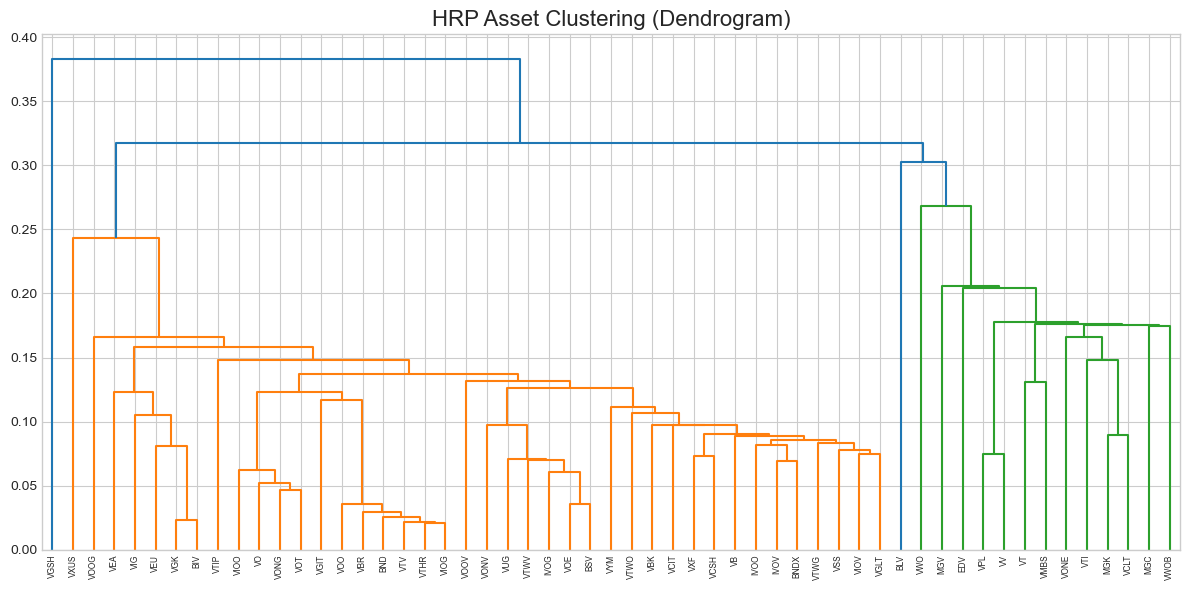

In [117]:
# HRP uses graph theory and machine learning to build a diversified portfolio.
# It clusters assets, reorders the covariance matrix, and allocates weights recursively.
def correlation_to_distance(corr_matrix):
    """Converts a correlation matrix to a distance matrix."""
    return np.sqrt(0.5 * (1 - corr_matrix))


def get_cluster_variance(cov_matrix, cluster_indices):
    """Calculates the variance of a cluster of assets."""
    sub_cov = cov_matrix[np.ix_(cluster_indices, cluster_indices)]
    # Inverse variance weights within the cluster
    inv_var_weights = 1.0 / np.diag(sub_cov)
    inv_var_weights /= inv_var_weights.sum()
    return inv_var_weights.T @ sub_cov @ inv_var_weights


def recursive_bisection(cov_matrix, sorted_indices):
    """Recursively splits weights between asset clusters."""
    weights = pd.Series(1.0, index=sorted_indices)
    clusters = [sorted_indices]
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) <= 1:
            continue
        # Bisect the cluster
        split_point = len(cluster) // 2
        left_cluster, right_cluster = cluster[:split_point], cluster[split_point:]
        # Calculate variance for each sub-cluster
        var_left = get_cluster_variance(cov_matrix, left_cluster)
        var_right = get_cluster_variance(cov_matrix, right_cluster)
        # Allocate weights inversely to cluster variance
        alpha = 1.0 - var_left / (var_left + var_right)
        weights[left_cluster] *= alpha
        weights[right_cluster] *= 1.0 - alpha
        # Add the new sub-clusters to the list to be processed
        clusters.extend([left_cluster, right_cluster])
    return weights.sort_index()


# Step 1: Hierarchical Clustering
corr_matrix = returns_monthly.corr()
dist_matrix = correlation_to_distance(corr_matrix)
linkage_matrix = linkage(squareform(dist_matrix), method="single")

# Step 2: Quasi-Diagonalization (Seriation)
# This reorders assets to place similar assets next to each other.
sorted_indices = leaves_list(linkage_matrix)
sorted_tickers = [etf_symbols[i] for i in sorted_indices]

# Step 3: Recursive Bisection
sorted_cov = returns_monthly[sorted_tickers].cov().values * 12
hrp_weights_sorted = recursive_bisection(sorted_cov, np.arange(len(sorted_tickers)))

# Map weights back to the original order of etf_symbols
hrp_weights = np.zeros(n_assets)
for i, ticker in enumerate(sorted_tickers):
    original_idx = etf_symbols.index(ticker)
    hrp_weights[original_idx] = hrp_weights_sorted.iloc[i]

print("Optimal HRP Portfolio (weights > 1%):")
for i, weight in enumerate(hrp_weights):
    if weight > 0.01:
        print(f"  - {etf_symbols[i]}: {weight:.1%}")

if hrp_weights is not None:
    print("\nTop 3 ETFs for HRP Portfolio:")
    top_indices = np.argsort(hrp_weights)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {hrp_weights[i]:.2%}")

# Optional: Visualize the asset hierarchy with a dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=sorted_tickers, leaf_rotation=90)
plt.title("HRP Asset Clustering (Dendrogram)", fontsize=16)
plt.tight_layout()
plt.show()

Hierarchical Risk Parity (HRP) tends to produce a minimum-variance portfolio, which is typically conservative and heavily tilted toward low-volatility assets.  If we aim to achieve higher expected returns, we need to consider blending this portfolio with higher-return alternatives. For instance, the mean-variance optimal portfolio often assigns substantial weight to high-return, high-volatility Growth ETFs, and matches VOO's volatility.  We can use the HRP-derived minimum-variance portfolio as a low-risk anchor and then blend it with a Growth ETF portfolio to reach a desired return level—such as matching VOO's return.

In [118]:
# Blend the HRP portfolio with the MVO portfolio (risk-matched to VOO)
# to create a new portfolio that meets VOO's expected return.
mu_hrp = hrp_weights @ annual_mu_sample
mu_mv = w_sigma_raw @ annual_mu_sample
# Calculate blending factor 'alpha'
alpha = np.clip((voo_mu_annual - mu_hrp) / (mu_mv - mu_hrp + 1e-12), 0, 1)
# Create blended weights
w_tilt = (1 - alpha) * hrp_weights + alpha * w_sigma_raw
w_tilt /= w_tilt.sum()
sigma_tilt = np.sqrt(w_tilt @ annual_cov_sample @ w_tilt)

print(f"\nBlended HRP-MVO portfolio: alpha = {alpha:.3f}")
print(f"  Expected mu   = {w_tilt @ annual_mu_sample:.2%} (VOO: {voo_mu_annual:.2%})")
print(f"  Volatility sigma = {sigma_tilt:.2%} (VOO: {voo_sigma_annual:.2%})")
print("\nTop 3 ETFs for Blended HRP-MVO Portfolio:")
top_indices = np.argsort(w_tilt)[-3:][::-1]
for i in top_indices:
    symbol = etf_symbols[i]
    name = etf_name_map.get(symbol, "Unknown")
    print(f"  {symbol} ({name}): {w_tilt[i]:.2%}")


Blended HRP-MVO portfolio: alpha = 0.866
  Expected mu   = 12.54% (VOO: 12.54%)
  Volatility sigma = 12.91% (VOO: 14.71%)

Top 3 ETFs for Blended HRP-MVO Portfolio:
  VONG (Russell 1000 Growth ETF): 76.93%
  VGSH (Short-Term Treasury ETF): 16.10%
  VCSH (Short-Term Corporate Bond ETF): 1.49%


As expected, the blended portfolio weighs heavily on the Russell 1000 Growth ETF, but now blends in, for example, the short-term corporate bonds ETFs as low-volatility component.

The dendrogram shows quite interesting risk clusters.  There are apparently two large clusters, with the right cluster including, for example, all the Mega Cap ETFs, Total Market Stock ETF, but also the extended duration treasury ETF.  Apparently, the closest ETFs to the Mega Cap Growth ETFs, MGK, in terms of volatility is VCLT, Long-Term Corporate Bond ETF, quite unexpected, and for the Russell 1000 Growth ETF, VONG, it is VOT, Mid-Cap Growth ETF, which is a bit less unexpected.

#### DCC-GARCH

Let's try to find optimal portfolios accounting for changing volatility and covariance over time.  Dynamic Conditional Correlation (DCC)-GARCH extends classic GARCH by allowing both volatilities and cross-asset correlations to evolve over time.  This method allows us to model and predict the covariance matrix in a more dynamic fashion than just looking at historic return.  This the estimation procedure is quite parameter heavy, we need a ideally a lot of observations.  For this, we switch to weekly ETF return.  We then can fit for each ETF the a univariate GARCH(1,1) and get standardized residuals (residuals divided by the volatility estimate) and conditional variance estimates.  Then, we can estimate a two-parameter DCC(1,1) model via quasi-maximum likelihood.  We can forecast the 1-step-ahead covariance matrix with this and feed it into a monthly mean–variance optimization, allowing for moving portfolio weights and changing correlation relations between assets across time.

Source are the original Engle paper, *Dynamic Conditional Correlation A Simple Class of Multivariate Generalized Autoregressive Conditional Heteroskedasticity Models*, an its [working paper version](https://pages.stern.nyu.edu/~rengle/dccfinal.pdf), [Qunxing Pan's *A Teaching Summary on the Estimation of DCC-type Models*](https://www.atlantis-press.com/article/125960938.pdf), and the website of [NYU's V-Lab](https://vlab.stern.nyu.edu/docs/correlation/GARCH-DCC).

The main approach I apply is first to estimate GARCH models for each asset ETF, after we verify there are ARCH-effect actually present in the data, and then fit the DCC part to produce the covariance structure for one period ahead.

1. Fit a standard GARCH(1, 1) to every return series $r_{i,t}$:

   $$
   r_{i,t} = \mu_i + \varepsilon_{i,t}, \qquad
   \varepsilon_{i,t} = \sigma_{i,t} z_{i,t}, \quad
   z_{i,t}\sim\text{i.i.d. }(0,1)
   $$

   $$
   \sigma_{i,t}^{2} = \omega_i + a_i\,\varepsilon_{i,t-1}^{2} + b_i\,\sigma_{i,t-1}^{2}.
   $$

   The standardised residuals are then $z_{i,t} = \varepsilon_{i,t}/\sigma_{i,t}$.

   This is comparatively easy, since Python has standard libraries to fit GARCH models.  However, we need to be aware that these models typically need a lot of observation to lead to stable estimates.  Thus, I'm using weekly observations instead of monthly.  Note also that I scale the weekly returns by a factor of 100, since this makes fitting the models easier.

2. Estimate the dynamic correlation structure, DCC(1, 1)

   Collect the vector of standardised residuals at date $t$ as
   $\mathbf z_t = (z_{1,t},\dots,z_{N,t})^\top$.
   
   Let $Q_t$ be the covariance of $\mathbf z_t$ and $\bar{Q}$ the unconditional covariance matrix.  Then, we can fit the following model via log-likelihood:

   $$
   Q_t
     \;=\;
     (1-\alpha-\beta)\,\bar{Q}
     +\alpha\,\mathbf z_{t-1}\mathbf z_{t-1}^\top
     +\beta\,Q_{t-1},
     \qquad 0<\alpha,\beta,\ \alpha+\beta<1.
   $$

   Finally, we convert $Q_t$ to the correlation matrix:

   $$
   R_t = \bigl(\operatorname{diag}Q_t\bigr)^{-1/2} Q_t \bigl(\operatorname{diag}Q_t\bigr)^{-1/2}.
   $$

   Note that for the quasi-log-likelihood minimization, we take the standardized residuals $\mathbf z_t$ as observed input from the individual GARCH models, thus we can drop them from the estimation; only $\alpha$ and $\beta$ are estimated. 

3. One-step-ahead forecast of the full covariance

   To get to the covariance matrix in $T+1$, we need two elements.  First, we can use the model for $Q_t$ we fitted above to estimate $Q_{T+1}$ buy just plugging in the last standardized residual vector and the unconditional covariance matrix and converting to the correlation matrix: R_{T+1} = \bigl(\operatorname{diag}Q_{T+1}\bigr)^{-1/2} Q_{T+1} \bigl(\operatorname{diag}Q_{T+1}\bigr)^{-1/2}.  

   Second, we can build the diagonal matrix $D_T$ using the last conditional variances from the univariate GARCH models,
   $\sigma_{i,T}^{2}$: $D_T = \operatorname{diag}(\sigma_{1,T},\dots,\sigma_{N,T})$.

   Then, we can get the estimated covariance matrix for the next period as:

   $$
   \Sigma_{T+1}
     \;=\;
     D_T\,R_{T+1}\,D_T.
   $$

   We could also use the individual GARCH models to first predict the one-step ahead variance of each ETF from the GARCH models, but since the covariance structure is much more important I just use the last available variance.

4. Portfolio optimisation with the forecasted covariance

   Feed $\Sigma_{T+1}$ (and, if desired, mean forecasts) into the Markowitz routine from above to pick weights that target a chosen risk level, i.e. match VOO’s volatility.  Note that we are doing all of this on weekly basis.  To get to monthly weights, I just take the portfolio weight from the last week of the month to define the weight for the next month.


Let's start implementing this by defining some function for the DCC estimation, fitting, and forecasting.

In [119]:
def _dcc_negloglik(params, std_resids):
    """Negative log-likelihood of a DCC(1,1) model given standardized residuals."""
    T, N = std_resids.shape
    alpha, beta = params
    Qbar = np.cov(std_resids.T)  # Unconditional correlation
    Qt = Qbar.copy()  # Initialize Qt_0
    loglik = 0.0
    for t in range(T):
        eps_t = std_resids[t][:, None]  # (N,1)
        Qt = (1 - alpha - beta) * Qbar + alpha * (eps_t @ eps_t.T) + beta * Qt
        diag_sqrt = np.sqrt(np.diag(Qt))
        diag_sqrt[diag_sqrt <= 1e-12] = 1e-12
        Rt = Qt / np.outer(diag_sqrt, diag_sqrt)
        inv_Rt = np.linalg.inv(Rt)
        logdet_Rt = np.log(np.linalg.det(Rt))
        loglik += logdet_Rt + eps_t.T @ inv_Rt @ eps_t
    return 0.5 * loglik.item()


def fit_dcc(std_resids, bounds=((1e-6, 1 - 1e-6),) * 2):
    """Estimates (alpha, beta) by QML; returns params and last Qt, Rt."""
    best_val, best_ab = np.inf, None
    grid = np.linspace(0.01, 0.15, 5)
    for a in grid:
        for b in grid:
            if a + b < 0.999:
                val = _dcc_negloglik((a, b), std_resids)
                if val < best_val:
                    best_val, best_ab = val, (a, b)
    res = minimize(
        _dcc_negloglik,
        x0=np.array(best_ab),
        args=(std_resids,),
        bounds=bounds,
        constraints={"type": "ineq", "fun": lambda x: 0.999 - (x[0] + x[1])},
    )
    alpha, beta = max(res.x[0], 0), max(res.x[1], 0)
    if alpha + beta >= 0.999:
        beta = 0.999 - alpha - 1e-6

    Qbar = np.cov(std_resids.T)
    Qt = Qbar.copy()
    for eps in std_resids:
        eps = eps[:, None]
        Qt = (1 - alpha - beta) * Qbar + alpha * (eps @ eps.T) + beta * Qt
    Rt = Qt / np.outer(np.sqrt(np.diag(Qt)), np.sqrt(np.diag(Qt)))
    return alpha, beta, Qt, Rt


def forecast_dcc_cov_1step(std_resids, cond_vars):
    """ Returns the 1-step-ahead covariance matrix using a DCC(1,1) model. """
    # Fit DCC and get last Q_T
    alpha, beta, Q_last, _ = fit_dcc(std_resids)

    # Unconditional correlation (Q_bar) and latest residual
    Q_bar   = np.cov(std_resids.T)
    eps_T   = std_resids[-1, :][:, None]        # column vector (N × 1)

    # ---- 1-step DCC update --------------------------------------
    Q_next = ((1.0 - alpha - beta) * Q_bar
              + alpha * (eps_T @ eps_T.T)
              + beta  * Q_last)

    # Convert to correlation matrix
    diag_sqrt = np.sqrt(np.diag(Q_next))
    diag_sqrt[diag_sqrt <= 1e-12] = 1e-12       # numerical guard
    R_next    = Q_next / np.outer(diag_sqrt, diag_sqrt)

    # Scale by last conditional variances to get covariance
    var_T     = cond_vars[-1]                   # last row
    D_T       = np.diag(np.sqrt(var_T))
    Sigma_next = D_T @ R_next @ D_T

    return Sigma_next 

Let's run the DCC-GARCH model, leveraging the GARCH model from the `arch` library for each ETF, and the manual implementation of the dynamic conditional correlation above.  For this, we let's first collect weekly return data

In [120]:
#Prepare weekly data for better GARCH model estimation
surviving_etf_symbols = returns_monthly.columns.tolist()
all_prices_daily = pd.concat(
    [get_total_return_series(t) for t in surviving_etf_symbols], axis=1
).tz_localize(None)
returns_weekly = (
    all_prices_daily[surviving_etf_symbols]
    .resample("W-FRI")
    .last()
    .pct_change()
    .loc[returns_monthly.index.min() :]
    .dropna(how="all")
)

Before we actually start fitting the DCC-GARCH method, let's first check if there actually are the volatility of enough ETFs is actually following ARCH (Autoregressive Conditional Heteroskedasticity) patterns that can be modelled with GARCH.

In [121]:
print("\n--- Testing for GARCH(1,1) Effects in Weekly Returns ---")
for symbol in surviving_etf_symbols:
    series = returns_weekly[symbol].dropna()
    if len(series) < 20: continue
    lm_test = het_arch(series, nlags=12)
    print(f"{symbol}: ARCH LM Test p-value = {lm_test[1]:.4f}", end="")
    print("  -> ARCH effects detected" if lm_test[1] < 0.05 else "  -> No significant ARCH effects")


--- Testing for GARCH(1,1) Effects in Weekly Returns ---
VIG: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VWOB: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
EDV: ARCH LM Test p-value = 0.0019  -> ARCH effects detected
VXF: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VEU: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VSS: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VEA: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VWO: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VGK: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VPL: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VUG: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VYM: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
BIV: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VCIT: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VGIT: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VV: ARCH LM Test p-value

There are enough ETFs with volatility that we can model with GARCH, so the DCC-GARCH model actually makes sense.  Let's start fitting it.

In [122]:
print("\n--- Rolling DCC-GARCH Optimization ---")
try:
    month_ends = returns_weekly.resample("ME").last().index
    voo_sigma_annual_weekly = returns_weekly["VOO"].std() * np.sqrt(52)
    rolling_dcc_weights_list = []

    for date in month_ends:
        data_window = returns_weekly.loc[:date]
        if len(data_window) < 104: continue  # Need enough data

        try:
            print(f"Optimizing DCC portfolio for month-end {date.date()}...")
            std_resids, cond_vars = [], []
            scale = 100.0  # Rescale returns for better model fitting
            for s in etf_symbols:
                series = scale * data_window[s].dropna()
                am = ConstantMean(series)
                am.volatility = GARCH(1, 1)
                res = am.fit(disp="off")
                std_resids.append(res.std_resid)
                cond_vars.append((res.conditional_volatility / scale) ** 2)

            std_resids = np.column_stack(std_resids)
            cond_vars = np.column_stack(cond_vars)

            forecasted_cov = forecast_dcc_cov_1step(std_resids, cond_vars) * 52
            forecasted_mu = data_window.mean().values * 52

            ef_dcc = efficient_frontier(forecasted_cov, forecasted_mu, n_points=30)
            _, w_dcc = select_portfolio(ef_dcc, "sigma", voo_sigma_annual_weekly)
            if w_dcc is not None:
                rolling_dcc_weights_list.append(pd.Series(w_dcc, index=etf_symbols, name=date))
        except Exception as e:
            print(f"  Skipped {date.date()} due to error: {e}")
  
except Exception as e:
    print(f"Failed to run DCC-GARCH analysis. Error: {e}")
    dynamic_returns_series_dcc = pd.Series(dtype=float)


--- Rolling DCC-GARCH Optimization ---
Optimizing DCC portfolio for month-end 2015-07-31...
Optimizing DCC portfolio for month-end 2015-08-31...
Optimizing DCC portfolio for month-end 2015-09-30...
Optimizing DCC portfolio for month-end 2015-10-31...
Optimizing DCC portfolio for month-end 2015-11-30...
Optimizing DCC portfolio for month-end 2015-12-31...
Optimizing DCC portfolio for month-end 2016-01-31...
Optimizing DCC portfolio for month-end 2016-02-29...
Optimizing DCC portfolio for month-end 2016-03-31...
Optimizing DCC portfolio for month-end 2016-04-30...
Optimizing DCC portfolio for month-end 2016-05-31...
Optimizing DCC portfolio for month-end 2016-06-30...
Optimizing DCC portfolio for month-end 2016-07-31...
Optimizing DCC portfolio for month-end 2016-08-31...
Optimizing DCC portfolio for month-end 2016-09-30...
Optimizing DCC portfolio for month-end 2016-10-31...
Optimizing DCC portfolio for month-end 2016-11-30...
Optimizing DCC portfolio for month-end 2016-12-31...
Optimi

/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.




Optimizing DCC portfolio for month-end 2017-04-30...
Optimizing DCC portfolio for month-end 2017-05-31...
Optimizing DCC portfolio for month-end 2017-06-30...
Optimizing DCC portfolio for month-end 2017-07-31...
Optimizing DCC portfolio for month-end 2017-08-31...
Optimizing DCC portfolio for month-end 2017-09-30...
Optimizing DCC portfolio for month-end 2017-10-31...
Optimizing DCC portfolio for month-end 2017-11-30...
Optimizing DCC portfolio for month-end 2017-12-31...
Optimizing DCC portfolio for month-end 2018-01-31...
Optimizing DCC portfolio for month-end 2018-02-28...
Optimizing DCC portfolio for month-end 2018-03-31...
Optimizing DCC portfolio for month-end 2018-04-30...
Optimizing DCC portfolio for month-end 2018-05-31...
Optimizing DCC portfolio for month-end 2018-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




Optimizing DCC portfolio for month-end 2018-07-31...
Optimizing DCC portfolio for month-end 2018-08-31...
Optimizing DCC portfolio for month-end 2018-09-30...
Optimizing DCC portfolio for month-end 2018-10-31...
Optimizing DCC portfolio for month-end 2018-11-30...
Optimizing DCC portfolio for month-end 2018-12-31...
Optimizing DCC portfolio for month-end 2019-01-31...
Optimizing DCC portfolio for month-end 2019-02-28...
Optimizing DCC portfolio for month-end 2019-03-31...
Optimizing DCC portfolio for month-end 2019-04-30...
Optimizing DCC portfolio for month-end 2019-05-31...
Optimizing DCC portfolio for month-end 2019-06-30...
Optimizing DCC portfolio for month-end 2019-07-31...
Optimizing DCC portfolio for month-end 2019-08-31...
Optimizing DCC portfolio for month-end 2019-09-30...
Optimizing DCC portfolio for month-end 2019-10-31...
Optimizing DCC portfolio for month-end 2019-11-30...
Optimizing DCC portfolio for month-end 2019-12-31...
Optimizing DCC portfolio for month-end 2020-01

Npw let's visualize the time series of portfolio weights over time.  We also need calculate monthly returns if we implement the strategy of keeping optimal portfolios constant for the following month (as estimated in the last week of the prior month).

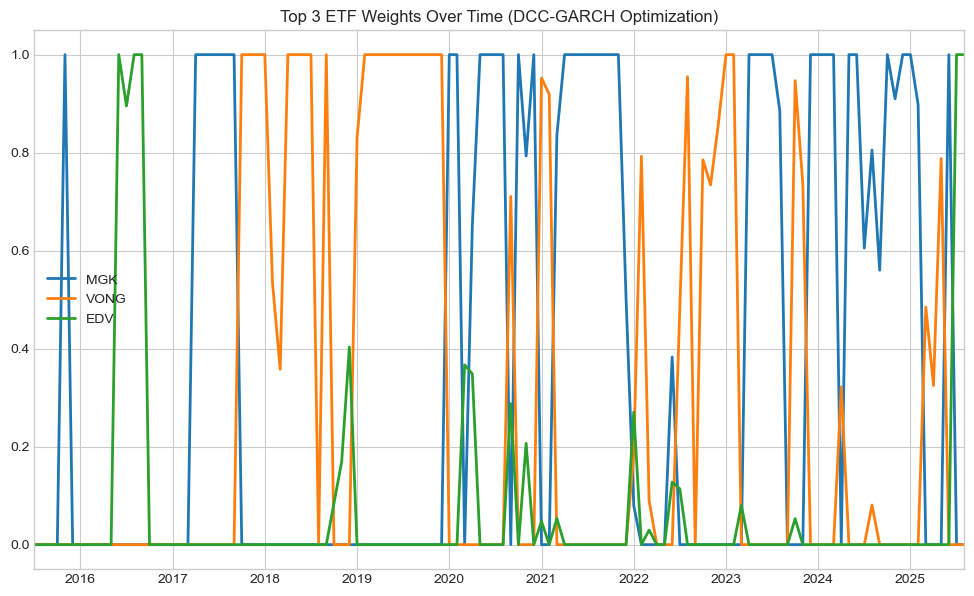

In [123]:
if rolling_dcc_weights_list:
    dcc_weights_df = pd.concat(rolling_dcc_weights_list, axis=1).T
    top_dcc_etfs = dcc_weights_df.mean().sort_values(ascending=False).head(3).index
    dcc_weights_df[top_dcc_etfs].plot(
        figsize=(12, 7),
        title="Top 3 ETF Weights Over Time (DCC-GARCH Optimization)",
        lw=2,
    )
    plt.show()

    # Create monthly return series for the DCC strategy
    dcc_shifted_weights = dcc_weights_df.shift(1).reindex(returns_monthly.index).ffill()
    common_idx = dcc_shifted_weights.dropna().index.intersection(returns_monthly.index)
    aligned_weights = dcc_shifted_weights.loc[common_idx]
    aligned_returns = returns_monthly.loc[common_idx]
    dynamic_returns_series_dcc = pd.Series(
        np.sum(aligned_weights.values * aligned_returns[etf_symbols].values, axis=1),
        index=common_idx,
    )
else:
    dynamic_returns_series_dcc = pd.Series(dtype=float)
    print("No successful DCC-GARCH optimizations were completed.")

First, our approach is appropriate, there are significant ARCH-effects in the volatility structure of the individual asset.  So what can we say about the results of our optimization process?  

Weight move quite a lot over time, but interestingly, they seem to be moving mostly across the Russell 1000 Growth ETFs, Mega Cap Growth ETF, and a treasury ETF, the Extended Duration Treasury ETF.  This makes sense to switch weights towards higher expected return portfolio if the expected market covariance/variance is low, and switch to lower volatility ETFs when expected volatility is high.  What is concerning, though, is that there are many instance with full weight on just one ETF, quite extreme weights that can quickly change.

### 5. Regime‑Switching Model

In this section, we will implement a more dynamic model that changes optimal portfolios based on the current state of the economy.  Specifically, we will estimate a two‑state Markov model using macro and market factors to predict the next state of the economy.  Intuitively, we can think of this model splitting the time series of returns into, for example, low market risk and high market risk periods.  It would make sense to invest into more aggressive, growth heavy ETFs if we know the market is relatively calm, while during more uncertain periods it might be better to invest into more bond heavy ETFs that promise more stable return.

Sources are [Andrew Filardo's paper](https://www.kansascityfed.org/documents/7002/choosing-information-variables-for-transition-probabilities-filardo-pdf-rwp98-091.pdf), *Choosing information variables for transition probabilities in a time-varying transition probability Markov switching model*, the book chapter *Regime Switching with Time-Varying Transition Probabilities* by [Francisc Diebold et al.](https://www.sas.upenn.edu/~fdiebold/papers/paper69/pa.dlw.pdf), the [statsmodel documentation for Markov switching dynamic regression models](https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html)

The Markov regime switching model is relatively straightforward: Monthly VOO returns are modelled as coming from one of *K* hidden regimes, each with its own mean and variance; the regime follows a first-order Markov chain whose transition probabilities are a logit function of last month’s VIX and 10 y–3 m term spread, and we pick *K* by the lowest BIC subject to every regime having enough observations.

1. Return equation (conditional on the latent regime)

   I assume that the market returns follow a Markov process.  I approximate the market returns with VOO:

   $$
   r_t \;=\; \mu_{s_t} \;+\; \varepsilon_t,
   \qquad
   \varepsilon_t \sim \mathcal N\!\bigl(0,\;\sigma_{s_t}^2\bigr),
   $$

   where

   * $r_t$ = monthly VOO total return (endogenous series),
   * $s_t \in \{1,\dots,K\}$ = unobserved regime at time $t$,
   * each regime $j$ has its own mean $\mu_j$ and variance $\sigma_j^2$.

2. Regime dynamics: first-order Markov chain with time-varying transition probabilities (TVTP)

   To fit the Markov model, I further assume that the probabilities for each regime change based on economic conditions.  To measure the relevant economic conditions, we could use a whole array of macro variable, but for our purposes I restrict to just two: 1) the yield curve slope, measured as the difference between the 10 year and 3 month government bonds, and 2) the volaility index or VIX for 30-days S&P 500 options.  The yield curve slope is a good measure for the overall expectations of in the economy; famously if the economy is approaching a recession the yield curve would invert, for example.  VIX is a short term measure tell us something about the expected volatility over the next month or so of the market portfolio.  Conceptually, we can plug the lagged predictors into a logit model to predict the transition probabilities for the regimes.

   $$
   \Pr\!\bigl[s_t = j \mid s_{t-1} = i,\;x_{t-1}\bigr]
     \;=\;
     \pi_{ij}\!\left(x_{t-1}\right),
   $$

   where the vector of exogenous predictors is

   $$
   x_{t-1} =
   \begin{bmatrix}
     1\\[2pt] \text{VIX}_{\,t-1}\\[2pt] (\text{10Y} - \text{3M})_{\,t-1}
   \end{bmatrix},
   $$

   and the logit link gives, for $j=1,\dots,K$,

   $$
   \pi_{ij}(x) \;=\;
   \frac{\exp\!\bigl(\gamma_{ij}^\top x\bigr)}
        {\displaystyle\sum_{\ell=1}^{K}\exp\!\bigl(\gamma_{i\ell}^\top x\bigr)}.
   $$

3. Model selection & estimation

   Finally, we also need to determine how many regimes we are considering.  For this, we can run hyperparameter tuning and select the number of regimes that minimizes BIC, under the condition that each regime last for some minimum number of observation (this avoid the model jumping from one regime to the other every other month).

   As final output, we get model output a series with smoothed regime probabilities over time and a series of regime states.  We can now estimate for each regime state the optimal portfolio.  Practically, we can predict the optimal portfolio for next period by using the predicted probabilities from the current level of the yield curve spread and VIX and probability weight the optimial portfolios for each regime.


Let's first load the exogenous variables, the yield spread and VIX, and align the indices with the ETF return data.

In [124]:
def get_fred_data(start, end):
    """Fetches US Treasury yield and VIX data from FRED."""
    print("Fetching VIX and yield curve data from FRED...")
    symbols = {"3M": "DGS3MO", "10Y": "DGS10", "VIX": "VIXCLS"}
    try:
        df = DataReader(list(symbols.values()), "fred", start, end)
        df = df.rename(columns={v: k for k, v in symbols.items()})
        df[["3M", "10Y"]] = df[["3M", "10Y"]] / 100.0  # Convert to decimal
        df["Spread_10Y_3M"] = df["10Y"] - df["3M"]
        return df.dropna()
    except Exception as e:
        print(f"Could not fetch FRED data: {e}")
        return pd.DataFrame()


exog_df = get_fred_data(returns_monthly.index.min(), returns_monthly.index.max())

# ---  Align and Prepare Data for Modeling ---
# Align all data to our monthly return frequency
exog_monthly = exog_df.resample("ME").last().ffill()
common_index = returns_monthly.index.intersection(exog_monthly.index)
returns_aligned = returns_monthly.loc[common_index]
exog_aligned = exog_monthly.loc[common_index]

# Use LAGGED economic data to predict the NEXT month's regime to prevent lookahead bias
exog_lagged = exog_aligned.shift(1).dropna()
final_index = returns_aligned.index.intersection(exog_lagged.index)
returns_final = returns_aligned.loc[final_index]
exog_final_lagged = exog_lagged.loc[final_index, ["VIX", "Spread_10Y_3M"]]
endog_voo = returns_final["VOO"]  # Market returns (VOO) to identify regimes

print(f"Final dataset for regime modeling has {len(endog_voo)} monthly observations.")

Fetching VIX and yield curve data from FRED...
Final dataset for regime modeling has 144 monthly observations.


We got the data now, let's fit the Markov model.  We have to provide as hyperparameter the number of regimes we expect.  We can use the BIC information criterion to find the best model balancing goodness of fit with model complexity.  We also want to avoid cases in which one regime has few observation, so we reject models that lead to regimes with very few observation. 

One we have fit the best model, let's have a look at the regime volatilities and expected return for VOO.  This helps us check if the fitted regimes make economic sense. 

In [125]:
# We test models with different numbers of regimes and select the best one based on BIC.
models = {}
for k in range(2, MAX_REGIMES_TO_TEST + 1):
    print(f"Fitting model with {k} regimes...")
    try:
        mod = MarkovRegression(
            endog=endog_voo,
            k_regimes=k,
            trend="c",  # Constant mean term in each regime
            switching_variance=True,
            exog_tvtp=sm.add_constant(exog_final_lagged),  # Time-Varying Transition Probs
        )
        
        res = mod.fit(search_reps=30, maxiter=300, disp=False)
        # Validate that each regime has a sufficient number of observations
        assigned_regimes = res.smoothed_marginal_probabilities.idxmax(axis=1)
        if (assigned_regimes.value_counts() < MIN_OBS_PER_REGIME).any():
            print(f"  > Model with {k} regimes rejected: a regime had insufficient data.")
            continue
        models[k] = res
        print(f"  > Model with {k} regimes is valid. BIC: {res.bic:.2f}")
    except Exception as e:
        print(f"  > Failed to fit model with {k} regimes: {e}")

if not models:
    raise RuntimeError("No suitable regime-switching models could be fitted.")

# Select the model with the lowest BIC
best_k = min(models, key=lambda k: models[k].bic)
best_model_results = models[best_k]
print(f"\nBest model selected: {best_k} regimes (Lowest BIC = {best_model_results.bic:.2f})")

# --- Interpret and Label the Regimes ---
# To make regimes interpretable, we sort them by their volatility.
regime_vols = best_model_results.params.filter(like="sigma2").sort_values()
regime_order = regime_vols.index.str.extract(r"\[(\d+)\]")[0].astype(int)
regime_map = {old_idx: new_idx for new_idx, old_idx in enumerate(regime_order)}

# Display characteristics of each sorted regime
sorted_params = pd.DataFrame()
for i in range(best_k):
    original_idx = regime_order.iloc[i]
    # Annualize parameters for interpretability
    mean_ann = best_model_results.params[f"const[{original_idx}]"] * 12 * 100
    vol_ann = np.sqrt(best_model_results.params[f"sigma2[{original_idx}]"]) * np.sqrt(12) * 100
    sorted_params[f"Regime {i}"] = [f"{mean_ann:.1f}%", f"{vol_ann:.1f}%"]
sorted_params.index = ["Annualized Mean (VOO)", "Annualized Volatility (VOO)"]
print("\nCharacteristics of Identified Market Regimes (Sorted by Volatility):")
print(sorted_params)

Fitting model with 2 regimes...
  > Model with 2 regimes is valid. BIC: -492.88
Fitting model with 3 regimes...
  > Model with 3 regimes is valid. BIC: -433.40
Fitting model with 4 regimes...
  > Model with 4 regimes rejected: a regime had insufficient data.

Best model selected: 2 regimes (Lowest BIC = -492.88)

Characteristics of Identified Market Regimes (Sorted by Volatility):
                            Regime 0 Regime 1
Annualized Mean (VOO)           9.1%    16.9%
Annualized Volatility (VOO)     9.4%    20.0%


In [126]:
# ------------------------------------------------------------
# 1. Pull parameter vector and associated statistics
# ------------------------------------------------------------
params   = best_model_results.params
bse      = best_model_results.bse
zvalues  = best_model_results.tvalues   # for a Logit these are Wald z-stats
pvalues  = best_model_results.pvalues

# ------------------------------------------------------------
# 2. Keep only the TVTP (Logit) parameters: they start with "p["
#    Example name:  "p[0->1].const", "p[0->1].VIX", "p[0->1].Spread_10Y_3M"
# ------------------------------------------------------------
mask = params.index.str.startswith("p[")
tvtp_params = params[mask]

# ------------------------------------------------------------
# 3. Build a summary DataFrame
# ------------------------------------------------------------
summary = pd.DataFrame({
    "coef"    : tvtp_params,
    "std err" : bse[mask],
    "z"       : zvalues[mask],
    "P>|z|"   : pvalues[mask]
})

# Make the index more readable:  "p[0->1].VIX"  ->  "0→1  :  VIX"
parsed = summary.index.to_series().str.extract(r'p\[(\d+->\d+)\]\.(.*)')
summary.index = parsed[0] + "  :  " + parsed[1]      # transition : variable
summary.index.name = "Transition  :  Variable"

# ------------------------------------------------------------
# 4. Display
# ------------------------------------------------------------
summary


,coef,std err,z,P>|z|
Transition : Variable,,,,
0->0 : tvtp0,-7633.394,0.000,-472686054292830617600.000,0.000
1->0 : tvtp0,-3250.076,20.870,-155.728,0.000
0->0 : tvtp1,445.699,NaN,NaN,NaN
1->0 : tvtp1,184.451,365.647,0.504,0.614
0->0 : tvtp2,-123.156,NaN,NaN,NaN
1->0 : tvtp2,-223.947,0.200,-1117.821,0.000


As we can see, Regime 0 is the low risk - low expected return regime, while Regime 1 is the high risk - high expected return regime.  We can use the return history for each regime to estimate the optimal portfolio if the economy is in a low or high risk state.

Let us now get the marginal probabilities for the two regimes and plot the probabilities over time.

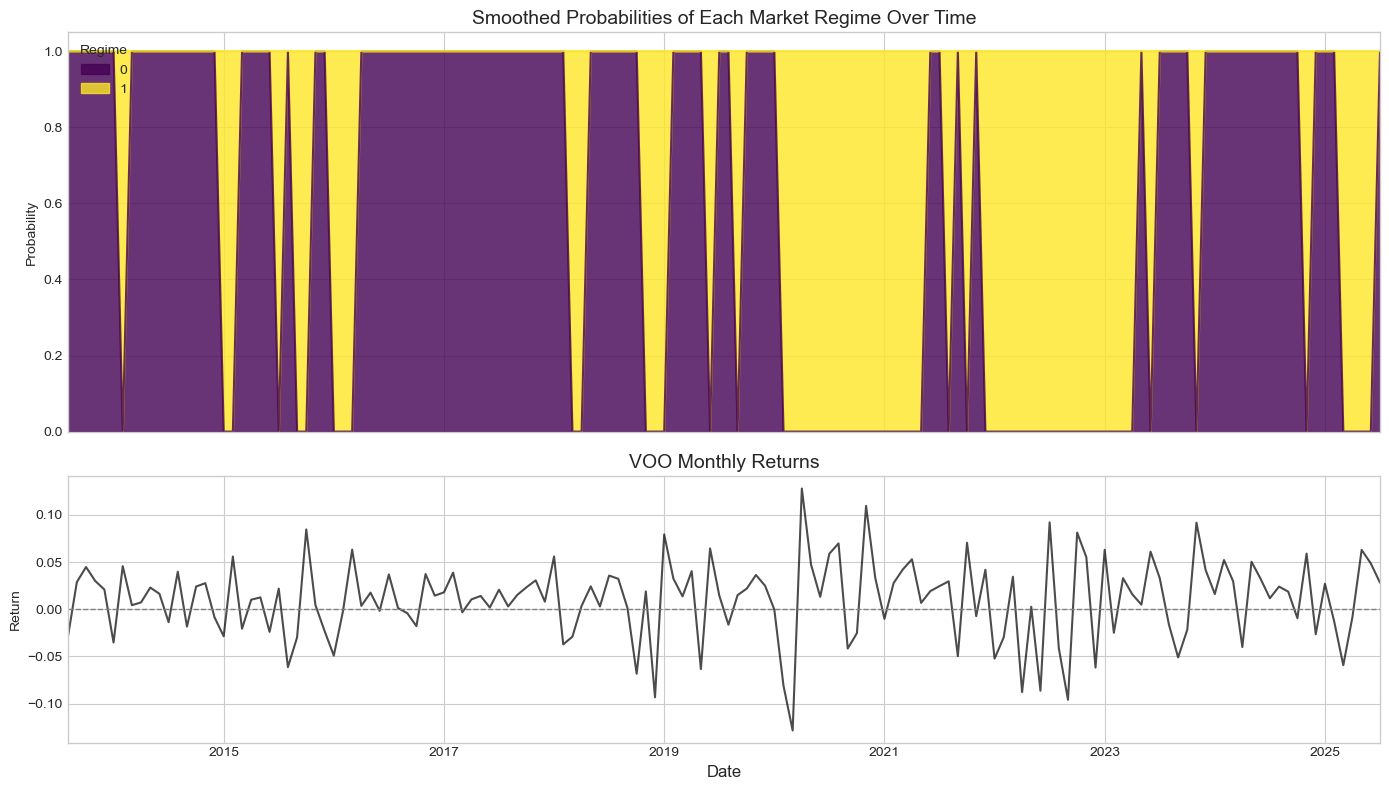

In [127]:
# Get the final, sorted series of regime probabilities
smoothed_probs = best_model_results.smoothed_marginal_probabilities.rename(
    columns=regime_map
).sort_index(axis=1)
regime_series = smoothed_probs.idxmax(axis=1).rename("regime")


# --- Visualize Regime Probabilities vs. Market Returns ---
fig, axes = plt.subplots(
    2, 1, figsize=(14, 8), sharex=True, gridspec_kw={"height_ratios": [3, 2]}
)
smoothed_probs.plot(ax=axes[0], kind="area", stacked=True, colormap="viridis", alpha=0.8)
axes[0].set_title("Smoothed Probabilities of Each Market Regime Over Time", fontsize=14)
axes[0].set_ylabel("Probability")
axes[0].legend(title="Regime", loc="upper left")
returns_final["VOO"].plot(ax=axes[1], color="black", label="VOO Monthly Return", alpha=0.7)
axes[1].set_title("VOO Monthly Returns", fontsize=14)
axes[1].set_ylabel("Return")
axes[1].axhline(0, color="grey", lw=1, linestyle="--")
plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()

Plotting the predicted regimes over the sample period, we indeed see that during periods of high volatility, in 2020 and again in 2022, we are in Regime 1, while during very calm periods with steady returns, like 2017, we are in Regime 0. 

### 6. Regime‑Aware Dynamic Strategy

From the previous section, we have a Markov regime switching model that provides probabilities for being in the low or high risk state of the world.  In this section, we will be estimating for each regime the optimal portfolio and implement the trading strategy.  I can split the sample across the two state based on which state in the respective period is more likely.  I can use the sample for each regime to estimate the optimal portfolio that matches VOO's global volatility within the given state of the world.  This is especially useful as the Markov switching model can provide probabilities for being in either state in the next period based on the current yield curve spread the VIX, which we can use to blend the optimal portfolios for each regime based on the probabilities for being in either state.  Basically, this is a in-sample test as the probabilities are directly observed from the fitted model; below we will check how the model performs out of sample.

Now that we have a fitted Markov model with multiple states, we can estimate for *each* regime the efficient frontier and the optimal portfolio that matches VOO's volatility.  We can make wrap this in a function, so we can re-use the approach. 

In [128]:
# We compute a separate optimal portfolio for each identified regime.
def compute_regime_optimal_weights(
    returns,
    regime_labels,
    etf_symbols,
    expense_vector,
    target_volatility,
    n_regimes,
    frontier_points=50,
    min_obs_per_regime=None,
):
    """
    For each hidden-state regime, estimate expected returns / covariance,
    build the efficient frontier, and select the portfolio whose annualised
    volatility matches `target_volatility` (e.g. VOO).

    Parameters
    ----------
    returns : DataFrame
        Monthly returns of the ETFs (index = Date, columns = symbols).
    regime_labels : Series
        Integer regime label for each date (same index as `returns`).
    etf_symbols : list[str]
        Ordered list of ETF tickers (column order used downstream).
    expense_vector : ndarray
        Annualised expense ratio for each ETF, in the same order as `etf_symbols`.
    target_volatility : float
        Benchmark volatility to match when picking the optimal point
        on each regime’s frontier (e.g. VOO’s σᵇ).
    n_regimes : int
        Total number of regimes in the hidden-state model.
    frontier_points : int, default 50
        Number of points generated on each frontier.
    min_obs_per_regime : int or None
        Minimum observations required to estimate a regime frontier.
        Defaults to `max(24, len(etf_symbols))`.

    Returns
    -------
    dict[int, ndarray]     regime → optimal weight vector
    dict[int, DataFrame]   regime → frontier with columns ['volatility', 'expected_return']
    """
    if min_obs_per_regime is None:
        min_obs_per_regime = max(24, len(etf_symbols))

    regime_optimal_weights = {}
    regime_frontiers       = {}
    exp_ret_by_regime      = {}
    cov_by_regime          = {}


    for r in range(n_regimes):
        in_regime = regime_labels == r
        if in_regime.sum() < min_obs_per_regime:
            # Fallback: 100 % VOO if data too sparse
            w_fallback = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
            regime_optimal_weights[r] = w_fallback
            continue

        # Use only returns from months assigned to regime r
        returns_r = returns.loc[in_regime, etf_symbols]

        # Annualised expected returns and covariance (Ledoit–Wolf shrinkage)
        exp_ret_r = returns_r.mean().values * 12 - expense_vector
        cov_r = LedoitWolf().fit(returns_r.values).covariance_ * 12

        # keep for downstream plotting / diagnostics
        exp_ret_by_regime[r] = exp_ret_r
        cov_by_regime[r]     = cov_r

        # Build the frontier and prune dominated points
        frontier_r = efficient_frontier(cov_r, exp_ret_r, n_points=frontier_points)
        frontier_r = prune_frontier(frontier_r)              

        # Pick portfolio whose volatility is closest to target_volatility
        _, w_opt = select_portfolio(frontier_r, "sigma", target_volatility)

        if w_opt is not None:
            print(f"  > Top 3 ETFs for Regime {r} Portfolio (matching VOO vol):")
            top_indices = np.argsort(w_opt)[-3:][::-1]
            for idx in top_indices:
                if w_opt[idx] > 0.01:
                    symbol = etf_symbols[idx]
                    name = etf_name_map.get(symbol, "Unknown")
                    print(f"    {symbol} ({name}): {w_opt[idx]:.2%}")

            regime_optimal_weights[r] = w_opt
            regime_frontiers[r] = frontier_r
        else:
            w_fallback = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
            regime_optimal_weights[r] = w_fallback

    return (
        regime_optimal_weights,
        regime_frontiers,
        exp_ret_by_regime,
        cov_by_regime,
    )

# --- Call the weight-selection helper ---
regime_opt_weights, regime_frontiers, exp_ret_by_regime, cov_by_regime = compute_regime_optimal_weights(
    returns           = returns_final, 
    regime_labels     = regime_series,
    etf_symbols       = etf_symbols,
    expense_vector    = expense_vector,
    target_volatility = voo_sigma_annual,  
    n_regimes         = best_k,
    frontier_points   = FRONTIER_POINTS,
)


  > Top 3 ETFs for Regime 0 Portfolio (matching VOO vol):
    MGK (Mega Cap Growth ETF): 100.00%
  > Top 3 ETFs for Regime 1 Portfolio (matching VOO vol):
    VIG (Dividend Appreciation ETF): 44.03%
    VONG (Russell 1000 Growth ETF): 20.83%
    VGSH (Short-Term Treasury ETF): 17.42%


Let's visualize the efficient frontiers for each regime, as well as the optimal portfolio/

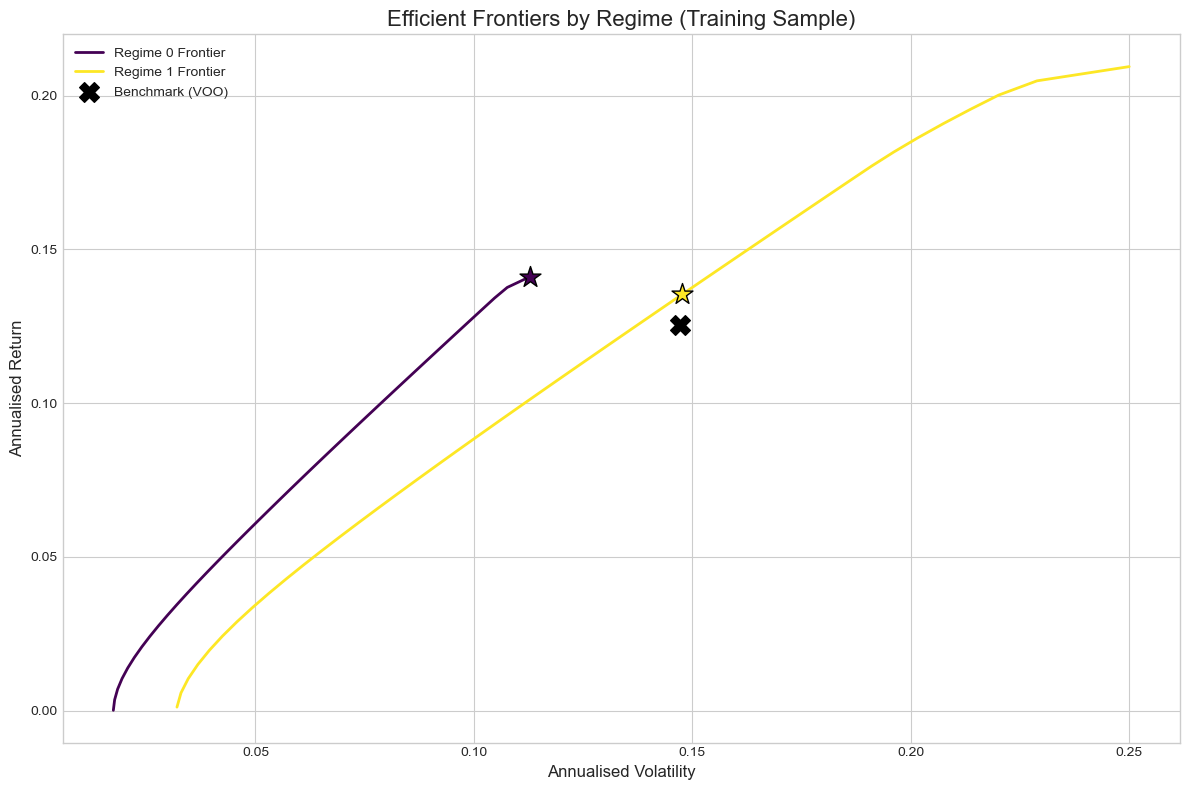

In [129]:
def plot_regime_frontiers(
    regime_frontiers,
    regime_optimal_weights,
    cov_by_regime,
    exp_ret_by_regime,
    etf_symbols,
    benchmark_vol,
    benchmark_ret,
    title="Efficient Frontiers by Regime",
):
    """
    Draw each regime’s efficient frontier plus the selected optimal portfolio,
    and overlay the benchmark (e.g. VOO).

    Parameters
    ----------
    regime_frontiers : dict[int, DataFrame]
        Output from `compute_regime_optimal_weights`.
    regime_optimal_weights : dict[int, ndarray]
        Output from `compute_regime_optimal_weights`.
    cov_by_regime : dict[int, ndarray]
        Covariance matrices used when selecting weights (optional: for stars).
    exp_ret_by_regime : dict[int, ndarray]
        Expected-return vectors used when selecting weights.
    etf_symbols, benchmark_vol, benchmark_ret : see above
    """
    num_regimes = len(regime_frontiers)
    colors = plt.cm.viridis(np.linspace(0, 1, num_regimes))
    plt.figure(figsize=(12, 8))

    for r, frontier in regime_frontiers.items():
        plt.plot(
            frontier["sigma"],
            frontier["mu"],
            label=f"Regime {r} Frontier",
            lw=2,
            color=colors[r],
        )

        # ──────────────────────────────────────────────────────────────────
        # optional star marker (needs cov & mu); skip if not provided
        # ──────────────────────────────────────────────────────────────────
        if cov_by_regime and exp_ret_by_regime:
            w_opt = regime_optimal_weights[r]
            opt_vol = np.sqrt(w_opt.T @ cov_by_regime[r] @ w_opt)
            opt_ret = w_opt.T @ exp_ret_by_regime[r]
            plt.scatter(
                opt_vol,
                opt_ret,
                marker="*",
                s=250,
                color=colors[r],
                edgecolors="black",
                zorder=5,
            )

    # benchmark marker
    if benchmark_vol is not None and benchmark_ret is not None:
        plt.scatter(
            [benchmark_vol],
            [benchmark_ret],
            color="black",
            marker="X",
            s=200,
            label="Benchmark (VOO)",
            zorder=6,
        )

    plt.title(title, fontsize=16)
    plt.xlabel("Annualised Volatility", fontsize=12)
    plt.ylabel("Annualised Return", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Plot the efficient frontiers for each regime ---
plot_regime_frontiers(
    regime_frontiers       = regime_frontiers,     # from compute_regime_optimal_weights
    regime_optimal_weights = regime_opt_weights,   # from compute_regime_optimal_weights
    cov_by_regime          = cov_by_regime,                   # omit → no star markers
    exp_ret_by_regime      = exp_ret_by_regime,                   # omit → no star markers
    etf_symbols            = etf_symbols,
    benchmark_vol          = voo_sigma_annual,
    benchmark_ret          = voo_mu_annual,
    title                  = "Efficient Frontiers by Regime (Training Sample)",
)

# ---  Backtest the Dynamic Strategy ---
# At each month, the portfolio is a blend of the regime-optimal portfolios,
# weighted by the smoothed probability of being in each regime at that time.
dynamic_weights_list = []
for t in range(len(returns_final)):
    probs_t = smoothed_probs.iloc[t]
    blended_w = np.zeros(n_assets)
    # Create blended portfolio by weighting each regime's portfolio by its probability
    for i in range(best_k):
        if i in regime_opt_weights:
            blended_w += probs_t[i] * regime_opt_weights[i]
    dynamic_weights_list.append(blended_w / blended_w.sum())

# Calculate the monthly returns of this dynamic portfolio
dynamic_port_returns = np.sum(
    np.array(dynamic_weights_list) * returns_final[etf_symbols].values, axis=1
)
dynamic_returns_series = pd.Series(dynamic_port_returns, index=returns_final.index)

The plot shows that the low-volatility regime , Regime 0, has a more limited distribution, which is expected as certain volatility levels cannot even be reached with a long-only portfolio.  As a consequence, the optimal portfolio is an edge case, putting all weight into the Mega Cap Growth ETFs.  This makes sense as in a low market risk state, we can overweight historically risky ETFs to maximize expected returns while conditional volatility is low.  On the other hand, during periods of high market risk, Regime 1, we add to the portfolio our treasury ETF, keep some weight in a Growth ETF, and put more than 40% into the Dividend Appreciation ETF, VIG.  VIG is an interesting choice.  It has similar but lower expected return and expected volatility than VOO, so it would make sense to weight heavy on it to reach with the portfolio still VOO's global volatility while avoiding too much risk exposure during the high market risk state of the world.

There is also the Gordon-Growth model tha provides a simple relationship of price to expected dividends, discount rate (or market risk), and dividend growth: $P = \dfrac{D_1}{r - g}$.  The total derivative is  

$$
dP \;=\; -\frac{P}{\,r-g\,}\,dr \;+\; \frac{P}{\,r-g\,}\,dg.
$$

When the discount rate rises during the high market risk Regime, a rise in the expected dividend growth rate at the same time can cushion the effect of rising interest rates.  VIG by definition tracks firms that have a history of rising dividends , so we can expect it to be more likely to see rising growth rates which can partially offsets the negative effect of rising interest rates, cushioning VIG’s price when market risk is high.


For back-testing, we can use the marginal probabilities to blend the optimal portfolios for the regimes.  We can estimate the monthly in-sample returns for this strategy and use it for performance comparison below.

### 7. Final Performance Comparison

In this section, we will compare the performance of all the model we have looked at so far.  Let us plot cumulative returns for the different strategies we identified, display key performance metrics, and run Monte‑Carlo forecasts for the models without dynamic weight changes.

Calculate first some performance measures for the different strategies, specifically total return, annual returns, volatility, and Sharpe ratio.  Since the time series of returns become more complete over time, I will limit to the performance over the last seven years and drop the first three year, just to be sure the models are all fit on complete data.

In [130]:
# --- Define a Performance Metrics Calculator ---
def calculate_performance_metrics(returns_series):
    """
    Calculates key performance metrics for a series of returns.

    Args:
        returns_series (pd.Series): A series of periodic (e.g., monthly) returns.

    Returns:
        dict: A dictionary of performance metrics.
    """
    if returns_series.empty or returns_series.isnull().all():
        return {
            "Total Return (%)": np.nan, "Annualized Return (%)": np.nan,
            "Annualized Volatility (%)": np.nan, "Sharpe Ratio": np.nan,
        }
    n_periods_per_year = 12  # For monthly returns
    ann_return = ((1 + returns_series.mean()) ** n_periods_per_year - 1) * 100
    ann_vol = returns_series.std() * np.sqrt(n_periods_per_year) * 100
    sharpe = sharpe_ratio(ann_return / 100, ann_vol / 100)
    
    cumulative_returns = (1 + returns_series).cumprod()
    total_return = (cumulative_returns.iloc[-1] - 1) * 100
    
    return {
        "Total Return (%)": total_return,
        "Annualized Return (%)": ann_return,
        "Annualized Volatility (%)": ann_vol,
        "Sharpe Ratio": sharpe,
    }


# --- Prepare All Strategy Returns for Comparison ---
# Use a common lookback window for a fair comparison
lookback_years = 7
end_date_lookback = max(returns_final.index)
start_date_lookback = end_date_lookback - pd.DateOffset(years=lookback_years)
returns_win = returns_final.loc[start_date_lookback:end_date_lookback].dropna(how="all")

# Helper function to calculate strategy returns safely
def get_strategy_returns(weights):
    if weights is not None:
        return returns_win[etf_symbols] @ weights
    return pd.Series(dtype=float, index=returns_win.index)

strategies = {
    "VOO Benchmark": returns_win["VOO"],
    "Static Raw (Risk-Match)": get_strategy_returns(w_sigma_raw),
    "Static L1 Regularized (Risk-Match)": get_strategy_returns(w_sigma_reg_l1),
    "Static Shrunk (Risk-Match)": get_strategy_returns(w_sigma_shrunk),
    "Static Resampled": get_strategy_returns(w_resampled),
    "Black-Litterman": get_strategy_returns(w_bl_opt),
    "Risk Parity": get_strategy_returns(rp_weights),
    "Hierarchical Risk Parity": get_strategy_returns(hrp_weights),
    "HRP-MVO Blended": get_strategy_returns(w_tilt),
    "DCC-GARCH Dynamic": dynamic_returns_series_dcc.loc[start_date_lookback:end_date_lookback],
    "Regime-Aware Dynamic": dynamic_returns_series.loc[start_date_lookback:end_date_lookback],
}

# --- Display Performance Metrics Table ---
all_perf_metrics = {name: calculate_performance_metrics(ret.dropna()) for name, ret in strategies.items()}
all_perf_df = pd.DataFrame(all_perf_metrics).T
print("\n" + "=" * 70)
print("      COMPREHENSIVE STRATEGY PERFORMANCE METRICS")
print("=" * 70)
print(all_perf_df.sort_values(by="Sharpe Ratio", ascending=False))
print("=" * 70 + "\n")


      COMPREHENSIVE STRATEGY PERFORMANCE METRICS
                                    Total Return (%)  Annualized Return (%)  \
Regime-Aware Dynamic                         167.050                 16.130   
Static Raw (Risk-Match)                      174.367                 17.057   
Static L1 Regularized (Risk-Match)           174.830                 17.093   
Static Shrunk (Risk-Match)                   174.830                 17.093   
HRP-MVO Blended                              142.539                 14.649   
Static Resampled                             140.706                 14.774   
VOO Benchmark                                134.041                 14.439   
DCC-GARCH Dynamic                            115.161                 13.165   
Black-Litterman                               16.729                  2.294   
Risk Parity                                   28.366                  4.230   
Hierarchical Risk Parity                       0.670                  0.136   

 

Plot also the cumulative returns over the last couple of years and compare to VOO.

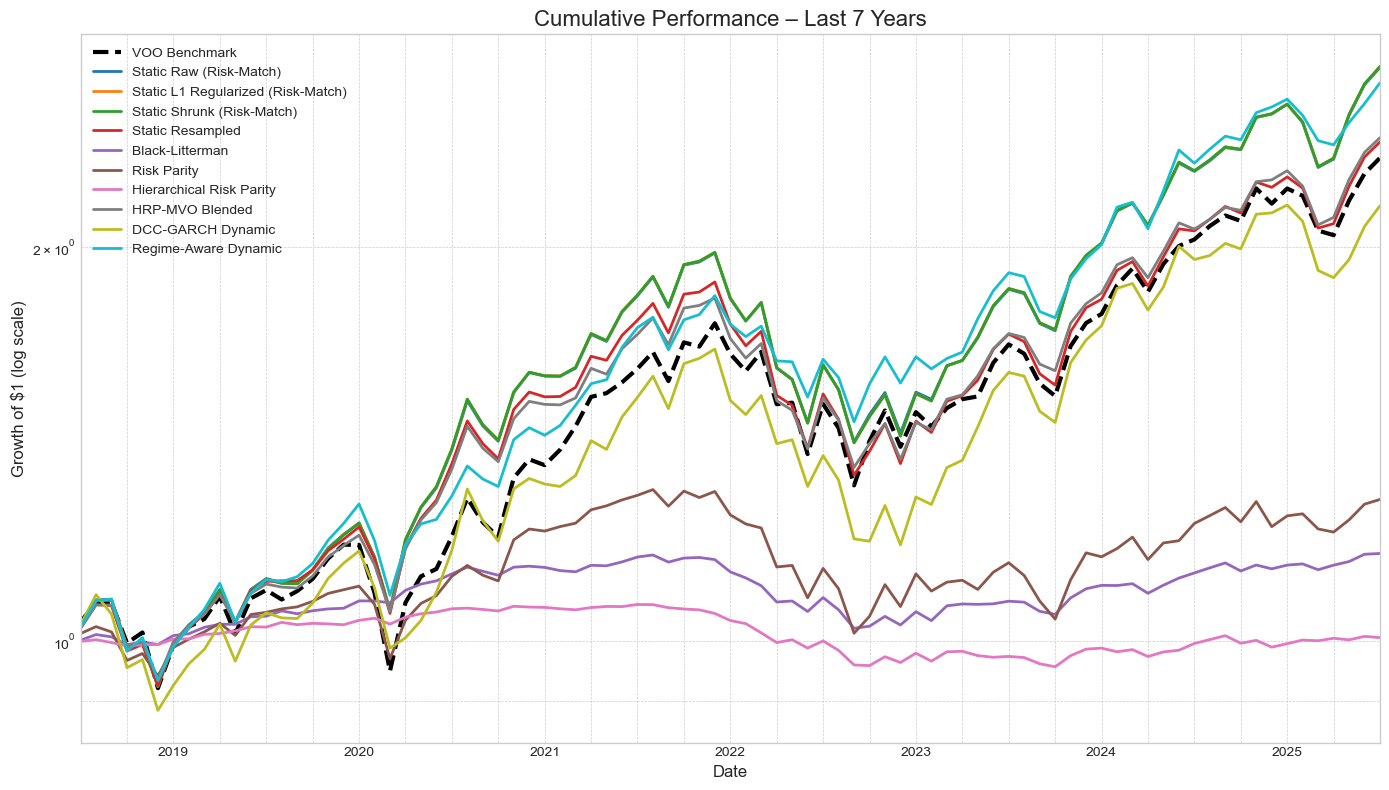

In [131]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
for name, rtn in strategies.items():
    if rtn.dropna().empty: continue
    growth = (1 + rtn).cumprod()
    if name.lower().startswith("voo"):
        growth.plot(ax=ax, label=name, lw=3, linestyle="--", color="black")
    else:
        growth.plot(ax=ax, label=name, lw=2)
ax.set_title(f"Cumulative Performance – Last {lookback_years} Years", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Growth of $1 (log scale)", fontsize=12)
ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Looking at the cumulative return chart and the performance metrics, we see that VOO is doing quite good, but there are models that outperform it.  The static portfolio optimization methods as well as the regime switching model perform the best.  The HRP blend with the mean-variance optimal portfolio is also doing quite well, but if we are already identifying the mean-variance efficient portfolio, why blend it again with a HRP portfolio.

On the other hand, the DCC-GARCH model performs a bit worse than VOO, making it less attractive, especially given the high frequency the weights are oscillating.  Assumedly we could do better if we were to use indeed weekly updates, or even daily portfolio updates and avoid the approximation using the predicted optimal portfolio in the last week of the previous month for the entire following month.  Black-Litterman, Risk Parity, and HRP have the worst performance.  We already know that the mean shrinkage in Black-Litterman leads to the algorithm basically deteriorating to minimizing volatility, the same objective that Risk Parity and HRP are following.  If we are seeking low volatility, those approaches are very useful, but not if we want to outperform the market.

We can also compare the performance based on simulated returns.  I do this only for the models that provide stable portfolio weights, not for DCC-GARCH and the Markov regime switching model.  For those dynamic model, we would have to build a more complicated simulation environment.

In [132]:
# Simulate future returns to see how our portfolios might perform under a wide
# range of possible outcomes, based on the historical return distribution.
print(f"Running Monte Carlo simulation with {MC_SIM_SCENARIOS} scenarios...")
# Use monthly parameters from the full sample for the simulation
monthly_mu_sample = annual_mu_sample / 12
rng = np.random.default_rng(seed=42)  # For reproducibility

# Generate all simulated paths at once for efficiency
simulated_returns_monthly = rng.multivariate_normal(
    mean=monthly_mu_sample,
    cov=sample_cov,  # Use the original sample covariance
    size=(MC_SIM_SCENARIOS, MC_SIM_HORIZON_MONTHS),
)


def simulate_portfolio_performance(weights):
    """Calculates performance metrics from simulated return paths."""
    if weights is None or np.isnan(weights).any():
        return {
            "Mean Ann. Return (%)": np.nan, "Ann. Volatility (%)": np.nan,
            "Sharpe Ratio": np.nan, "VaR 5% (Ann.) (%)": np.nan,
        }
    portfolio_sim_returns = simulated_returns_monthly @ weights
    # Calculate annualized metrics from the simulation results
    mean_monthly_return = np.mean(portfolio_sim_returns)
    std_monthly_return = np.std(portfolio_sim_returns)
    
    annual_mean_return = mean_monthly_return * 12 * 100
    annual_volatility = std_monthly_return * np.sqrt(12) * 100
    sharpe = sharpe_ratio(annual_mean_return/100, annual_volatility/100)
    
    # Value-at-Risk (VaR): The worst expected annualized loss at a 5% confidence level.
    var_5_percent = np.percentile(portfolio_sim_returns, 5) * 12 * 100
    
    return {
        "Mean Ann. Return (%)": annual_mean_return,
        "Ann. Volatility (%)": annual_volatility,
        "Sharpe Ratio": sharpe,
        "VaR 5% (Ann.) (%)": var_5_percent,
    }

# Define weights for all strategies to be simulated
voo_weights = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
simulation_portfolios = {
    "VOO Benchmark": voo_weights,
    "Static Raw (Risk-Match)": w_sigma_raw,
    "Static L1 Regularized (Risk-Match)": w_sigma_reg_l1,
    "Static Shrunk (Risk-Match)": w_sigma_shrunk,
    "Static Resampled": w_resampled,
    "Black-Litterman": w_bl_opt,
    "Risk Parity": rp_weights,
    "Hierarchical Risk Parity": hrp_weights,
    "HRP-MVO Blended": w_tilt,
}

# Run simulation for each portfolio
sim_results = {name: simulate_portfolio_performance(w) for name, w in simulation_portfolios.items()}
sim_results_df = pd.DataFrame(sim_results).T

print("\n" + "=" * 70)
print(f"      MONTE CARLO SIMULATION SUMMARY ({MC_SIM_HORIZON_MONTHS // 12}-YEAR HORIZON)")
print("=" * 70)
print(sim_results_df.sort_values(by="Sharpe Ratio", ascending=False))
print("=" * 70 + "\n")

Running Monte Carlo simulation with 10000 scenarios...

      MONTE CARLO SIMULATION SUMMARY (10-YEAR HORIZON)
                                    Mean Ann. Return (%)  Ann. Volatility (%)  \
Static Raw (Risk-Match)                           14.448               14.697   
Static L1 Regularized (Risk-Match)                14.449               14.732   
Static Shrunk (Risk-Match)                        14.449               14.732   
HRP-MVO Blended                                   12.537               12.911   
Static Resampled                                  12.863               14.065   
VOO Benchmark                                     12.515               14.707   
Black-Litterman                                    2.000                3.389   
Risk Parity                                        4.499                9.246   
Hierarchical Risk Parity                           0.172                2.377   

                                    Sharpe Ratio  VaR 5% (Ann.) (%)  
Static R

The Monte Carlo simulations confirm what we expected from the historic back testing: the static mean-variance optimization approach outperforms the market portfolio.  To really make sure this is true, we can run a out-of-sample back-testing framework.

### Section 8. Back-Testing Framework: Last 3-Year Out-of-Sample

This section evaluates how well our static mean-variance optimization and the Markov regime switching model perform on unseen data.  Those two models proved to perform best in the over the entire sample period.  Specifically, we will fit parameters on the first 7 years of data and the let the models run for the following three years.  For the mean-variance portfolio, we don't have to do anything and can just observe how the static optimal portfolios perform over time.  For the Markov model, we will adjust portfolio weights based on the predicted regime for next period over the test period.  Finally, we benchmark against VOO and check which model is truly better.  Looking at the period of 2022 to 2025 for out-of-sample testing is especially for the MRS model quite interesting as the interest rates were rising quite sharply during this time.  If the Markov model that is fitted during a relatively low interest rate period outperforms also during rising interests, we have a quite robust strategy over time.

First, let us split our sample into training and testing periods. 

In [133]:
def split_windows(returns, fit_years=7, test_years=3):
    """Return training and testing DataFrames given total monthly returns."""
    end_test   = returns.index.max()
    start_test = end_test - relativedelta(years=test_years) + relativedelta(months=1)
    start_fit  = start_test - relativedelta(years=fit_years)
    train = returns.loc[start_fit : start_test - relativedelta(months=1)]
    test  = returns.loc[start_test : end_test]
    return train, test

#  split sample  (7-year fit  |  3-year test)
train_returns, test_returns = split_windows(returns_final, fit_years=7, test_years=3)
train_exog  = exog_final_lagged.loc[train_returns.index]
test_exog   = exog_final_lagged.loc[test_returns.index]

Next, let's see how the static mean-variance optimization performs out of sample.

In [134]:
# Annualiszd mean and covariance from the training sample
exp_ret_train = train_returns.mean().values * 12 - expense_vector
cov_train     = train_returns.cov().values  * 12

# Build the efficient frontier and pick the portfolio
# whose volatility matches the VOO benchmark
ef_train = prune_frontier(
    efficient_frontier(cov_train, exp_ret_train, FRONTIER_POINTS)
)
_, w_raw = select_portfolio(ef_train, "sigma", voo_sigma_annual)

# fallback if optimization failed
if w_raw is None:
    w_raw = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])

# Apply the fixed weights over the entire test period
oos_ret_raw = (test_returns[etf_symbols] @ w_raw).rename("RAW OOS")

# Report Compound Annual Growth Rate ("CAGR"), a an intital check.
cagr = (1 + oos_ret_raw).prod() ** (12 / len(oos_ret_raw)) - 1
print(f"\nRaw-frontier out-of-sample CAGR: {cagr:.2%}")

# Inspect top holdings
top_idx = np.argsort(w_raw)[-3:][::-1]
print("\nTop 3 ETF weights (fixed allocation):")
for idx in top_idx:
    if w_raw[idx] > 0.01:
        sym = etf_symbols[idx]
        name = etf_name_map.get(sym, "Unknown")
        print(f"  {sym} ({name}): {w_raw[idx]:.2%}")


Raw-frontier out-of-sample CAGR: 17.11%

Top 3 ETF weights (fixed allocation):
  VONG (Russell 1000 Growth ETF): 71.55%
  VIG (Dividend Appreciation ETF): 16.20%
  VTIP (Short-Term Inflation-Protected Securities ETF): 12.23%


The optimal portfolio allocation is quite similar as for the full in-sample fit, except for the addtion of VIG, the Dividend Appreciation ETF, and we are investing in a different type of securities ETF, VTIP.  VIG has a performance resonably similar to VOO and with relatively low interests during the period, according to the Gordon Growth Model above, having a strong dividend growht rate *g* is sure to help performance.  Overall, though, the new addition only accounts for ca. 16% of portfolio weights, and the VTIP ETF is in the end also a Treasury ETF, so the static mean-variance optimization is quite persistent in recommending its Growth ETF + Treasury ETF combination.  

Now, let us also fit the Markov regime switching model for the training period and see how it performs during the test period.  

The only notworth feature here is how we actually perdict transition probabilities out-of-sample for the Markov model.  Once we have a fitted model on the training data, we create a second 'test' model which contains the exogenous regressior predicting our next state, the yield curve slope and VIX.  We then apply the Hamilton filter with the estimated parameters from the Markov model from the training period.  The Hamilton filter calculates the probabilities for being in a latent state in period *t* using all given data up to *t-1*, making it basically a recursive Bayesian inference algorithm about the transition probabilities.  A more detailed explanation can be found in this [R blog](https://www.r-bloggers.com/2022/02/understanding-hamilton-regime-switching-model-using-r-package/).

In [135]:
# --- fit Markov-Regression on the training window -----------------------
k_regimes = 2                    # or `best_k` if cross-validated earlier
mr_train = MarkovRegression(
    endog = train_returns["VOO"],
    k_regimes = k_regimes,
    trend = "c",
    switching_variance = True,
    exog_tvtp = sm.add_constant(train_exog)
)

res_train = mr_train.fit(search_reps=30, maxiter=300, disp=False)

# --- filter / forecast regimes on the test window --------------------------
mr_test = MarkovRegression(
    endog              = test_returns["VOO"],
    k_regimes          = k_regimes,
    trend              = "c",
    switching_variance = True,
    exog_tvtp          = sm.add_constant(test_exog)
)

# Apply Hamilton Filter with parameters from model fitted on training data
# to predict one-step-head transition probabilities.  Importantly, we
# fix the parameters that are used for the probability model to the 
# results from the model fitted on the training data.
res_test = mr_test.filter(res_train.params) 

# One-step-ahead probabilities:  P(state_t | information_set_{t-1})
pred_probs = res_test.predicted_marginal_probabilities.copy()
pred_probs.index = test_returns.index

We have now the out-of-sample predicted marginal probabilities for each regime.  We can estimate now the optimal portfolio for each regime in the training data and estimate the out-of-sample performance of the model by blending the optimal portfolios using the out-of-sample probabilties. 

In [136]:
# Convert the training-sample regime probabilities into hard labels
regime_labels_train = (
    res_train.smoothed_marginal_probabilities          # DataFrame: cols 0..k-1
             .idxmax(axis=1)                           # Series of ints
)

# Compute optimal portfolio for each regime
regime_opt_weights, regime_frontiers, exp_ret_by_regime, cov_by_regime = (
    compute_regime_optimal_weights(
        returns           = returns_final.loc[train_returns.index],
        regime_labels     = regime_labels_train,
        etf_symbols       = etf_symbols,
        expense_vector    = expense_vector,
        target_volatility = voo_sigma_annual,          # match VOO's volatility
        n_regimes         = k_regimes,
        frontier_points   = FRONTIER_POINTS,
        min_obs_per_regime=24 
    )
)

# (optional) quick sanity-check plot
# plot_regime_frontiers(regime_frontiers, regime_opt_weights,
#                       cov_by_regime, exp_ret_by_regime,
#                       etf_symbols, voo_sigma_annual, voo_mu_annual)

# --- build the dynamic out-of-sample portfolio ------------------------------
oos_weights = (
    pred_probs
    .apply(
        # blend the regime-specific weights by one-step-ahead probabilities
        lambda p: sum(p[j] * regime_opt_weights[j] for j in range(k_regimes)),
        axis=1, result_type="expand"
    )
    .pipe(lambda w: w.div(w.sum(axis=1), axis=0))      # normalise so weight sum to one
)
oos_weights.columns = etf_symbols

# realised return in month t uses the weights decided *before* that month
oos_port_ret = (
    (oos_weights.shift(1) * test_returns[etf_symbols])
    .sum(axis=1)
    .dropna()
)
oos_port_ret.name = "Regime-Switching OOS"

  > Top 3 ETFs for Regime 0 Portfolio (matching VOO vol):
    MGK (Mega Cap Growth ETF): 100.00%
  > Top 3 ETFs for Regime 1 Portfolio (matching VOO vol):
    VTIP (Short-Term Inflation-Protected Securities ETF): 51.39%
    VIOV (S&P Small-Cap 600 Value ETF): 48.61%


In [137]:
import re
import pandas as pd

# ------------------------------------------------------------
# 1. Pull parameter vector and associated statistics
# ------------------------------------------------------------
params   = res_train.params
bse      = res_train.bse
zvalues  = res_train.tvalues   # for a Logit these are Wald z-stats
pvalues  = res_train.pvalues

# ------------------------------------------------------------
# 2. Keep only the TVTP (Logit) parameters: they start with "p["
#    Example name:  "p[0->1].const", "p[0->1].VIX", "p[0->1].Spread_10Y_3M"
# ------------------------------------------------------------
mask = params.index.str.startswith("p[")
tvtp_params = params[mask]

# ------------------------------------------------------------
# 3. Build a summary DataFrame
# ------------------------------------------------------------
summary = pd.DataFrame({
    "coef"    : tvtp_params,
    "std err" : bse[mask],
    "z"       : zvalues[mask],
    "P>|z|"   : pvalues[mask]
})

# Make the index more readable:  "p[0->1].VIX"  ->  "0→1  :  VIX"
parsed = summary.index.to_series().str.extract(r'p\[(\d+->\d+)\]\.(.*)')
summary.index = parsed[0] + "  :  " + parsed[1]      # transition : variable
summary.index.name = "Transition  :  Variable"

# ------------------------------------------------------------
# 4. Display
# ------------------------------------------------------------
summary


,coef,std err,z,P>|z|
Transition : Variable,,,,
0->0 : tvtp0,4.323,2.978,1.452,0.147
1->0 : tvtp0,4935.777,37.095,133.059,0.000
0->0 : tvtp1,-0.237,0.196,-1.209,0.227
1->0 : tvtp1,-288.166,632.835,-0.455,0.649
0->0 : tvtp2,-19.221,100.622,-0.191,0.849
1->0 : tvtp2,-194.024,0.556,-348.743,0.000


Now we can plot the regime characteristics from the training data, to check how whether the regimes make economic sense.  And as a final check, we can estimate the compound annual growth rate, give a direct measure of average performance during the out-of-sample period. 

In [138]:
# Pull per-regime monthly parameters from the Markov-regression result
stats = []
for j in range(k_regimes):
    mean_ann = res_train.params[f"const[{j}]"] * 12 * 100            # %
    vol_ann  = (res_train.params[f"sigma2[{j}]"] ** 0.5) * (12 ** 0.5) * 100  # %
    stats.append({"regime": j, "mean": mean_ann, "vol": vol_ann})

stats_df = pd.DataFrame(stats).set_index("regime")

# Order regimes by volatility
order = stats_df.sort_values("vol").index        # e.g. [1, 0] for two regimes

# Print mean return and volatility
table = pd.DataFrame()
for i, r in enumerate(order):
    table[f"Regime {i}"] = [f"{stats_df.loc[r, 'mean']:.1f}%",
                            f"{stats_df.loc[r, 'vol']:.1f}%"]

table.index = ["Annualised Mean (VOO)", "Annualised Volatility (VOO)"]

print("\nCharacteristics of Identified Market Regimes (sorted by volatility):")
print(table)

# CAGR for sanity check
cagr = (1 + oos_port_ret).prod() ** (12 / len(oos_port_ret)) - 1
print(f"\nOut-of-sample CAGR: {cagr:.2%}")


Characteristics of Identified Market Regimes (sorted by volatility):
                            Regime 0 Regime 1
Annualised Mean (VOO)          19.8%     3.8%
Annualised Volatility (VOO)     5.6%    20.2%

Out-of-sample CAGR: 9.29%


Let's also visualize the predicted out-of-sample regime probabilities against the VIX and the Yield Curve Spread.

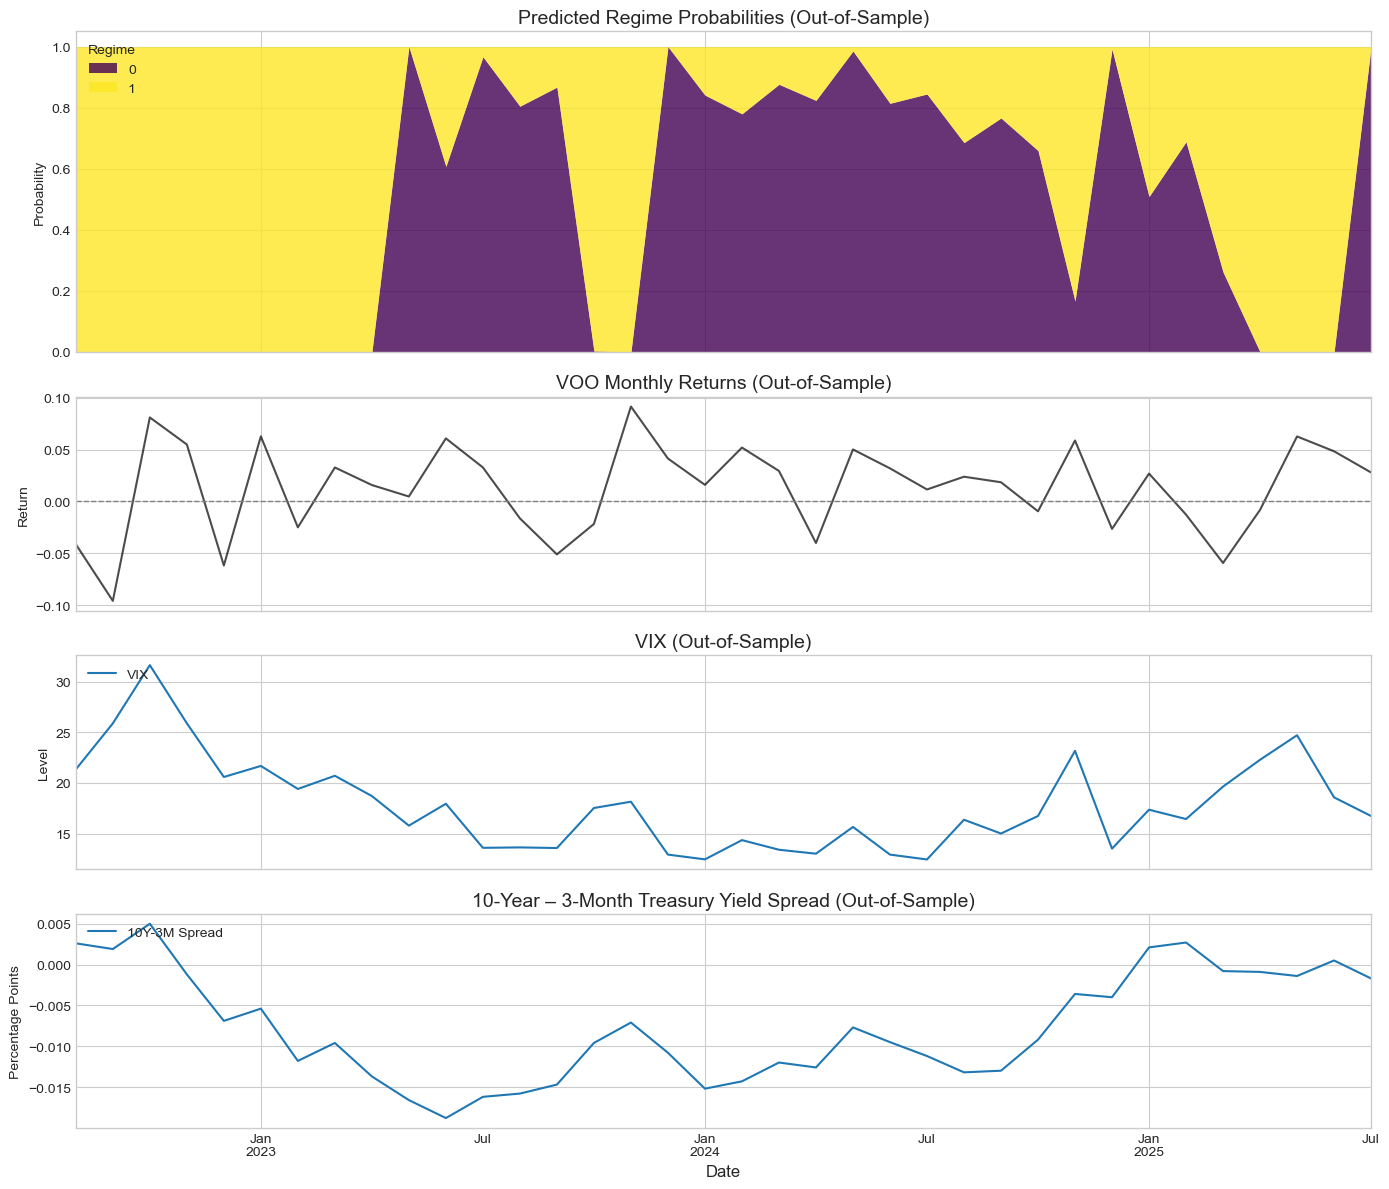

In [139]:
# --- Visualize Out-of-Sample Regime Probabilities, VOO, VIX & YC Spread ---
oos_idx = pred_probs.index                                        # convenience

fig, axes = plt.subplots(
    4, 1, figsize=(14, 12), sharex=True,          # <- 4 rows instead of 3
    gridspec_kw={"height_ratios": [3, 2, 2, 2]}
)

# --- Regime probabilities ---
pred_probs.plot(
    ax=axes[0],
    kind="area",
    stacked=True,
    colormap="viridis",
    alpha=0.8,
    linewidth=0
)
axes[0].set_title("Predicted Regime Probabilities (Out-of-Sample)", fontsize=14)
axes[0].set_ylabel("Probability")
axes[0].legend(title="Regime", loc="upper left")

# --- VOO returns ---
returns_final.loc[oos_idx, "VOO"].plot(
    ax=axes[1],
    color="black",
    label="VOO Monthly Return",
    alpha=0.7
)
axes[1].set_title("VOO Monthly Returns (Out-of-Sample)", fontsize=14)
axes[1].set_ylabel("Return")
axes[1].axhline(0, color="grey", lw=1, linestyle="--")

# --- Exogenous predictor: VIX ---
test_exog.loc[oos_idx, "VIX"].plot(
    ax=axes[2],
    lw=1.5,
    label="VIX"
)
axes[2].set_title("VIX (Out-of-Sample)", fontsize=14)
axes[2].set_ylabel("Level")
axes[2].legend(loc="upper left")

# --- Exogenous predictor: Yield-curve spread ---
test_exog.loc[oos_idx, "Spread_10Y_3M"].plot(
    ax=axes[3],
    lw=1.5,
    label="10Y-3M Spread"
)
axes[3].set_title("10-Year – 3-Month Treasury Yield Spread (Out-of-Sample)", fontsize=14)
axes[3].set_ylabel("Percentage Points")
axes[3].legend(loc="upper left")

plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()

The Markov model does seem to capture economic states relatively well using th exogenous predictors; when VIX and the Yield Spread go up, we are more likely to be in Regime 1.  However, VOO doesn't play ball and seems to have reduced volatility but with a high expected return even during the period of Regime 0. 

Notice also the negative(!) yield spread for most of the test period while VIX is low.  Quite contradictory, if we expect a recession to come, the Yield Spread would be negative, but why would VIX be low as well?  This is the challenge with the Markov Regime Switching model in general, we have relatively few observations overall and the last few years are outside of the normal pattern that we trained the model on.

The result is quite sobering, the performance is not very high.  Also the regimes are kind of wacky, having Regime 0 with high return and low volatility but Regime 1 with low return but high volatility.  Economically, it doesn't really make sense that a period of high risk delivers low returns and vice-versa, it should be exactly the other way round as investors are rewarded for the excess risk.  We can suspect this has to do with the shorter training period, leading to unstable and less robust results.  We can also see this in the optimal portfolios:  Regime 0 is a combination of a Treasry ETF and the S&P Small-Cap Value ETF, VIOV, while Regime 1 is fully invested in the Mega Cap Growth ETF.  VIOV has one of the highest overall volatilities, and in Regime 0 when market returns are high, the algorithm seem to add it to the Treasury ETF just to match VOO's volatility.  In Regime 1, instead, with a lot of risk in the market, the algorithm puts tries to maximize return with the high-growth ETF.

Now, let's have a look at the performance out-of-sample performance of our two methods.

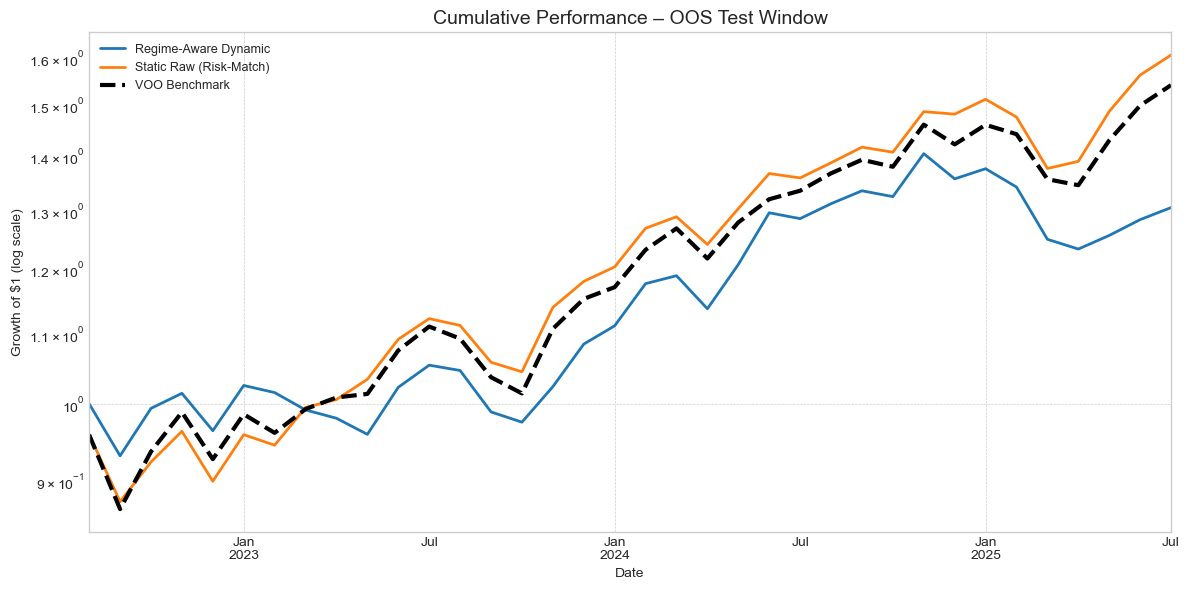


      OUT-OF-SAMPLE PERFORMANCE METRICS  
                         Total Return (%)  Annualized Return (%)  \
Static Raw (Risk-Match)            60.600                 18.340   
VOO Benchmark                      54.160                 16.830   
Regime-Aware Dynamic               30.540                 10.320   

                         Annualized Volatility (%)  Sharpe Ratio  
Static Raw (Risk-Match)                     14.750         1.240  
VOO Benchmark                               15.300         1.100  
Regime-Aware Dynamic                        13.970         0.740  


In [140]:
# --- Gather the two OOS return streams + VOO for reference --------------------
oos_strategies = {
    "Regime-Aware Dynamic": oos_port_ret,    # from the Markov model loop
    "Static Raw (Risk-Match)": oos_ret_raw,  # one-shot raw-frontier weights
    "VOO Benchmark": test_returns["VOO"].loc[oos_port_ret.index],
}

# --- Cumulative-performance plot during the test window -----------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
for name, ser in oos_strategies.items():
    if ser.dropna().empty:
        continue
    growth = (1 + ser).cumprod()
    style  = {"lw": 3, "linestyle": "--", "color": "black"} if name.startswith("VOO") else {"lw": 2}
    growth.plot(ax=ax, label=name, **style)

ax.set_title("Cumulative Performance – OOS Test Window", fontsize=14)
ax.set_xlabel("Date"); ax.set_ylabel("Growth of $1 (log scale)"); ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=9); ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout(); plt.show()

# --- Performance-metrics table ------------------------------------------------
perf = {name: calculate_performance_metrics(ser.dropna()) for name, ser in oos_strategies.items()}
perf_df = pd.DataFrame(perf).T

print("\n" + "="*60)
print("      OUT-OF-SAMPLE PERFORMANCE METRICS  ")
print("="*60)
print(perf_df.sort_values("Sharpe Ratio", ascending=False).round(2))
print("="*60)

The performance of the Markov regime switching model is quite disappointing, given how well it performed in-sample.  What could explain this?  On the one hand, the recent interest rate policy change in the last couple of years would be hard to capture in any case.  There is also the issue that the longer we forecast regimes away from the original training period, the more unreliable the model get.  In the first couple of month after fitting the Markov model, we do actually outperform VOO!  Lastly, there is also the issue of realism: would we really estimate our model once and then keep it unchanged over year and years, ignoring any recent information?

For sure, we can do better.  In would make economically more sense to regularly re-fit the models, incorporating recent observations.  Below, I implement this idea: starting of with the original training window, keeping the models constant for several months and then re-estimating the model adding the recent observation to the new training set.  To determine the best re-fitting frequency, I also do some hyper-paremter tuning.  

Noteworthy is that the Markov model is quite sensitive to the starting condition for the optimization.  In other words, the results change quite a lot if we set different seeds for the random number generator.  This is not good, but expected from the relatively few observations to fit the model.  To increase the likelihood we can hit the optimum, let's increase search_reps to improve the starting parameter setting, and maxiter, allowing for more iterations to reach an optimum.

In [141]:
chunk_grid        = [3, 6, 12]         # months between re-estimations to try
results_dyn       = {}                 # CAGR for Regime-Aware strategy
results_raw       = {}                 # CAGR for Static RAW frontier
best_series_dyn   = None               # will hold return series for best chunk
best_series_raw   = None

for CHUNK_SIZE in chunk_grid:
    print("\n" + "#"*85)
    print(f" BACK-TEST: refit every {CHUNK_SIZE:>2} months ")
    print("#"*85)

    # fresh copies so each grid value starts from the same baseline
    tr_ret   = train_returns.copy()
    tr_exog  = train_exog.copy()

    oos_dyn_list, oos_raw_list = [], []

    test_months = test_returns.index
    for start in range(0, len(test_months), CHUNK_SIZE):
        idx_slice  = test_months[start : start + CHUNK_SIZE]
        if idx_slice.empty: break
        slice_ret  = test_returns.loc[idx_slice]
        slice_exog = test_exog.loc[idx_slice]

        print(f"\n{'='*70}\n  Refit #{start//CHUNK_SIZE+1} | "
              f"chunk = {CHUNK_SIZE} mo | data through {idx_slice[-1]:%Y-%m}\n{'='*70}")

        # ── Static RAW frontier ------------------------------------------------
        exp_raw = tr_ret.mean().values * 12 - expense_vector
        cov_raw = tr_ret.cov().values  * 12
        ef_raw  = prune_frontier(efficient_frontier(cov_raw, exp_raw, FRONTIER_POINTS))
        _, w_raw = select_portfolio(ef_raw, "sigma", voo_sigma_annual)
        if w_raw is None:
            w_raw = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])

        # print top 3 holdings for transparency
        print("  RAW-frontier top holdings:")
        for idx in np.argsort(w_raw)[-3:][::-1]:
            if w_raw[idx] > 0.01:
                sym   = etf_symbols[idx]
                name  = etf_name_map.get(sym, "Unknown")
                print(f"    {sym:<5} ({name}): {w_raw[idx]:.2%}")

        w_raw_df   = pd.DataFrame([w_raw] * len(idx_slice), index=idx_slice, columns=etf_symbols)
        rtn_raw_sl = (w_raw_df.shift(1) * slice_ret[etf_symbols]).sum(axis=1).dropna()
        oos_raw_list.append(rtn_raw_sl)

        # ── Markov model -------------------------------------------------------
        mr_tr  = MarkovRegression(tr_ret["VOO"], k_regimes=2, trend="c",
                                  switching_variance=True, exog_tvtp=sm.add_constant(tr_exog))

        res_tr = mr_tr.fit(search_reps=30, maxiter=300, disp=False)
  
        labels = res_tr.smoothed_marginal_probabilities.idxmax(axis=1)
        # give it the *matching* date index — use the last len(labels) dates
        #labels.index = tr_ret.index[-len(labels):]

        # use only the rows that the model actually used
        #aligned_ret  = tr_ret.loc[labels.index]
        aligned_ret  = tr_ret

        counts = labels.value_counts()
        print("Obs per regime in current training window:")
        for r in range(k_regimes):
            print(f"  Regime {r}: {counts.get(r, 0)} months")
        
        reg_w, *_ = compute_regime_optimal_weights(
            returns=aligned_ret,
            regime_labels=labels,
            etf_symbols=etf_symbols,
            expense_vector=expense_vector,
            target_volatility=voo_sigma_annual,
            n_regimes=2,
            frontier_points=FRONTIER_POINTS,
            min_obs_per_regime=24,
        )

        mr_ts   = MarkovRegression(slice_ret["VOO"], k_regimes=2, trend="c",
                                   switching_variance=True, exog_tvtp=sm.add_constant(slice_exog))
        res_ts  = mr_ts.filter(res_tr.params)
        probs   = res_ts.predicted_marginal_probabilities
        probs.index = idx_slice

        w_dyn   = (probs.apply(lambda p: sum(p[j]*reg_w[j] for j in range(2)),
                               axis=1, result_type="expand")
                          .pipe(lambda w: w.div(w.sum(axis=1), axis=0)))
        w_dyn.columns = etf_symbols
        rtn_dyn_sl = (w_dyn.shift(1) * slice_ret[etf_symbols]).sum(axis=1).dropna()
        oos_dyn_list.append(rtn_dyn_sl)

        # expand training window
        tr_ret  = pd.concat([tr_ret,  slice_ret])
        tr_exog = pd.concat([tr_exog, slice_exog])

    # full OOS series for this chunk size
    series_dyn = pd.concat(oos_dyn_list).rename(f"dyn_{CHUNK_SIZE}")
    series_raw = pd.concat(oos_raw_list).rename(f"raw_{CHUNK_SIZE}")

    cagr_dyn   = (1+series_dyn).prod()**(12/len(series_dyn)) - 1
    cagr_raw   = (1+series_raw).prod()**(12/len(series_raw)) - 1
    results_dyn[CHUNK_SIZE] = cagr_dyn
    results_raw[CHUNK_SIZE] = cagr_raw

    if best_series_dyn is None or cagr_dyn > results_dyn.get(best_series_dyn.name.split('_')[-1], -9):
        best_series_dyn = series_dyn
    if best_series_raw is None or cagr_raw > results_raw.get(best_series_raw.name.split('_')[-1], -9):
        best_series_raw = series_raw

# ── pick optimal chunk sizes --------------------------------------------------
best_chunk_dyn  = max(results_dyn,  key=results_dyn.get)
best_chunk_raw  = max(results_raw,  key=results_raw.get)

print("\n" + "#"*85)
print("Hyper-parameter tuning complete")
for c in chunk_grid:
    print(f"  {c:>2}-month | Regime-Aware CAGR {results_dyn[c]:.2%} "
          f"| RAW CAGR {results_raw[c]:.2%}")
print(f"\n⇒ Best chunk: Regime-Aware = {best_chunk_dyn} mo,  RAW = {best_chunk_raw} mo")
print("#"*85)


#####################################################################################
 BACK-TEST: refit every  3 months 
#####################################################################################

  Refit #1 | chunk = 3 mo | data through 2022-10
  RAW-frontier top holdings:
    VONG  (Russell 1000 Growth ETF): 71.55%
    VIG   (Dividend Appreciation ETF): 16.20%
    VTIP  (Short-Term Inflation-Protected Securities ETF): 12.23%
Obs per regime in current training window:
  Regime 0: 43 months
  Regime 1: 41 months
  > Top 3 ETFs for Regime 0 Portfolio (matching VOO vol):
    VTIP (Short-Term Inflation-Protected Securities ETF): 51.39%
    VIOV (S&P Small-Cap 600 Value ETF): 48.61%
  > Top 3 ETFs for Regime 1 Portfolio (matching VOO vol):
    MGK (Mega Cap Growth ETF): 100.00%

  Refit #2 | chunk = 3 mo | data through 2023-01
  RAW-frontier top holdings:
    VONG  (Russell 1000 Growth ETF): 53.21%
    VIG   (Dividend Appreciation ETF): 36.88%
    VGSH  (Short-Term Treasury ETF

In turns out, annual refitting is optimal.  There are a couple of interesting observations for this method: 
* Adding additional data to the static mean-variance optimization does not substantially change the optimal portfolio!  We still get a mix of the Russell 1000 Growth ETF and the Short-Term Treasury ETF, with 80% going into the Growth ETF and 20% into the Treasury ETF.
* The re-fitted Markov regime switching model provides quite similar estimates up to 2024; Regime 0 contains a mixture similar to the static mean-variance optimization with 80% invested in Growth ETFs and 20% in Treasury ETFs, while Regime 1 mixes between the Russel 2000 Value ETF, VTWV, and the Russell 1000 Growth ETF, VONG.  VTWV has quite a high volatility with medium returns, why mix it with VONG then?  Because they are only moderately correlated, allowing for some diversification.
* The last re-fit of the Markov model changes the optimal portfolio composition quite dramatically: now, we have for Regime 1 a mix of US-Mega Cap and the ex-US ETF.  This provides some more aggressive return while mainting some diversification with the US Mega Caps.

As above for the in-sample back testing, we can now calculate the out-of-sample performance metrics.

In [142]:
# Gather ALL OOS return streams (align on common index)
oos_strategies = {
    "Dynamic Regime (refit)"      : best_series_dyn,  # refit Markov
    "Dynamic Regime (single fit)" : oos_port_ret,     # one-shot Markov
    "RAW Frontier (refit)"        : best_series_raw,  # refit raw σ-match
    "Static RAW Frontier"         : oos_ret_raw,      # one-shot raw σ-match
    "VOO Benchmark"               : test_returns["VOO"].loc[oos_port_ret.index],
}

# make sure all series share the same date index for plotting / metrics
common_idx = sorted(set().union(*(s.index for s in oos_strategies.values())))
oos_strategies = {k: v.reindex(common_idx).dropna() for k, v in oos_strategies.items()}

# Performance-metrics table
perf = {name: calculate_performance_metrics(ser) for name, ser in oos_strategies.items()}
perf_df = pd.DataFrame(perf).T

print("\n" + "="*70)
print("           OUT-OF-SAMPLE PERFORMANCE METRICS")
print("="*70)
print(perf_df.sort_values("Sharpe Ratio", ascending=False).round(2))
print("="*70)


           OUT-OF-SAMPLE PERFORMANCE METRICS
                             Total Return (%)  Annualized Return (%)  \
RAW Frontier (refit)                   65.990                 19.600   
Static RAW Frontier                    60.600                 18.340   
VOO Benchmark                          54.160                 16.830   
Dynamic Regime (refit)                 30.300                 10.170   
Dynamic Regime (single fit)            30.540                 10.320   

                             Annualized Volatility (%)  Sharpe Ratio  
RAW Frontier (refit)                            14.440         1.360  
Static RAW Frontier                             14.750         1.240  
VOO Benchmark                                   15.300         1.100  
Dynamic Regime (refit)                          13.360         0.760  
Dynamic Regime (single fit)                     13.970         0.740  


Plot also cumulative returns for the out-of-sample period.

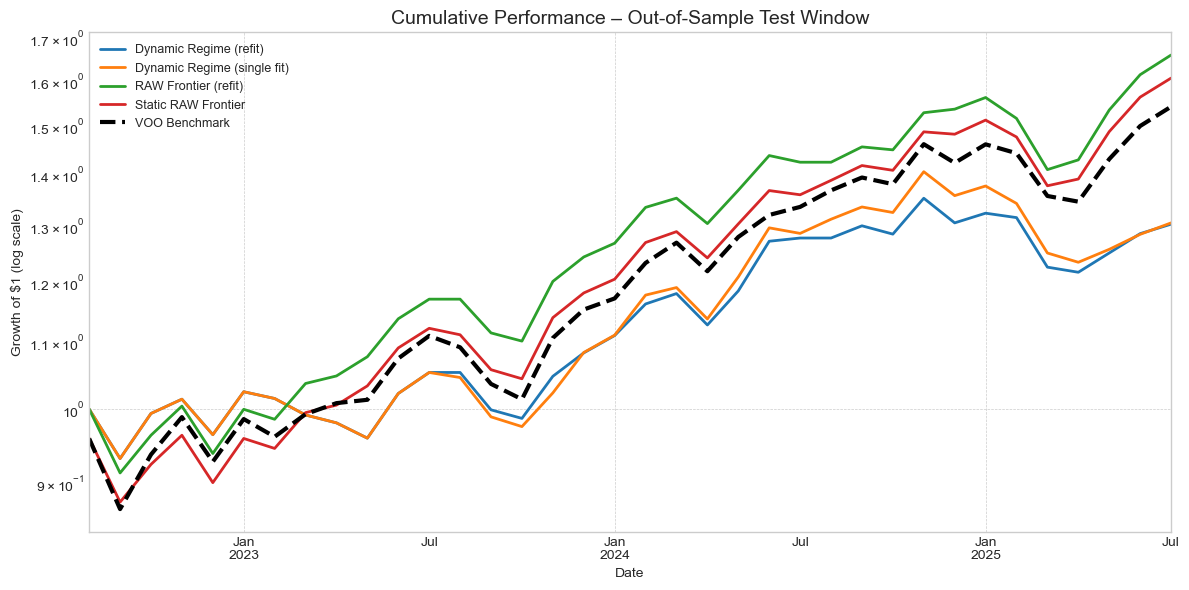

In [143]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

for name, ser in oos_strategies.items():
    growth = (1 + ser).cumprod()
    style  = {"lw": 3, "linestyle": "--", "color": "black"} if name.startswith("VOO") else {"lw": 2}
    growth.plot(ax=ax, label=name, **style)

ax.set_title("Cumulative Performance – Out-of-Sample Test Window", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1 (log scale)")
ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Under the more realistic assumption that we re-estimate the model regularly as new data become available, the regime-switching and mean-variance optimization method perform much better!  The performance of both models is quite similar for the re-fitted version, showing how important it is to have a recent time series to estimating Markov regime switching models, especially given the relatively recent changes in the interest rate environment, previous periods might not reflect the.  We also see how dangerous it is to extrapolate too long using an outdated model; in the first couple of months after the initial fit the Markov model does perform better than VOO, but this changes after around half a year.  

### 9. Tool to select optimal portfolio

We know now that the best performance is by the optimal portfolio defined by the simple static mean-variance optimization.  So, let's users select their preferences based on expected return or volatility and provide the optimal portfolio on the mean-variance efficient frontier.

In [144]:
# --- Frontier arrays – ensure they exist ---

sigmas = np.asarray(ef_raw["sigma"])
mus = np.asarray(ef_raw["mu"])
weights = np.asarray(ef_raw["weights"])

symbols = globals().get("symbols", etf_symbols)
name_map = globals().get("name_map", etf_name_map)

# --- Build the figure ---

fig = go.FigureWidget()
fig.layout.hovermode = "closest"
fig.layout.clickmode = "event+select"
fig.layout.plot_bgcolor = "white"
fig.layout.paper_bgcolor = "white"

fig.add_scatter(x=sigmas, y=mus, mode="lines", line=dict(color="lightgray"),
                hoverinfo="skip", showlegend=False)

frontier_pts = go.Scatter(
    x=sigmas, y=mus, mode="markers",
    marker=dict(size=7, color="gray", opacity=0.5),
    name="Raw Frontier",
    hoverlabel=dict(bgcolor="white"),
    hovertemplate="σ: %{x:.2%}<br>µ: %{y:.2%}<br>(click to see top weights)<extra></extra>"
)
fig.add_trace(frontier_pts)

fig.add_scatter(x=[voo_sigma_annual], y=[voo_mu_annual], mode="markers",
                marker=dict(symbol="diamond", size=14, color="royalblue", line=dict(width=2, color="black")),
                name="VOO (ref)",
                hoverlabel=dict(bgcolor="white"),
                hovertemplate="VOO\nσ: %{x:.2%}<br>µ: %{y:.2%}<extra></extra>")

mid = len(sigmas) // 2
fig.add_scatter(x=[sigmas[mid]], y=[mus[mid]], mode="markers",
                marker=dict(size=14, color="red", line=dict(width=2, color="black")),
                name="Selected",
                hoverinfo="skip")
sel_idx = len(fig.data) - 1

fig.update_layout(title="Efficient Frontier (Raw Estimates)",
                  xaxis_title="Volatility (σ)", yaxis_title="Expected Return (µ)",
                  height=480)

# --- Top 3 Portfolio Components ---

def format_html(idx: int) -> str:
    w = weights[idx]
    top_idx = np.argsort(w)[-3:][::-1]
    rows = [
        f"<li><b>{symbols[i]}</b> <span style='color:#666'>({name_map.get(symbols[i],'Unknown')})</span>"
        f"<span style='float:right'>{w[i]:.2%}</span></li>"
        for i in top_idx if w[i] > 0.001
    ]
    return (
        "<div style='font-family:Arial, sans-serif; font-size:14px; line-height:1.4; max-width:420px;'>"
        f"<h4 style='margin:4px 0 8px 0; font-size:15px;'>Top 3 ETFs – Frontier Point {idx+1}</h4>"
        "<ul style='list-style:none; padding-left:0; margin:0;'>" + "\n".join(rows) + "</ul></div>"
    )

out = HTML()

# --- Sliders ---

mu_slider = FloatSlider(value=mus[mid], min=mus.min(), max=mus.max(), step=0.0005,
                        description="Target µ", readout_format=".2%", continuous_update=False,
                        layout=dict(width="450px"))

sigma_slider = FloatSlider(value=sigmas[mid], min=sigmas.min(), max=sigmas.max(), step=0.0005,
                           description="Target σ", readout_format=".2%", continuous_update=False,
                           layout=dict(width="450px"))

# --- Sync logic ---

def move_to_index(idx: int):
    with fig.batch_update():
        fig.data[sel_idx].x = [sigmas[idx]]
        fig.data[sel_idx].y = [mus[idx]]
    mu_slider.value = mus[idx]
    sigma_slider.value = sigmas[idx]
    out.value = format_html(idx)

move_to_index(mid)

def on_mu_change(change):
    if change["name"] == "value":
        idx = int(np.argmin(np.abs(mus - change["new"])))
        move_to_index(idx)

def on_sigma_change(change):
    if change["name"] == "value":
        idx = int(np.argmin(np.abs(sigmas - change["new"])))
        move_to_index(idx)

mu_slider.observe(on_mu_change, names="value")
sigma_slider.observe(on_sigma_change, names="value")

fig.data[1].on_click(lambda trace, points, selector: move_to_index(points.point_inds[0]) if points.point_inds else None)

# --- Snap-to button for VOO mu and sigma ---

snap_button = Button(description="Snap to VOO", button_style="info")
snap_criterion = Dropdown(
    options=[("Match µ (return)", "mu"), ("Match σ (volatility)", "sigma")],
    value="mu",
    layout=dict(width="180px")
)

def on_snap(_):
    if snap_criterion.value == "mu":
        idx = int(np.argmin(np.abs(mus - voo_mu_annual)))
    else:
        idx = int(np.argmin(np.abs(sigmas - voo_sigma_annual)))
    move_to_index(idx)

snap_button.on_click(on_snap)

# --- Display ------------------------------------------------------

display(VBox([
    fig,
    mu_slider,
    sigma_slider,
    HBox([snap_button, snap_criterion]),
    out
]))

    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'lightgray'},…

### References

* Markowitz, H. (1952). **Portfolio Selection**. *Journal of Finance*, 7(1), 77–91.  
* Ledoit, O., & Wolf, M. (2004). **Honey, I Shrunk the Sample Covariance Matrix**. *Journal of Portfolio Management*, 30(4).  
* Black, F., & Litterman, R. (1992). **Global Portfolio Optimization**. *Financial Analysts Journal*, 48(5).  
* Michaud, R. (1998). **Efficient Asset Management**. Harvard Business School Press.  
* Engle, R. (2002). **Dynamic Conditional Correlation—A Simple Class of Multivariate GARCH Models**. *Journal of Business & Economic Statistics*, 20(3).  
* Maillard, S., Roncalli, T., & Teïletche, J. (2010). **The Properties of Equally Weighted Risk Contribution Portfolios**. *Journal of Portfolio Management*, 36(4).  
* López de Prado, M. (2020). **Advances in Financial Machine Learning**. Wiley.